# Mask R-CNN - Train on Bridge Dataset


This notebook shows how to train Mask R-CNN on your own dataset. You'd still need a GPU, though, because the network backbone is a Resnet101, which would be too slow to train on a CPU. On a GPU, you can start to get okay-ish results in a few minutes, and good results in less than an hour.

In [1]:
import os, sys
# Root directory of the project
ROOT_DIR = os.path.abspath("../")

# Import Mask RCNN
sys.path.append(ROOT_DIR)

In [2]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import skimage.draw
import cv2
import matplotlib
import matplotlib.pyplot as plt
from pathlib import Path
import json

# Root directory of the project
#ROOT_DIR = os.path.abspath("../../")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log

%matplotlib inline 

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")
DEFAULT_LOGS_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages

... done downloading pretrained model!


## Configurations

In [3]:
class BridgesConfig(Config):
    """Configuration for training on the toy shapes dataset.
    Derives from the base Config class and overrides values specific
    to the toy shapes dataset.
    """
    # Give the configuration a recognizable name
    NAME = "object"

    # Train on 1 GPU and 8 images per GPU. We can put multiple images on each
    # GPU because the images are small. Batch size is 8 (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

    # Number of classes (including background)
    NUM_CLASSES = 1 + 2  # background + 3 shapes

    # Number of training steps per epoch
    STEPS_PER_EPOCH = 100

    # Skip detections with < 90% confidence
    #DETECTION_MIN_CONFIDENCE = 0.8
    
config = BridgesConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                15
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE         

## Notebook Preferences

In [4]:
def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

## Dataset

Create a synthetic dataset

Extend the Dataset class and add a method to load the shapes dataset, `load_shapes()`, and override the following methods:

* load_image()
* load_mask()
* image_reference()

In [5]:
class CustomDataset(utils.Dataset):

    def load_custom(self, dataset_dir, subset):
        """Load a subset of the Dog-Cat dataset.
        dataset_dir: Root directory of the dataset.
        subset: Subset to load: train or val
        """
        # Add classes. We have only one class to add.
        self.add_class("object", 1, "Bridge")
        self.add_class("object", 2, "Overpass")

        # Train or validation dataset?
        assert subset in ["train", "val"]
        dataset_dir = os.path.join(dataset_dir, subset)

        # Load annotations
        # VGG Image Annotator saves each image in the form:
        # { 'filename': '28503151_5b5b7ec140_b.jpg',
        #   'regions': {
        #       '0': {
        #           'region_attributes': {},
        #           'shape_attributes': {
        #               'all_points_x': [...],
        #               'all_points_y': [...],
        #               'name': 'polygon'}},
        #       ... more regions ...
        #   },
        #   'size': 100202
        # }
        # We mostly care about the x and y coordinates of each region
        annotations1 = json.load(open(os.path.join(dataset_dir, "bridge_data.json")))
        # print(annotations1)
        annotations = list(annotations1.values())  # don't need the dict keys

        # The VIA tool saves images in the JSON even if they don't have any
        # annotations. Skip unannotated images.
        annotations = [a for a in annotations if a['regions']]
        
        # Add images
        for a in annotations:
            # print(a)
            # Get the x, y coordinaets of points of the polygons that make up
            # the outline of each object instance. There are stores in the
            # shape_attributes (see json format above)
            polygons = [r['shape_attributes'] for r in a['regions']] 
            objects = [s['region_attributes']['name'] for s in a['regions']]
            print("objects:",objects)
            name_dict = {"bridge": 1, 'overpass':2}
            # key = tuple(name_dict)
            num_ids = [name_dict[a] for a in objects]
     
            # num_ids = [int(n['Event']) for n in objects]
            # load_mask() needs the image size to convert polygons to masks.
            # Unfortunately, VIA doesn't include it in JSON, so we must read
            # the image. This is only managable since the dataset is tiny.
            print("numids",num_ids)
            image_path = os.path.join(dataset_dir, a['filename'])
            image = skimage.io.imread(image_path)
            height, width = image.shape[:2]

            self.add_image(
                "object",  ## for a single class just add the name here
                image_id=a['filename'],  # use file name as a unique image id
                path=image_path,
                width=width, height=height,
                polygons=polygons,
                num_ids=num_ids
                )

    def load_mask(self, image_id):
        """Generate instance masks for an image.
       Returns:
        masks: A bool array of shape [height, width, instance count] with
            one mask per instance.
        class_ids: a 1D array of class IDs of the instance masks.
        """
        # If not a Dog-Cat dataset image, delegate to parent class.
        image_info = self.image_info[image_id]
        if image_info["source"] != "object":
            return super(self.__class__, self).load_mask(image_id)

        # Convert polygons to a bitmap mask of shape
        # [height, width, instance_count]
        info = self.image_info[image_id]
        if info["source"] != "object":
            return super(self.__class__, self).load_mask(image_id)
        num_ids = info['num_ids']
        mask = np.zeros([info["height"], info["width"], len(info["polygons"])],
                        dtype=np.uint8)
        for i, p in enumerate(info["polygons"]):
            # Get indexes of pixels inside the polygon and set them to 1
        	rr, cc = skimage.draw.polygon(p['all_points_y'], p['all_points_x'])

        	mask[rr, cc, i] = 1

        # Return mask, and array of class IDs of each instance. Since we have
        # one class ID only, we return an array of 1s
        # Map class names to class IDs.
        num_ids = np.array(num_ids, dtype=np.int32)
        return mask, num_ids #np.ones([mask.shape[-1]], dtype=np.int32)

    def image_reference(self, image_id):
        """Return the path of the image."""
        info = self.image_info[image_id]
        if info["source"] == "object":
            return info["path"]
        else:
            super(self.__class__, self).image_reference(image_id)

In [10]:
Path.cwd().parent.parent.parent / 'data' / 'bridge_dataset'

WindowsPath('C:/Users/rgi-bird/source/repos/video-lidar-object-detection/data/bridge_dataset')

In [11]:
# Training dataset
data_path = Path.cwd().parent.parent.parent / 'data' / 'bridge_dataset'
dataset_train = CustomDataset()
dataset_train.load_custom(data_path, "train")
dataset_train.prepare()

# Validation dataset
dataset_val = CustomDataset()
dataset_val.load_custom(data_path, "val")
dataset_val.prepare()

objects: ['bridge']
numids [1]
objects: ['bridge', 'bridge']
numids [1, 1]
objects: ['bridge']
numids [1]
objects: ['bridge']
numids [1]
objects: ['bridge']
numids [1]
objects: ['overpass']
numids [2]
objects: ['overpass']
numids [2]
objects: ['bridge']
numids [1]
objects: ['bridge']
numids [1]
objects: ['bridge']
numids [1]
objects: ['bridge']
numids [1]
objects: ['bridge']
numids [1]
objects: ['bridge']
numids [1]
objects: ['bridge']
numids [1]
objects: ['bridge']
numids [1]
objects: ['bridge']
numids [1]
objects: ['bridge']
numids [1]
objects: ['bridge']
numids [1]
objects: ['bridge']
numids [1]
objects: ['bridge', 'bridge']
numids [1, 1]
objects: ['bridge']
numids [1]
objects: ['bridge']
numids [1]
objects: ['bridge']
numids [1]
objects: ['bridge']
numids [1]
objects: ['bridge']
numids [1]
objects: ['bridge']
numids [1]
objects: ['bridge']
numids [1]
objects: ['bridge']
numids [1]
objects: ['bridge']
numids [1]
objects: ['bridge']
numids [1]
objects: ['bridge', 'bridge']
numids [1,

## Create Model

In [12]:
# Create model in training mode
config = BridgesConfig()
model = modellib.MaskRCNN(mode="training", config=config, model_dir=DEFAULT_LOGS_DIR)







Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
box_ind is deprecated, use box_indices instead


In [13]:
# Which weights to start with?
init_with = "coco"  # imagenet, coco, or last

if init_with == "imagenet":
    model.load_weights(model.get_imagenet_weights(), by_name=True)
elif init_with == "coco":
    # Load weights trained on MS COCO, but skip layers that
    # are different due to the different number of classes
    # See README for instructions to download the COCO weights
    model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])
elif init_with == "last":
    # Load the last model you trained and continue training
    model.load_weights(model.find_last(), by_name=True)

## Training

Train in two stages:
1. Only the heads. Here we're freezing all the backbone layers and training only the randomly initialized layers (i.e. the ones that we didn't use pre-trained weights from MS COCO). To train only the head layers, pass `layers='heads'` to the `train()` function.

2. Fine-tune all layers. For this simple example it's not necessary, but we're including it to show the process. Simply pass `layers="all` to train all layers.

In [14]:
# Train the head branches
# Passing layers="heads" freezes all layers except the head
# layers. You can also pass a regular expression to select
# which layers to train by name pattern.
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE, 
            epochs=10, 
            layers='heads')


Starting at epoch 0. LR=0.001

Checkpoint Path: C:\Users\rgi-bird\source\repos\video-lidar-object-detection\mask_rcnn_tf\Mask_RCNN\logs\object20210302T1242\mask_rcnn_object_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDis

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\tensorflow\python\ops\gradients_util.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\tensorflow\python\ops\gradients_util.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\tensorflow\python\ops\gradients_util.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "




Epoch 1/10


C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  1/100 [..............................] - ETA: 17:10 - loss: 8.7841 - rpn_class_loss: 0.2293 - rpn_bbox_loss: 1.0157 - mrcnn_class_loss: 1.9529 - mrcnn_bbox_loss: 1.7647 - mrcnn_mask_loss: 3.8215

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  2/100 [..............................] - ETA: 9:11 - loss: 7.7662 - rpn_class_loss: 0.1390 - rpn_bbox_loss: 0.6571 - mrcnn_class_loss: 1.5536 - mrcnn_bbox_loss: 1.3277 - mrcnn_mask_loss: 4.0887 

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  3/100 [..............................] - ETA: 6:28 - loss: 6.5508 - rpn_class_loss: 0.0980 - rpn_bbox_loss: 0.6893 - mrcnn_class_loss: 1.1563 - mrcnn_bbox_loss: 1.2934 - mrcnn_mask_loss: 3.3138

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  4/100 [>.............................] - ETA: 5:21 - loss: 6.7758 - rpn_class_loss: 0.3824 - rpn_bbox_loss: 0.9935 - mrcnn_class_loss: 0.9306 - mrcnn_bbox_loss: 1.2170 - mrcnn_mask_loss: 3.2524

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  5/100 [>.............................] - ETA: 4:27 - loss: 6.1123 - rpn_class_loss: 0.3125 - rpn_bbox_loss: 0.8652 - mrcnn_class_loss: 0.7981 - mrcnn_bbox_loss: 1.2094 - mrcnn_mask_loss: 2.9272

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  6/100 [>.............................] - ETA: 3:52 - loss: 5.4431 - rpn_class_loss: 0.2772 - rpn_bbox_loss: 0.7708 - mrcnn_class_loss: 0.6758 - mrcnn_bbox_loss: 1.1624 - mrcnn_mask_loss: 2.5568

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  7/100 [=>............................] - ETA: 3:26 - loss: 5.2526 - rpn_class_loss: 0.2399 - rpn_bbox_loss: 0.7522 - mrcnn_class_loss: 0.5922 - mrcnn_bbox_loss: 1.2146 - mrcnn_mask_loss: 2.4538

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  8/100 [=>............................] - ETA: 3:07 - loss: 4.9303 - rpn_class_loss: 0.2204 - rpn_bbox_loss: 0.7803 - mrcnn_class_loss: 0.5367 - mrcnn_bbox_loss: 1.1415 - mrcnn_mask_loss: 2.2514

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  9/100 [=>............................] - ETA: 2:52 - loss: 4.7280 - rpn_class_loss: 0.2109 - rpn_bbox_loss: 0.8305 - mrcnn_class_loss: 0.4932 - mrcnn_bbox_loss: 1.1085 - mrcnn_mask_loss: 2.0849

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 10/100 [==>...........................] - ETA: 2:40 - loss: 4.4659 - rpn_class_loss: 0.1925 - rpn_bbox_loss: 0.7718 - mrcnn_class_loss: 0.4729 - mrcnn_bbox_loss: 1.0885 - mrcnn_mask_loss: 1.9401

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 11/100 [==>...........................] - ETA: 2:30 - loss: 4.2248 - rpn_class_loss: 0.1769 - rpn_bbox_loss: 0.7208 - mrcnn_class_loss: 0.4491 - mrcnn_bbox_loss: 1.0503 - mrcnn_mask_loss: 1.8277

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 12/100 [==>...........................] - ETA: 2:22 - loss: 4.0926 - rpn_class_loss: 0.1638 - rpn_bbox_loss: 0.7143 - mrcnn_class_loss: 0.4162 - mrcnn_bbox_loss: 1.0734 - mrcnn_mask_loss: 1.7249

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 13/100 [==>...........................] - ETA: 2:15 - loss: 3.9846 - rpn_class_loss: 0.1633 - rpn_bbox_loss: 0.7297 - mrcnn_class_loss: 0.3979 - mrcnn_bbox_loss: 1.0537 - mrcnn_mask_loss: 1.6400

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 14/100 [===>..........................] - ETA: 2:09 - loss: 3.9112 - rpn_class_loss: 0.1591 - rpn_bbox_loss: 0.7731 - mrcnn_class_loss: 0.3709 - mrcnn_bbox_loss: 1.0368 - mrcnn_mask_loss: 1.5713

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 15/100 [===>..........................] - ETA: 2:03 - loss: 3.8573 - rpn_class_loss: 0.1502 - rpn_bbox_loss: 0.7832 - mrcnn_class_loss: 0.3510 - mrcnn_bbox_loss: 1.0566 - mrcnn_mask_loss: 1.5164

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 16/100 [===>..........................] - ETA: 1:58 - loss: 3.8077 - rpn_class_loss: 0.1420 - rpn_bbox_loss: 0.7924 - mrcnn_class_loss: 0.3314 - mrcnn_bbox_loss: 1.0777 - mrcnn_mask_loss: 1.4642

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 17/100 [====>.........................] - ETA: 1:53 - loss: 3.8212 - rpn_class_loss: 0.1429 - rpn_bbox_loss: 0.8284 - mrcnn_class_loss: 0.3153 - mrcnn_bbox_loss: 1.1175 - mrcnn_mask_loss: 1.4170

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 18/100 [====>.........................] - ETA: 1:49 - loss: 3.7031 - rpn_class_loss: 0.1365 - rpn_bbox_loss: 0.8117 - mrcnn_class_loss: 0.2983 - mrcnn_bbox_loss: 1.0800 - mrcnn_mask_loss: 1.3767

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 19/100 [====>.........................] - ETA: 1:45 - loss: 3.6339 - rpn_class_loss: 0.1311 - rpn_bbox_loss: 0.7977 - mrcnn_class_loss: 0.2845 - mrcnn_bbox_loss: 1.0824 - mrcnn_mask_loss: 1.3382

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 20/100 [=====>........................] - ETA: 1:43 - loss: 3.5849 - rpn_class_loss: 0.1282 - rpn_bbox_loss: 0.7903 - mrcnn_class_loss: 0.2749 - mrcnn_bbox_loss: 1.0878 - mrcnn_mask_loss: 1.3037

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 21/100 [=====>........................] - ETA: 1:40 - loss: 3.5066 - rpn_class_loss: 0.1225 - rpn_bbox_loss: 0.7683 - mrcnn_class_loss: 0.2644 - mrcnn_bbox_loss: 1.0776 - mrcnn_mask_loss: 1.2738

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 22/100 [=====>........................] - ETA: 1:37 - loss: 3.4362 - rpn_class_loss: 0.1171 - rpn_bbox_loss: 0.7472 - mrcnn_class_loss: 0.2529 - mrcnn_bbox_loss: 1.0707 - mrcnn_mask_loss: 1.2484

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 23/100 [=====>........................] - ETA: 1:34 - loss: 3.3785 - rpn_class_loss: 0.1182 - rpn_bbox_loss: 0.7490 - mrcnn_class_loss: 0.2446 - mrcnn_bbox_loss: 1.0394 - mrcnn_mask_loss: 1.2273

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 24/100 [======>.......................] - ETA: 1:32 - loss: 3.3206 - rpn_class_loss: 0.1136 - rpn_bbox_loss: 0.7349 - mrcnn_class_loss: 0.2355 - mrcnn_bbox_loss: 1.0336 - mrcnn_mask_loss: 1.2030

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 25/100 [======>.......................] - ETA: 1:29 - loss: 3.3027 - rpn_class_loss: 0.1207 - rpn_bbox_loss: 0.7441 - mrcnn_class_loss: 0.2310 - mrcnn_bbox_loss: 1.0264 - mrcnn_mask_loss: 1.1805

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 26/100 [======>.......................] - ETA: 1:29 - loss: 3.2519 - rpn_class_loss: 0.1172 - rpn_bbox_loss: 0.7408 - mrcnn_class_loss: 0.2245 - mrcnn_bbox_loss: 1.0090 - mrcnn_mask_loss: 1.1604

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 27/100 [=======>......................] - ETA: 1:27 - loss: 3.1894 - rpn_class_loss: 0.1138 - rpn_bbox_loss: 0.7193 - mrcnn_class_loss: 0.2183 - mrcnn_bbox_loss: 0.9913 - mrcnn_mask_loss: 1.1467

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 28/100 [=======>......................] - ETA: 1:24 - loss: 3.1218 - rpn_class_loss: 0.1102 - rpn_bbox_loss: 0.7054 - mrcnn_class_loss: 0.2112 - mrcnn_bbox_loss: 0.9657 - mrcnn_mask_loss: 1.1294

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 29/100 [=======>......................] - ETA: 1:23 - loss: 3.0660 - rpn_class_loss: 0.1064 - rpn_bbox_loss: 0.6838 - mrcnn_class_loss: 0.2069 - mrcnn_bbox_loss: 0.9533 - mrcnn_mask_loss: 1.1155

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 30/100 [========>.....................] - ETA: 1:21 - loss: 3.0398 - rpn_class_loss: 0.1033 - rpn_bbox_loss: 0.6892 - mrcnn_class_loss: 0.2019 - mrcnn_bbox_loss: 0.9480 - mrcnn_mask_loss: 1.0974

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 31/100 [========>.....................] - ETA: 1:19 - loss: 2.9986 - rpn_class_loss: 0.1000 - rpn_bbox_loss: 0.6780 - mrcnn_class_loss: 0.1965 - mrcnn_bbox_loss: 0.9389 - mrcnn_mask_loss: 1.0852

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 32/100 [========>.....................] - ETA: 1:17 - loss: 3.0530 - rpn_class_loss: 0.1065 - rpn_bbox_loss: 0.7538 - mrcnn_class_loss: 0.1938 - mrcnn_bbox_loss: 0.9256 - mrcnn_mask_loss: 1.0733

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 33/100 [========>.....................] - ETA: 1:15 - loss: 3.0066 - rpn_class_loss: 0.1033 - rpn_bbox_loss: 0.7383 - mrcnn_class_loss: 0.1924 - mrcnn_bbox_loss: 0.9129 - mrcnn_mask_loss: 1.0597

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 34/100 [=========>....................] - ETA: 1:14 - loss: 2.9953 - rpn_class_loss: 0.1010 - rpn_bbox_loss: 0.7579 - mrcnn_class_loss: 0.1870 - mrcnn_bbox_loss: 0.9013 - mrcnn_mask_loss: 1.0480

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 35/100 [=========>....................] - ETA: 1:13 - loss: 2.9845 - rpn_class_loss: 0.1014 - rpn_bbox_loss: 0.7643 - mrcnn_class_loss: 0.1841 - mrcnn_bbox_loss: 0.8986 - mrcnn_mask_loss: 1.0361

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 36/100 [=========>....................] - ETA: 1:11 - loss: 2.9825 - rpn_class_loss: 0.1070 - rpn_bbox_loss: 0.7680 - mrcnn_class_loss: 0.1838 - mrcnn_bbox_loss: 0.8995 - mrcnn_mask_loss: 1.0243

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 37/100 [==========>...................] - ETA: 1:10 - loss: 2.9570 - rpn_class_loss: 0.1050 - rpn_bbox_loss: 0.7601 - mrcnn_class_loss: 0.1841 - mrcnn_bbox_loss: 0.8926 - mrcnn_mask_loss: 1.0152

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 38/100 [==========>...................] - ETA: 1:08 - loss: 2.9393 - rpn_class_loss: 0.1031 - rpn_bbox_loss: 0.7618 - mrcnn_class_loss: 0.1802 - mrcnn_bbox_loss: 0.8877 - mrcnn_mask_loss: 1.0065

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 39/100 [==========>...................] - ETA: 1:07 - loss: 2.9052 - rpn_class_loss: 0.1008 - rpn_bbox_loss: 0.7571 - mrcnn_class_loss: 0.1763 - mrcnn_bbox_loss: 0.8727 - mrcnn_mask_loss: 0.9984

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 40/100 [===========>..................] - ETA: 1:07 - loss: 2.8781 - rpn_class_loss: 0.0986 - rpn_bbox_loss: 0.7547 - mrcnn_class_loss: 0.1722 - mrcnn_bbox_loss: 0.8584 - mrcnn_mask_loss: 0.9941

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 41/100 [===========>..................] - ETA: 1:05 - loss: 2.8453 - rpn_class_loss: 0.0971 - rpn_bbox_loss: 0.7448 - mrcnn_class_loss: 0.1685 - mrcnn_bbox_loss: 0.8512 - mrcnn_mask_loss: 0.9838

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 42/100 [===========>..................] - ETA: 1:04 - loss: 2.8099 - rpn_class_loss: 0.0959 - rpn_bbox_loss: 0.7359 - mrcnn_class_loss: 0.1653 - mrcnn_bbox_loss: 0.8388 - mrcnn_mask_loss: 0.9741

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 43/100 [===========>..................] - ETA: 1:04 - loss: 2.7917 - rpn_class_loss: 0.0941 - rpn_bbox_loss: 0.7347 - mrcnn_class_loss: 0.1635 - mrcnn_bbox_loss: 0.8320 - mrcnn_mask_loss: 0.9674

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 44/100 [============>.................] - ETA: 1:02 - loss: 2.7943 - rpn_class_loss: 0.0923 - rpn_bbox_loss: 0.7557 - mrcnn_class_loss: 0.1604 - mrcnn_bbox_loss: 0.8267 - mrcnn_mask_loss: 0.9592

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 45/100 [============>.................] - ETA: 1:01 - loss: 2.7612 - rpn_class_loss: 0.0908 - rpn_bbox_loss: 0.7448 - mrcnn_class_loss: 0.1570 - mrcnn_bbox_loss: 0.8160 - mrcnn_mask_loss: 0.9525

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 46/100 [============>.................] - ETA: 59s - loss: 2.7391 - rpn_class_loss: 0.0892 - rpn_bbox_loss: 0.7385 - mrcnn_class_loss: 0.1540 - mrcnn_bbox_loss: 0.8101 - mrcnn_mask_loss: 0.9473 

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 47/100 [=============>................] - ETA: 58s - loss: 2.7208 - rpn_class_loss: 0.0875 - rpn_bbox_loss: 0.7328 - mrcnn_class_loss: 0.1513 - mrcnn_bbox_loss: 0.8110 - mrcnn_mask_loss: 0.9382

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 48/100 [=============>................] - ETA: 56s - loss: 2.7149 - rpn_class_loss: 0.0864 - rpn_bbox_loss: 0.7507 - mrcnn_class_loss: 0.1484 - mrcnn_bbox_loss: 0.7988 - mrcnn_mask_loss: 0.9307

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 49/100 [=============>................] - ETA: 55s - loss: 2.6963 - rpn_class_loss: 0.0862 - rpn_bbox_loss: 0.7473 - mrcnn_class_loss: 0.1471 - mrcnn_bbox_loss: 0.7914 - mrcnn_mask_loss: 0.9242

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 50/100 [==============>...............] - ETA: 53s - loss: 2.6770 - rpn_class_loss: 0.0855 - rpn_bbox_loss: 0.7432 - mrcnn_class_loss: 0.1451 - mrcnn_bbox_loss: 0.7857 - mrcnn_mask_loss: 0.9175

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 51/100 [==============>...............] - ETA: 52s - loss: 2.6741 - rpn_class_loss: 0.0859 - rpn_bbox_loss: 0.7477 - mrcnn_class_loss: 0.1430 - mrcnn_bbox_loss: 0.7821 - mrcnn_mask_loss: 0.9154

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 52/100 [==============>...............] - ETA: 51s - loss: 2.6552 - rpn_class_loss: 0.0851 - rpn_bbox_loss: 0.7403 - mrcnn_class_loss: 0.1409 - mrcnn_bbox_loss: 0.7796 - mrcnn_mask_loss: 0.9094

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 53/100 [==============>...............] - ETA: 50s - loss: 2.6572 - rpn_class_loss: 0.0840 - rpn_bbox_loss: 0.7534 - mrcnn_class_loss: 0.1384 - mrcnn_bbox_loss: 0.7761 - mrcnn_mask_loss: 0.9053

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 54/100 [===============>..............] - ETA: 48s - loss: 2.6601 - rpn_class_loss: 0.0829 - rpn_bbox_loss: 0.7612 - mrcnn_class_loss: 0.1366 - mrcnn_bbox_loss: 0.7778 - mrcnn_mask_loss: 0.9017

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 55/100 [===============>..............] - ETA: 47s - loss: 2.6379 - rpn_class_loss: 0.0818 - rpn_bbox_loss: 0.7526 - mrcnn_class_loss: 0.1343 - mrcnn_bbox_loss: 0.7727 - mrcnn_mask_loss: 0.8966

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 56/100 [===============>..............] - ETA: 46s - loss: 2.6233 - rpn_class_loss: 0.0807 - rpn_bbox_loss: 0.7503 - mrcnn_class_loss: 0.1337 - mrcnn_bbox_loss: 0.7685 - mrcnn_mask_loss: 0.8901

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 57/100 [================>.............] - ETA: 45s - loss: 2.6102 - rpn_class_loss: 0.0797 - rpn_bbox_loss: 0.7488 - mrcnn_class_loss: 0.1317 - mrcnn_bbox_loss: 0.7638 - mrcnn_mask_loss: 0.8862

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 58/100 [================>.............] - ETA: 43s - loss: 2.5971 - rpn_class_loss: 0.0789 - rpn_bbox_loss: 0.7495 - mrcnn_class_loss: 0.1297 - mrcnn_bbox_loss: 0.7574 - mrcnn_mask_loss: 0.8816

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 59/100 [================>.............] - ETA: 42s - loss: 2.5976 - rpn_class_loss: 0.0782 - rpn_bbox_loss: 0.7582 - mrcnn_class_loss: 0.1289 - mrcnn_bbox_loss: 0.7565 - mrcnn_mask_loss: 0.8758

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 60/100 [=================>............] - ETA: 41s - loss: 2.5838 - rpn_class_loss: 0.0770 - rpn_bbox_loss: 0.7507 - mrcnn_class_loss: 0.1277 - mrcnn_bbox_loss: 0.7565 - mrcnn_mask_loss: 0.8719

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 61/100 [=================>............] - ETA: 40s - loss: 2.5803 - rpn_class_loss: 0.0762 - rpn_bbox_loss: 0.7500 - mrcnn_class_loss: 0.1259 - mrcnn_bbox_loss: 0.7585 - mrcnn_mask_loss: 0.8697

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 62/100 [=================>............] - ETA: 39s - loss: 2.5736 - rpn_class_loss: 0.0758 - rpn_bbox_loss: 0.7497 - mrcnn_class_loss: 0.1260 - mrcnn_bbox_loss: 0.7572 - mrcnn_mask_loss: 0.8649

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 63/100 [=================>............] - ETA: 38s - loss: 2.5638 - rpn_class_loss: 0.0750 - rpn_bbox_loss: 0.7491 - mrcnn_class_loss: 0.1243 - mrcnn_bbox_loss: 0.7542 - mrcnn_mask_loss: 0.8612

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 64/100 [==================>...........] - ETA: 36s - loss: 2.5490 - rpn_class_loss: 0.0740 - rpn_bbox_loss: 0.7443 - mrcnn_class_loss: 0.1227 - mrcnn_bbox_loss: 0.7500 - mrcnn_mask_loss: 0.8580

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 65/100 [==================>...........] - ETA: 35s - loss: 2.5318 - rpn_class_loss: 0.0737 - rpn_bbox_loss: 0.7394 - mrcnn_class_loss: 0.1217 - mrcnn_bbox_loss: 0.7429 - mrcnn_mask_loss: 0.8541

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 66/100 [==================>...........] - ETA: 34s - loss: 2.5165 - rpn_class_loss: 0.0728 - rpn_bbox_loss: 0.7355 - mrcnn_class_loss: 0.1202 - mrcnn_bbox_loss: 0.7383 - mrcnn_mask_loss: 0.8498

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 67/100 [===================>..........] - ETA: 34s - loss: 2.5045 - rpn_class_loss: 0.0729 - rpn_bbox_loss: 0.7295 - mrcnn_class_loss: 0.1188 - mrcnn_bbox_loss: 0.7372 - mrcnn_mask_loss: 0.8461

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 68/100 [===================>..........] - ETA: 32s - loss: 2.5177 - rpn_class_loss: 0.0719 - rpn_bbox_loss: 0.7285 - mrcnn_class_loss: 0.1224 - mrcnn_bbox_loss: 0.7409 - mrcnn_mask_loss: 0.8540

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 69/100 [===================>..........] - ETA: 31s - loss: 2.5134 - rpn_class_loss: 0.0709 - rpn_bbox_loss: 0.7256 - mrcnn_class_loss: 0.1214 - mrcnn_bbox_loss: 0.7448 - mrcnn_mask_loss: 0.8506

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 70/100 [====================>.........] - ETA: 30s - loss: 2.4963 - rpn_class_loss: 0.0705 - rpn_bbox_loss: 0.7183 - mrcnn_class_loss: 0.1199 - mrcnn_bbox_loss: 0.7412 - mrcnn_mask_loss: 0.8465

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 71/100 [====================>.........] - ETA: 29s - loss: 2.4913 - rpn_class_loss: 0.0696 - rpn_bbox_loss: 0.7176 - mrcnn_class_loss: 0.1185 - mrcnn_bbox_loss: 0.7427 - mrcnn_mask_loss: 0.8428

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 72/100 [====================>.........] - ETA: 28s - loss: 2.4739 - rpn_class_loss: 0.0689 - rpn_bbox_loss: 0.7110 - mrcnn_class_loss: 0.1172 - mrcnn_bbox_loss: 0.7375 - mrcnn_mask_loss: 0.8393

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 73/100 [====================>.........] - ETA: 28s - loss: 2.4644 - rpn_class_loss: 0.0680 - rpn_bbox_loss: 0.7109 - mrcnn_class_loss: 0.1158 - mrcnn_bbox_loss: 0.7324 - mrcnn_mask_loss: 0.8374

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 74/100 [=====================>........] - ETA: 27s - loss: 2.4555 - rpn_class_loss: 0.0672 - rpn_bbox_loss: 0.7093 - mrcnn_class_loss: 0.1147 - mrcnn_bbox_loss: 0.7303 - mrcnn_mask_loss: 0.8340

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 75/100 [=====================>........] - ETA: 26s - loss: 2.4436 - rpn_class_loss: 0.0665 - rpn_bbox_loss: 0.7066 - mrcnn_class_loss: 0.1137 - mrcnn_bbox_loss: 0.7264 - mrcnn_mask_loss: 0.8303

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 76/100 [=====================>........] - ETA: 25s - loss: 2.4354 - rpn_class_loss: 0.0657 - rpn_bbox_loss: 0.7088 - mrcnn_class_loss: 0.1126 - mrcnn_bbox_loss: 0.7229 - mrcnn_mask_loss: 0.8254

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 77/100 [======================>.......] - ETA: 24s - loss: 2.4228 - rpn_class_loss: 0.0652 - rpn_bbox_loss: 0.7034 - mrcnn_class_loss: 0.1116 - mrcnn_bbox_loss: 0.7205 - mrcnn_mask_loss: 0.8221

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 78/100 [======================>.......] - ETA: 23s - loss: 2.4082 - rpn_class_loss: 0.0647 - rpn_bbox_loss: 0.6986 - mrcnn_class_loss: 0.1104 - mrcnn_bbox_loss: 0.7160 - mrcnn_mask_loss: 0.8185

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 79/100 [======================>.......] - ETA: 22s - loss: 2.4021 - rpn_class_loss: 0.0640 - rpn_bbox_loss: 0.6989 - mrcnn_class_loss: 0.1094 - mrcnn_bbox_loss: 0.7146 - mrcnn_mask_loss: 0.8152

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 80/100 [=======================>......] - ETA: 20s - loss: 2.3988 - rpn_class_loss: 0.0635 - rpn_bbox_loss: 0.7038 - mrcnn_class_loss: 0.1082 - mrcnn_bbox_loss: 0.7105 - mrcnn_mask_loss: 0.8129

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 81/100 [=======================>......] - ETA: 19s - loss: 2.4015 - rpn_class_loss: 0.0649 - rpn_bbox_loss: 0.7043 - mrcnn_class_loss: 0.1093 - mrcnn_bbox_loss: 0.7131 - mrcnn_mask_loss: 0.8099

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 82/100 [=======================>......] - ETA: 18s - loss: 2.4043 - rpn_class_loss: 0.0647 - rpn_bbox_loss: 0.7105 - mrcnn_class_loss: 0.1098 - mrcnn_bbox_loss: 0.7127 - mrcnn_mask_loss: 0.8066

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 83/100 [=======================>......] - ETA: 17s - loss: 2.3937 - rpn_class_loss: 0.0640 - rpn_bbox_loss: 0.7059 - mrcnn_class_loss: 0.1092 - mrcnn_bbox_loss: 0.7101 - mrcnn_mask_loss: 0.8045

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 84/100 [========================>.....] - ETA: 16s - loss: 2.3834 - rpn_class_loss: 0.0635 - rpn_bbox_loss: 0.7019 - mrcnn_class_loss: 0.1082 - mrcnn_bbox_loss: 0.7090 - mrcnn_mask_loss: 0.8007

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 85/100 [========================>.....] - ETA: 15s - loss: 2.3715 - rpn_class_loss: 0.0629 - rpn_bbox_loss: 0.6991 - mrcnn_class_loss: 0.1081 - mrcnn_bbox_loss: 0.7054 - mrcnn_mask_loss: 0.7961

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 86/100 [========================>.....] - ETA: 14s - loss: 2.3660 - rpn_class_loss: 0.0628 - rpn_bbox_loss: 0.7012 - mrcnn_class_loss: 0.1069 - mrcnn_bbox_loss: 0.7019 - mrcnn_mask_loss: 0.7931

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 87/100 [=========================>....] - ETA: 13s - loss: 2.3563 - rpn_class_loss: 0.0623 - rpn_bbox_loss: 0.6988 - mrcnn_class_loss: 0.1062 - mrcnn_bbox_loss: 0.6995 - mrcnn_mask_loss: 0.7895

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 88/100 [=========================>....] - ETA: 12s - loss: 2.3461 - rpn_class_loss: 0.0617 - rpn_bbox_loss: 0.6932 - mrcnn_class_loss: 0.1053 - mrcnn_bbox_loss: 0.6988 - mrcnn_mask_loss: 0.7871

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 89/100 [=========================>....] - ETA: 11s - loss: 2.3422 - rpn_class_loss: 0.0616 - rpn_bbox_loss: 0.6901 - mrcnn_class_loss: 0.1043 - mrcnn_bbox_loss: 0.7017 - mrcnn_mask_loss: 0.7845

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 90/100 [==========================>...] - ETA: 10s - loss: 2.3363 - rpn_class_loss: 0.0612 - rpn_bbox_loss: 0.6877 - mrcnn_class_loss: 0.1041 - mrcnn_bbox_loss: 0.7016 - mrcnn_mask_loss: 0.7817

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 91/100 [==========================>...] - ETA: 9s - loss: 2.3402 - rpn_class_loss: 0.0610 - rpn_bbox_loss: 0.6962 - mrcnn_class_loss: 0.1033 - mrcnn_bbox_loss: 0.7004 - mrcnn_mask_loss: 0.7793 

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 92/100 [==========================>...] - ETA: 8s - loss: 2.3260 - rpn_class_loss: 0.0604 - rpn_bbox_loss: 0.6897 - mrcnn_class_loss: 0.1024 - mrcnn_bbox_loss: 0.6968 - mrcnn_mask_loss: 0.7767

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 93/100 [==========================>...] - ETA: 7s - loss: 2.3193 - rpn_class_loss: 0.0601 - rpn_bbox_loss: 0.6887 - mrcnn_class_loss: 0.1017 - mrcnn_bbox_loss: 0.6951 - mrcnn_mask_loss: 0.7737

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 94/100 [===========================>..] - ETA: 6s - loss: 2.3100 - rpn_class_loss: 0.0597 - rpn_bbox_loss: 0.6870 - mrcnn_class_loss: 0.1010 - mrcnn_bbox_loss: 0.6904 - mrcnn_mask_loss: 0.7720

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 95/100 [===========================>..] - ETA: 5s - loss: 2.3182 - rpn_class_loss: 0.0592 - rpn_bbox_loss: 0.6953 - mrcnn_class_loss: 0.1000 - mrcnn_bbox_loss: 0.6946 - mrcnn_mask_loss: 0.7691

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 96/100 [===========================>..] - ETA: 4s - loss: 2.3258 - rpn_class_loss: 0.0590 - rpn_bbox_loss: 0.7015 - mrcnn_class_loss: 0.0993 - mrcnn_bbox_loss: 0.6991 - mrcnn_mask_loss: 0.7669

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 97/100 [============================>.] - ETA: 3s - loss: 2.3161 - rpn_class_loss: 0.0586 - rpn_bbox_loss: 0.6957 - mrcnn_class_loss: 0.0984 - mrcnn_bbox_loss: 0.6992 - mrcnn_mask_loss: 0.7642

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 98/100 [============================>.] - ETA: 2s - loss: 2.3105 - rpn_class_loss: 0.0580 - rpn_bbox_loss: 0.6948 - mrcnn_class_loss: 0.0976 - mrcnn_bbox_loss: 0.6987 - mrcnn_mask_loss: 0.7614

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 99/100 [============================>.] - ETA: 1s - loss: 2.3109 - rpn_class_loss: 0.0577 - rpn_bbox_loss: 0.6980 - mrcnn_class_loss: 0.0969 - mrcnn_bbox_loss: 0.6995 - mrcnn_mask_loss: 0.7588

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order

100/100 [==============================] - 144s 1s/step - loss: 2.3092 - rpn_class_loss: 0.0571 - rpn_bbox_loss: 0.7001 - mrcnn_class_loss: 0.0962 - mrcnn_bbox_loss: 0.6991 - mrcnn_mask_loss: 0.7566 - val_loss: 1.6254 - val_rpn_class_loss: 0.0179 - val_rpn_bbox_loss: 0.4505 - val_mrcnn_class_loss: 0.0431 - val_mrcnn_bbox_loss: 0.5975 - val_mrcnn_mask_loss: 0.5164
Epoch 2/10


C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  1/100 [..............................] - ETA: 1:47 - loss: 1.6406 - rpn_class_loss: 0.0198 - rpn_bbox_loss: 0.4850 - mrcnn_class_loss: 0.0326 - mrcnn_bbox_loss: 0.5812 - mrcnn_mask_loss: 0.5220

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  2/100 [..............................] - ETA: 1:34 - loss: 1.8397 - rpn_class_loss: 0.0313 - rpn_bbox_loss: 0.6328 - mrcnn_class_loss: 0.0226 - mrcnn_bbox_loss: 0.6611 - mrcnn_mask_loss: 0.4920

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  3/100 [..............................] - ETA: 1:36 - loss: 2.1127 - rpn_class_loss: 0.1210 - rpn_bbox_loss: 0.6824 - mrcnn_class_loss: 0.1947 - mrcnn_bbox_loss: 0.6037 - mrcnn_mask_loss: 0.5109

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  4/100 [>.............................] - ETA: 1:31 - loss: 1.8907 - rpn_class_loss: 0.0952 - rpn_bbox_loss: 0.5941 - mrcnn_class_loss: 0.1596 - mrcnn_bbox_loss: 0.5418 - mrcnn_mask_loss: 0.4999

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  5/100 [>.............................] - ETA: 1:28 - loss: 1.7832 - rpn_class_loss: 0.0774 - rpn_bbox_loss: 0.5296 - mrcnn_class_loss: 0.1301 - mrcnn_bbox_loss: 0.5560 - mrcnn_mask_loss: 0.4901

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  6/100 [>.............................] - ETA: 1:26 - loss: 1.8379 - rpn_class_loss: 0.0669 - rpn_bbox_loss: 0.6563 - mrcnn_class_loss: 0.1122 - mrcnn_bbox_loss: 0.5203 - mrcnn_mask_loss: 0.4822

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  7/100 [=>............................] - ETA: 1:23 - loss: 1.8061 - rpn_class_loss: 0.0607 - rpn_bbox_loss: 0.6402 - mrcnn_class_loss: 0.0987 - mrcnn_bbox_loss: 0.5271 - mrcnn_mask_loss: 0.4793

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  8/100 [=>............................] - ETA: 1:20 - loss: 1.8111 - rpn_class_loss: 0.0551 - rpn_bbox_loss: 0.6232 - mrcnn_class_loss: 0.0898 - mrcnn_bbox_loss: 0.5415 - mrcnn_mask_loss: 0.5015

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  9/100 [=>............................] - ETA: 1:18 - loss: 1.8585 - rpn_class_loss: 0.0498 - rpn_bbox_loss: 0.6232 - mrcnn_class_loss: 0.0860 - mrcnn_bbox_loss: 0.6023 - mrcnn_mask_loss: 0.4972

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 10/100 [==>...........................] - ETA: 1:18 - loss: 1.7953 - rpn_class_loss: 0.0456 - rpn_bbox_loss: 0.5862 - mrcnn_class_loss: 0.0785 - mrcnn_bbox_loss: 0.5851 - mrcnn_mask_loss: 0.5000

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 11/100 [==>...........................] - ETA: 1:21 - loss: 1.8230 - rpn_class_loss: 0.0421 - rpn_bbox_loss: 0.6280 - mrcnn_class_loss: 0.0737 - mrcnn_bbox_loss: 0.5818 - mrcnn_mask_loss: 0.4974

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 12/100 [==>...........................] - ETA: 1:19 - loss: 1.7837 - rpn_class_loss: 0.0400 - rpn_bbox_loss: 0.6013 - mrcnn_class_loss: 0.0693 - mrcnn_bbox_loss: 0.5811 - mrcnn_mask_loss: 0.4920

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 13/100 [==>...........................] - ETA: 1:17 - loss: 1.7433 - rpn_class_loss: 0.0380 - rpn_bbox_loss: 0.5737 - mrcnn_class_loss: 0.0678 - mrcnn_bbox_loss: 0.5763 - mrcnn_mask_loss: 0.4874

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 14/100 [===>..........................] - ETA: 1:15 - loss: 1.7174 - rpn_class_loss: 0.0359 - rpn_bbox_loss: 0.5553 - mrcnn_class_loss: 0.0735 - mrcnn_bbox_loss: 0.5640 - mrcnn_mask_loss: 0.4885

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 15/100 [===>..........................] - ETA: 1:14 - loss: 1.7511 - rpn_class_loss: 0.0345 - rpn_bbox_loss: 0.5944 - mrcnn_class_loss: 0.0689 - mrcnn_bbox_loss: 0.5636 - mrcnn_mask_loss: 0.4896

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 16/100 [===>..........................] - ETA: 1:14 - loss: 1.7223 - rpn_class_loss: 0.0331 - rpn_bbox_loss: 0.5731 - mrcnn_class_loss: 0.0675 - mrcnn_bbox_loss: 0.5586 - mrcnn_mask_loss: 0.4900

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 17/100 [====>.........................] - ETA: 1:13 - loss: 1.7205 - rpn_class_loss: 0.0324 - rpn_bbox_loss: 0.5703 - mrcnn_class_loss: 0.0681 - mrcnn_bbox_loss: 0.5546 - mrcnn_mask_loss: 0.4951

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 18/100 [====>.........................] - ETA: 1:12 - loss: 1.7017 - rpn_class_loss: 0.0327 - rpn_bbox_loss: 0.5503 - mrcnn_class_loss: 0.0701 - mrcnn_bbox_loss: 0.5571 - mrcnn_mask_loss: 0.4915

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 19/100 [====>.........................] - ETA: 1:11 - loss: 1.6644 - rpn_class_loss: 0.0312 - rpn_bbox_loss: 0.5283 - mrcnn_class_loss: 0.0685 - mrcnn_bbox_loss: 0.5513 - mrcnn_mask_loss: 0.4851

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 20/100 [=====>........................] - ETA: 1:10 - loss: 1.6803 - rpn_class_loss: 0.0304 - rpn_bbox_loss: 0.5558 - mrcnn_class_loss: 0.0663 - mrcnn_bbox_loss: 0.5424 - mrcnn_mask_loss: 0.4856

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 21/100 [=====>........................] - ETA: 1:09 - loss: 1.6818 - rpn_class_loss: 0.0303 - rpn_bbox_loss: 0.5519 - mrcnn_class_loss: 0.0661 - mrcnn_bbox_loss: 0.5469 - mrcnn_mask_loss: 0.4865

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 22/100 [=====>........................] - ETA: 1:07 - loss: 1.6484 - rpn_class_loss: 0.0305 - rpn_bbox_loss: 0.5363 - mrcnn_class_loss: 0.0654 - mrcnn_bbox_loss: 0.5318 - mrcnn_mask_loss: 0.4846

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 23/100 [=====>........................] - ETA: 1:07 - loss: 1.6912 - rpn_class_loss: 0.0414 - rpn_bbox_loss: 0.5528 - mrcnn_class_loss: 0.0652 - mrcnn_bbox_loss: 0.5444 - mrcnn_mask_loss: 0.4874

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 24/100 [======>.......................] - ETA: 1:06 - loss: 1.6932 - rpn_class_loss: 0.0401 - rpn_bbox_loss: 0.5356 - mrcnn_class_loss: 0.0641 - mrcnn_bbox_loss: 0.5631 - mrcnn_mask_loss: 0.4902

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 25/100 [======>.......................] - ETA: 1:05 - loss: 1.6979 - rpn_class_loss: 0.0386 - rpn_bbox_loss: 0.5539 - mrcnn_class_loss: 0.0629 - mrcnn_bbox_loss: 0.5532 - mrcnn_mask_loss: 0.4894

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 26/100 [======>.......................] - ETA: 1:04 - loss: 1.7233 - rpn_class_loss: 0.0413 - rpn_bbox_loss: 0.5538 - mrcnn_class_loss: 0.0758 - mrcnn_bbox_loss: 0.5590 - mrcnn_mask_loss: 0.4934

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 27/100 [=======>......................] - ETA: 1:02 - loss: 1.7109 - rpn_class_loss: 0.0400 - rpn_bbox_loss: 0.5440 - mrcnn_class_loss: 0.0739 - mrcnn_bbox_loss: 0.5590 - mrcnn_mask_loss: 0.4940

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 28/100 [=======>......................] - ETA: 1:01 - loss: 1.6870 - rpn_class_loss: 0.0394 - rpn_bbox_loss: 0.5334 - mrcnn_class_loss: 0.0723 - mrcnn_bbox_loss: 0.5501 - mrcnn_mask_loss: 0.4919

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 29/100 [=======>......................] - ETA: 1:00 - loss: 1.6813 - rpn_class_loss: 0.0391 - rpn_bbox_loss: 0.5353 - mrcnn_class_loss: 0.0722 - mrcnn_bbox_loss: 0.5465 - mrcnn_mask_loss: 0.4881

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 30/100 [========>.....................] - ETA: 1:00 - loss: 1.6636 - rpn_class_loss: 0.0389 - rpn_bbox_loss: 0.5358 - mrcnn_class_loss: 0.0705 - mrcnn_bbox_loss: 0.5356 - mrcnn_mask_loss: 0.4828

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 31/100 [========>.....................] - ETA: 59s - loss: 1.6372 - rpn_class_loss: 0.0391 - rpn_bbox_loss: 0.5257 - mrcnn_class_loss: 0.0691 - mrcnn_bbox_loss: 0.5240 - mrcnn_mask_loss: 0.4793 

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 32/100 [========>.....................] - ETA: 59s - loss: 1.6376 - rpn_class_loss: 0.0382 - rpn_bbox_loss: 0.5300 - mrcnn_class_loss: 0.0676 - mrcnn_bbox_loss: 0.5188 - mrcnn_mask_loss: 0.4830

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 33/100 [========>.....................] - ETA: 57s - loss: 1.6383 - rpn_class_loss: 0.0376 - rpn_bbox_loss: 0.5256 - mrcnn_class_loss: 0.0673 - mrcnn_bbox_loss: 0.5211 - mrcnn_mask_loss: 0.4867

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 34/100 [=========>....................] - ETA: 58s - loss: 1.6184 - rpn_class_loss: 0.0367 - rpn_bbox_loss: 0.5150 - mrcnn_class_loss: 0.0661 - mrcnn_bbox_loss: 0.5163 - mrcnn_mask_loss: 0.4843

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 35/100 [=========>....................] - ETA: 57s - loss: 1.6197 - rpn_class_loss: 0.0358 - rpn_bbox_loss: 0.5196 - mrcnn_class_loss: 0.0652 - mrcnn_bbox_loss: 0.5162 - mrcnn_mask_loss: 0.4829

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 36/100 [=========>....................] - ETA: 56s - loss: 1.6017 - rpn_class_loss: 0.0348 - rpn_bbox_loss: 0.5103 - mrcnn_class_loss: 0.0639 - mrcnn_bbox_loss: 0.5140 - mrcnn_mask_loss: 0.4787

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 37/100 [==========>...................] - ETA: 55s - loss: 1.6085 - rpn_class_loss: 0.0339 - rpn_bbox_loss: 0.5228 - mrcnn_class_loss: 0.0646 - mrcnn_bbox_loss: 0.5111 - mrcnn_mask_loss: 0.4761

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 38/100 [==========>...................] - ETA: 54s - loss: 1.6274 - rpn_class_loss: 0.0333 - rpn_bbox_loss: 0.5378 - mrcnn_class_loss: 0.0633 - mrcnn_bbox_loss: 0.5165 - mrcnn_mask_loss: 0.4765

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 39/100 [==========>...................] - ETA: 53s - loss: 1.6189 - rpn_class_loss: 0.0326 - rpn_bbox_loss: 0.5373 - mrcnn_class_loss: 0.0623 - mrcnn_bbox_loss: 0.5144 - mrcnn_mask_loss: 0.4724

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 40/100 [===========>..................] - ETA: 52s - loss: 1.6279 - rpn_class_loss: 0.0336 - rpn_bbox_loss: 0.5408 - mrcnn_class_loss: 0.0668 - mrcnn_bbox_loss: 0.5147 - mrcnn_mask_loss: 0.4719

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 41/100 [===========>..................] - ETA: 51s - loss: 1.6313 - rpn_class_loss: 0.0334 - rpn_bbox_loss: 0.5470 - mrcnn_class_loss: 0.0663 - mrcnn_bbox_loss: 0.5092 - mrcnn_mask_loss: 0.4755

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 42/100 [===========>..................] - ETA: 50s - loss: 1.6436 - rpn_class_loss: 0.0336 - rpn_bbox_loss: 0.5580 - mrcnn_class_loss: 0.0655 - mrcnn_bbox_loss: 0.5065 - mrcnn_mask_loss: 0.4800

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 43/100 [===========>..................] - ETA: 51s - loss: 1.6497 - rpn_class_loss: 0.0345 - rpn_bbox_loss: 0.5565 - mrcnn_class_loss: 0.0711 - mrcnn_bbox_loss: 0.5078 - mrcnn_mask_loss: 0.4797

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 44/100 [============>.................] - ETA: 50s - loss: 1.6890 - rpn_class_loss: 0.0353 - rpn_bbox_loss: 0.5926 - mrcnn_class_loss: 0.0714 - mrcnn_bbox_loss: 0.5070 - mrcnn_mask_loss: 0.4827

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 45/100 [============>.................] - ETA: 49s - loss: 1.6837 - rpn_class_loss: 0.0346 - rpn_bbox_loss: 0.5897 - mrcnn_class_loss: 0.0708 - mrcnn_bbox_loss: 0.5065 - mrcnn_mask_loss: 0.4821

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 46/100 [============>.................] - ETA: 48s - loss: 1.6856 - rpn_class_loss: 0.0342 - rpn_bbox_loss: 0.5918 - mrcnn_class_loss: 0.0711 - mrcnn_bbox_loss: 0.5090 - mrcnn_mask_loss: 0.4794

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 47/100 [=============>................] - ETA: 47s - loss: 1.6775 - rpn_class_loss: 0.0335 - rpn_bbox_loss: 0.5884 - mrcnn_class_loss: 0.0702 - mrcnn_bbox_loss: 0.5098 - mrcnn_mask_loss: 0.4756

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 48/100 [=============>................] - ETA: 46s - loss: 1.6705 - rpn_class_loss: 0.0331 - rpn_bbox_loss: 0.5834 - mrcnn_class_loss: 0.0695 - mrcnn_bbox_loss: 0.5116 - mrcnn_mask_loss: 0.4730

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 49/100 [=============>................] - ETA: 45s - loss: 1.6667 - rpn_class_loss: 0.0330 - rpn_bbox_loss: 0.5821 - mrcnn_class_loss: 0.0689 - mrcnn_bbox_loss: 0.5097 - mrcnn_mask_loss: 0.4729

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 50/100 [==============>...............] - ETA: 44s - loss: 1.6698 - rpn_class_loss: 0.0325 - rpn_bbox_loss: 0.5866 - mrcnn_class_loss: 0.0687 - mrcnn_bbox_loss: 0.5106 - mrcnn_mask_loss: 0.4714

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 51/100 [==============>...............] - ETA: 43s - loss: 1.6733 - rpn_class_loss: 0.0323 - rpn_bbox_loss: 0.5878 - mrcnn_class_loss: 0.0696 - mrcnn_bbox_loss: 0.5113 - mrcnn_mask_loss: 0.4722

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 52/100 [==============>...............] - ETA: 42s - loss: 1.6859 - rpn_class_loss: 0.0321 - rpn_bbox_loss: 0.5863 - mrcnn_class_loss: 0.0745 - mrcnn_bbox_loss: 0.5141 - mrcnn_mask_loss: 0.4788

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 53/100 [==============>...............] - ETA: 41s - loss: 1.6795 - rpn_class_loss: 0.0319 - rpn_bbox_loss: 0.5867 - mrcnn_class_loss: 0.0740 - mrcnn_bbox_loss: 0.5094 - mrcnn_mask_loss: 0.4775

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 54/100 [===============>..............] - ETA: 40s - loss: 1.6803 - rpn_class_loss: 0.0314 - rpn_bbox_loss: 0.5865 - mrcnn_class_loss: 0.0730 - mrcnn_bbox_loss: 0.5157 - mrcnn_mask_loss: 0.4737

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 55/100 [===============>..............] - ETA: 39s - loss: 1.7022 - rpn_class_loss: 0.0359 - rpn_bbox_loss: 0.5917 - mrcnn_class_loss: 0.0804 - mrcnn_bbox_loss: 0.5203 - mrcnn_mask_loss: 0.4740

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 56/100 [===============>..............] - ETA: 39s - loss: 1.7125 - rpn_class_loss: 0.0360 - rpn_bbox_loss: 0.5940 - mrcnn_class_loss: 0.0860 - mrcnn_bbox_loss: 0.5201 - mrcnn_mask_loss: 0.4764

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 57/100 [================>.............] - ETA: 38s - loss: 1.6992 - rpn_class_loss: 0.0360 - rpn_bbox_loss: 0.5914 - mrcnn_class_loss: 0.0849 - mrcnn_bbox_loss: 0.5138 - mrcnn_mask_loss: 0.4731

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 58/100 [================>.............] - ETA: 37s - loss: 1.6897 - rpn_class_loss: 0.0357 - rpn_bbox_loss: 0.5854 - mrcnn_class_loss: 0.0843 - mrcnn_bbox_loss: 0.5101 - mrcnn_mask_loss: 0.4741

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 59/100 [================>.............] - ETA: 36s - loss: 1.6760 - rpn_class_loss: 0.0352 - rpn_bbox_loss: 0.5809 - mrcnn_class_loss: 0.0834 - mrcnn_bbox_loss: 0.5061 - mrcnn_mask_loss: 0.4704

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 60/100 [=================>............] - ETA: 35s - loss: 1.6768 - rpn_class_loss: 0.0357 - rpn_bbox_loss: 0.5867 - mrcnn_class_loss: 0.0825 - mrcnn_bbox_loss: 0.5010 - mrcnn_mask_loss: 0.4709

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 61/100 [=================>............] - ETA: 34s - loss: 1.6701 - rpn_class_loss: 0.0354 - rpn_bbox_loss: 0.5856 - mrcnn_class_loss: 0.0816 - mrcnn_bbox_loss: 0.4968 - mrcnn_mask_loss: 0.4707

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 62/100 [=================>............] - ETA: 33s - loss: 1.6640 - rpn_class_loss: 0.0349 - rpn_bbox_loss: 0.5770 - mrcnn_class_loss: 0.0827 - mrcnn_bbox_loss: 0.4944 - mrcnn_mask_loss: 0.4750

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 63/100 [=================>............] - ETA: 32s - loss: 1.6513 - rpn_class_loss: 0.0345 - rpn_bbox_loss: 0.5719 - mrcnn_class_loss: 0.0821 - mrcnn_bbox_loss: 0.4913 - mrcnn_mask_loss: 0.4714

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 64/100 [==================>...........] - ETA: 32s - loss: 1.6469 - rpn_class_loss: 0.0343 - rpn_bbox_loss: 0.5748 - mrcnn_class_loss: 0.0813 - mrcnn_bbox_loss: 0.4865 - mrcnn_mask_loss: 0.4700

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 65/100 [==================>...........] - ETA: 31s - loss: 1.6351 - rpn_class_loss: 0.0338 - rpn_bbox_loss: 0.5693 - mrcnn_class_loss: 0.0808 - mrcnn_bbox_loss: 0.4832 - mrcnn_mask_loss: 0.4681

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 66/100 [==================>...........] - ETA: 30s - loss: 1.6193 - rpn_class_loss: 0.0334 - rpn_bbox_loss: 0.5635 - mrcnn_class_loss: 0.0801 - mrcnn_bbox_loss: 0.4775 - mrcnn_mask_loss: 0.4648

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 67/100 [===================>..........] - ETA: 29s - loss: 1.6081 - rpn_class_loss: 0.0330 - rpn_bbox_loss: 0.5589 - mrcnn_class_loss: 0.0792 - mrcnn_bbox_loss: 0.4728 - mrcnn_mask_loss: 0.4641

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 68/100 [===================>..........] - ETA: 28s - loss: 1.6036 - rpn_class_loss: 0.0328 - rpn_bbox_loss: 0.5586 - mrcnn_class_loss: 0.0785 - mrcnn_bbox_loss: 0.4691 - mrcnn_mask_loss: 0.4645

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 69/100 [===================>..........] - ETA: 27s - loss: 1.5982 - rpn_class_loss: 0.0328 - rpn_bbox_loss: 0.5525 - mrcnn_class_loss: 0.0783 - mrcnn_bbox_loss: 0.4679 - mrcnn_mask_loss: 0.4668

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 70/100 [====================>.........] - ETA: 27s - loss: 1.5938 - rpn_class_loss: 0.0326 - rpn_bbox_loss: 0.5504 - mrcnn_class_loss: 0.0775 - mrcnn_bbox_loss: 0.4681 - mrcnn_mask_loss: 0.4652

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 71/100 [====================>.........] - ETA: 26s - loss: 1.6012 - rpn_class_loss: 0.0328 - rpn_bbox_loss: 0.5513 - mrcnn_class_loss: 0.0791 - mrcnn_bbox_loss: 0.4723 - mrcnn_mask_loss: 0.4656

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 72/100 [====================>.........] - ETA: 25s - loss: 1.5999 - rpn_class_loss: 0.0333 - rpn_bbox_loss: 0.5490 - mrcnn_class_loss: 0.0784 - mrcnn_bbox_loss: 0.4749 - mrcnn_mask_loss: 0.4642

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 73/100 [====================>.........] - ETA: 25s - loss: 1.6018 - rpn_class_loss: 0.0333 - rpn_bbox_loss: 0.5496 - mrcnn_class_loss: 0.0784 - mrcnn_bbox_loss: 0.4755 - mrcnn_mask_loss: 0.4650

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 74/100 [=====================>........] - ETA: 24s - loss: 1.5992 - rpn_class_loss: 0.0331 - rpn_bbox_loss: 0.5474 - mrcnn_class_loss: 0.0776 - mrcnn_bbox_loss: 0.4747 - mrcnn_mask_loss: 0.4663

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 75/100 [=====================>........] - ETA: 23s - loss: 1.6131 - rpn_class_loss: 0.0341 - rpn_bbox_loss: 0.5648 - mrcnn_class_loss: 0.0772 - mrcnn_bbox_loss: 0.4724 - mrcnn_mask_loss: 0.4646

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 76/100 [=====================>........] - ETA: 22s - loss: 1.6035 - rpn_class_loss: 0.0337 - rpn_bbox_loss: 0.5592 - mrcnn_class_loss: 0.0766 - mrcnn_bbox_loss: 0.4720 - mrcnn_mask_loss: 0.4621

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 77/100 [======================>.......] - ETA: 21s - loss: 1.5970 - rpn_class_loss: 0.0333 - rpn_bbox_loss: 0.5583 - mrcnn_class_loss: 0.0759 - mrcnn_bbox_loss: 0.4700 - mrcnn_mask_loss: 0.4595

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 78/100 [======================>.......] - ETA: 20s - loss: 1.6025 - rpn_class_loss: 0.0330 - rpn_bbox_loss: 0.5642 - mrcnn_class_loss: 0.0754 - mrcnn_bbox_loss: 0.4721 - mrcnn_mask_loss: 0.4578

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 79/100 [======================>.......] - ETA: 19s - loss: 1.5942 - rpn_class_loss: 0.0330 - rpn_bbox_loss: 0.5595 - mrcnn_class_loss: 0.0747 - mrcnn_bbox_loss: 0.4698 - mrcnn_mask_loss: 0.4572

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 80/100 [=======================>......] - ETA: 18s - loss: 1.5917 - rpn_class_loss: 0.0331 - rpn_bbox_loss: 0.5612 - mrcnn_class_loss: 0.0741 - mrcnn_bbox_loss: 0.4668 - mrcnn_mask_loss: 0.4564

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 81/100 [=======================>......] - ETA: 17s - loss: 1.5891 - rpn_class_loss: 0.0329 - rpn_bbox_loss: 0.5595 - mrcnn_class_loss: 0.0738 - mrcnn_bbox_loss: 0.4670 - mrcnn_mask_loss: 0.4559

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 82/100 [=======================>......] - ETA: 16s - loss: 1.5930 - rpn_class_loss: 0.0326 - rpn_bbox_loss: 0.5696 - mrcnn_class_loss: 0.0730 - mrcnn_bbox_loss: 0.4635 - mrcnn_mask_loss: 0.4543

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 83/100 [=======================>......] - ETA: 15s - loss: 1.5860 - rpn_class_loss: 0.0326 - rpn_bbox_loss: 0.5659 - mrcnn_class_loss: 0.0724 - mrcnn_bbox_loss: 0.4622 - mrcnn_mask_loss: 0.4529

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 84/100 [========================>.....] - ETA: 14s - loss: 1.5799 - rpn_class_loss: 0.0323 - rpn_bbox_loss: 0.5625 - mrcnn_class_loss: 0.0718 - mrcnn_bbox_loss: 0.4605 - mrcnn_mask_loss: 0.4528

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 85/100 [========================>.....] - ETA: 14s - loss: 1.5854 - rpn_class_loss: 0.0322 - rpn_bbox_loss: 0.5689 - mrcnn_class_loss: 0.0711 - mrcnn_bbox_loss: 0.4601 - mrcnn_mask_loss: 0.4532

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 86/100 [========================>.....] - ETA: 13s - loss: 1.5952 - rpn_class_loss: 0.0319 - rpn_bbox_loss: 0.5773 - mrcnn_class_loss: 0.0706 - mrcnn_bbox_loss: 0.4634 - mrcnn_mask_loss: 0.4520

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 87/100 [=========================>....] - ETA: 12s - loss: 1.6044 - rpn_class_loss: 0.0340 - rpn_bbox_loss: 0.5803 - mrcnn_class_loss: 0.0729 - mrcnn_bbox_loss: 0.4653 - mrcnn_mask_loss: 0.4519

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 88/100 [=========================>....] - ETA: 11s - loss: 1.6052 - rpn_class_loss: 0.0339 - rpn_bbox_loss: 0.5794 - mrcnn_class_loss: 0.0723 - mrcnn_bbox_loss: 0.4666 - mrcnn_mask_loss: 0.4530

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 89/100 [=========================>....] - ETA: 10s - loss: 1.6003 - rpn_class_loss: 0.0336 - rpn_bbox_loss: 0.5772 - mrcnn_class_loss: 0.0716 - mrcnn_bbox_loss: 0.4660 - mrcnn_mask_loss: 0.4518

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 90/100 [==========================>...] - ETA: 9s - loss: 1.6039 - rpn_class_loss: 0.0336 - rpn_bbox_loss: 0.5788 - mrcnn_class_loss: 0.0711 - mrcnn_bbox_loss: 0.4677 - mrcnn_mask_loss: 0.4527 

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 91/100 [==========================>...] - ETA: 8s - loss: 1.6325 - rpn_class_loss: 0.0351 - rpn_bbox_loss: 0.6031 - mrcnn_class_loss: 0.0723 - mrcnn_bbox_loss: 0.4692 - mrcnn_mask_loss: 0.4528

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 92/100 [==========================>...] - ETA: 7s - loss: 1.6323 - rpn_class_loss: 0.0351 - rpn_bbox_loss: 0.6040 - mrcnn_class_loss: 0.0717 - mrcnn_bbox_loss: 0.4686 - mrcnn_mask_loss: 0.4528

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 93/100 [==========================>...] - ETA: 6s - loss: 1.6266 - rpn_class_loss: 0.0350 - rpn_bbox_loss: 0.6037 - mrcnn_class_loss: 0.0714 - mrcnn_bbox_loss: 0.4662 - mrcnn_mask_loss: 0.4504

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 94/100 [===========================>..] - ETA: 5s - loss: 1.6214 - rpn_class_loss: 0.0348 - rpn_bbox_loss: 0.6023 - mrcnn_class_loss: 0.0710 - mrcnn_bbox_loss: 0.4650 - mrcnn_mask_loss: 0.4482

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 95/100 [===========================>..] - ETA: 4s - loss: 1.6295 - rpn_class_loss: 0.0352 - rpn_bbox_loss: 0.6045 - mrcnn_class_loss: 0.0733 - mrcnn_bbox_loss: 0.4671 - mrcnn_mask_loss: 0.4493

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 96/100 [===========================>..] - ETA: 3s - loss: 1.6226 - rpn_class_loss: 0.0349 - rpn_bbox_loss: 0.6012 - mrcnn_class_loss: 0.0732 - mrcnn_bbox_loss: 0.4650 - mrcnn_mask_loss: 0.4484

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 97/100 [============================>.] - ETA: 2s - loss: 1.6188 - rpn_class_loss: 0.0349 - rpn_bbox_loss: 0.5991 - mrcnn_class_loss: 0.0733 - mrcnn_bbox_loss: 0.4642 - mrcnn_mask_loss: 0.4474

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 98/100 [============================>.] - ETA: 1s - loss: 1.6153 - rpn_class_loss: 0.0346 - rpn_bbox_loss: 0.5993 - mrcnn_class_loss: 0.0731 - mrcnn_bbox_loss: 0.4620 - mrcnn_mask_loss: 0.4462

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 99/100 [============================>.] - ETA: 0s - loss: 1.6064 - rpn_class_loss: 0.0344 - rpn_bbox_loss: 0.5944 - mrcnn_class_loss: 0.0729 - mrcnn_bbox_loss: 0.4599 - mrcnn_mask_loss: 0.4447

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order

100/100 [==============================] - 131s 1s/step - loss: 1.6043 - rpn_class_loss: 0.0343 - rpn_bbox_loss: 0.5947 - mrcnn_class_loss: 0.0726 - mrcnn_bbox_loss: 0.4590 - mrcnn_mask_loss: 0.4437 - val_loss: 1.3506 - val_rpn_class_loss: 0.0175 - val_rpn_bbox_loss: 0.4490 - val_mrcnn_class_loss: 0.0398 - val_mrcnn_bbox_loss: 0.4535 - val_mrcnn_mask_loss: 0.3909
Epoch 3/10


C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  1/100 [..............................] - ETA: 1:54 - loss: 2.3654 - rpn_class_loss: 0.1958 - rpn_bbox_loss: 0.7207 - mrcnn_class_loss: 0.2426 - mrcnn_bbox_loss: 0.7219 - mrcnn_mask_loss: 0.4843

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  2/100 [..............................] - ETA: 1:33 - loss: 1.7314 - rpn_class_loss: 0.1029 - rpn_bbox_loss: 0.4247 - mrcnn_class_loss: 0.1584 - mrcnn_bbox_loss: 0.5523 - mrcnn_mask_loss: 0.4930

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  3/100 [..............................] - ETA: 1:29 - loss: 1.5136 - rpn_class_loss: 0.0880 - rpn_bbox_loss: 0.3947 - mrcnn_class_loss: 0.1148 - mrcnn_bbox_loss: 0.4560 - mrcnn_mask_loss: 0.4602

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  4/100 [>.............................] - ETA: 1:35 - loss: 1.4452 - rpn_class_loss: 0.0751 - rpn_bbox_loss: 0.3722 - mrcnn_class_loss: 0.0961 - mrcnn_bbox_loss: 0.4321 - mrcnn_mask_loss: 0.4697

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  5/100 [>.............................] - ETA: 1:32 - loss: 1.3884 - rpn_class_loss: 0.0657 - rpn_bbox_loss: 0.3664 - mrcnn_class_loss: 0.1114 - mrcnn_bbox_loss: 0.4088 - mrcnn_mask_loss: 0.4361

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  6/100 [>.............................] - ETA: 1:29 - loss: 1.3668 - rpn_class_loss: 0.0562 - rpn_bbox_loss: 0.4071 - mrcnn_class_loss: 0.0960 - mrcnn_bbox_loss: 0.3834 - mrcnn_mask_loss: 0.4241

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  7/100 [=>............................] - ETA: 1:27 - loss: 1.4355 - rpn_class_loss: 0.0509 - rpn_bbox_loss: 0.4063 - mrcnn_class_loss: 0.1271 - mrcnn_bbox_loss: 0.4005 - mrcnn_mask_loss: 0.4507

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  8/100 [=>............................] - ETA: 1:24 - loss: 1.5654 - rpn_class_loss: 0.0451 - rpn_bbox_loss: 0.4633 - mrcnn_class_loss: 0.1157 - mrcnn_bbox_loss: 0.4729 - mrcnn_mask_loss: 0.4683

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  9/100 [=>............................] - ETA: 1:28 - loss: 1.4850 - rpn_class_loss: 0.0410 - rpn_bbox_loss: 0.4404 - mrcnn_class_loss: 0.1045 - mrcnn_bbox_loss: 0.4479 - mrcnn_mask_loss: 0.4512

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 10/100 [==>...........................] - ETA: 1:25 - loss: 1.4414 - rpn_class_loss: 0.0379 - rpn_bbox_loss: 0.4276 - mrcnn_class_loss: 0.0954 - mrcnn_bbox_loss: 0.4469 - mrcnn_mask_loss: 0.4335

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 11/100 [==>...........................] - ETA: 1:22 - loss: 1.4393 - rpn_class_loss: 0.0351 - rpn_bbox_loss: 0.4212 - mrcnn_class_loss: 0.0930 - mrcnn_bbox_loss: 0.4365 - mrcnn_mask_loss: 0.4535

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 12/100 [==>...........................] - ETA: 1:20 - loss: 1.4098 - rpn_class_loss: 0.0329 - rpn_bbox_loss: 0.4059 - mrcnn_class_loss: 0.0887 - mrcnn_bbox_loss: 0.4472 - mrcnn_mask_loss: 0.4351

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 13/100 [==>...........................] - ETA: 1:17 - loss: 1.4087 - rpn_class_loss: 0.0325 - rpn_bbox_loss: 0.4324 - mrcnn_class_loss: 0.0829 - mrcnn_bbox_loss: 0.4343 - mrcnn_mask_loss: 0.4267

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 14/100 [===>..........................] - ETA: 1:15 - loss: 1.3994 - rpn_class_loss: 0.0307 - rpn_bbox_loss: 0.4336 - mrcnn_class_loss: 0.0795 - mrcnn_bbox_loss: 0.4335 - mrcnn_mask_loss: 0.4221

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 15/100 [===>..........................] - ETA: 1:13 - loss: 1.3942 - rpn_class_loss: 0.0290 - rpn_bbox_loss: 0.4202 - mrcnn_class_loss: 0.0779 - mrcnn_bbox_loss: 0.4383 - mrcnn_mask_loss: 0.4287

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 16/100 [===>..........................] - ETA: 1:13 - loss: 1.4017 - rpn_class_loss: 0.0290 - rpn_bbox_loss: 0.4265 - mrcnn_class_loss: 0.0744 - mrcnn_bbox_loss: 0.4494 - mrcnn_mask_loss: 0.4225

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 17/100 [====>.........................] - ETA: 1:13 - loss: 1.4062 - rpn_class_loss: 0.0275 - rpn_bbox_loss: 0.4355 - mrcnn_class_loss: 0.0735 - mrcnn_bbox_loss: 0.4522 - mrcnn_mask_loss: 0.4175

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 18/100 [====>.........................] - ETA: 1:11 - loss: 1.3781 - rpn_class_loss: 0.0270 - rpn_bbox_loss: 0.4203 - mrcnn_class_loss: 0.0710 - mrcnn_bbox_loss: 0.4494 - mrcnn_mask_loss: 0.4104

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 19/100 [====>.........................] - ETA: 1:13 - loss: 1.4614 - rpn_class_loss: 0.0336 - rpn_bbox_loss: 0.5014 - mrcnn_class_loss: 0.0704 - mrcnn_bbox_loss: 0.4525 - mrcnn_mask_loss: 0.4035

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 20/100 [=====>........................] - ETA: 1:11 - loss: 1.4480 - rpn_class_loss: 0.0323 - rpn_bbox_loss: 0.4830 - mrcnn_class_loss: 0.0689 - mrcnn_bbox_loss: 0.4591 - mrcnn_mask_loss: 0.4047

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 21/100 [=====>........................] - ETA: 1:10 - loss: 1.4189 - rpn_class_loss: 0.0310 - rpn_bbox_loss: 0.4671 - mrcnn_class_loss: 0.0687 - mrcnn_bbox_loss: 0.4483 - mrcnn_mask_loss: 0.4038

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 22/100 [=====>........................] - ETA: 1:08 - loss: 1.4579 - rpn_class_loss: 0.0297 - rpn_bbox_loss: 0.5010 - mrcnn_class_loss: 0.0674 - mrcnn_bbox_loss: 0.4456 - mrcnn_mask_loss: 0.4141

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 23/100 [=====>........................] - ETA: 1:07 - loss: 1.4266 - rpn_class_loss: 0.0286 - rpn_bbox_loss: 0.4865 - mrcnn_class_loss: 0.0668 - mrcnn_bbox_loss: 0.4376 - mrcnn_mask_loss: 0.4071

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 24/100 [======>.......................] - ETA: 1:06 - loss: 1.4388 - rpn_class_loss: 0.0278 - rpn_bbox_loss: 0.5029 - mrcnn_class_loss: 0.0650 - mrcnn_bbox_loss: 0.4375 - mrcnn_mask_loss: 0.4058

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 25/100 [======>.......................] - ETA: 1:07 - loss: 1.4547 - rpn_class_loss: 0.0268 - rpn_bbox_loss: 0.5053 - mrcnn_class_loss: 0.0668 - mrcnn_bbox_loss: 0.4504 - mrcnn_mask_loss: 0.4055

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 26/100 [======>.......................] - ETA: 1:06 - loss: 1.4570 - rpn_class_loss: 0.0269 - rpn_bbox_loss: 0.5166 - mrcnn_class_loss: 0.0673 - mrcnn_bbox_loss: 0.4482 - mrcnn_mask_loss: 0.3979

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 27/100 [=======>......................] - ETA: 1:07 - loss: 1.4350 - rpn_class_loss: 0.0263 - rpn_bbox_loss: 0.5061 - mrcnn_class_loss: 0.0661 - mrcnn_bbox_loss: 0.4415 - mrcnn_mask_loss: 0.3950

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 28/100 [=======>......................] - ETA: 1:06 - loss: 1.4363 - rpn_class_loss: 0.0268 - rpn_bbox_loss: 0.4978 - mrcnn_class_loss: 0.0646 - mrcnn_bbox_loss: 0.4386 - mrcnn_mask_loss: 0.4084

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 29/100 [=======>......................] - ETA: 1:05 - loss: 1.4299 - rpn_class_loss: 0.0263 - rpn_bbox_loss: 0.4993 - mrcnn_class_loss: 0.0637 - mrcnn_bbox_loss: 0.4362 - mrcnn_mask_loss: 0.4045

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 30/100 [========>.....................] - ETA: 1:06 - loss: 1.4443 - rpn_class_loss: 0.0268 - rpn_bbox_loss: 0.4952 - mrcnn_class_loss: 0.0719 - mrcnn_bbox_loss: 0.4428 - mrcnn_mask_loss: 0.4075

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 31/100 [========>.....................] - ETA: 1:05 - loss: 1.4143 - rpn_class_loss: 0.0268 - rpn_bbox_loss: 0.4826 - mrcnn_class_loss: 0.0716 - mrcnn_bbox_loss: 0.4328 - mrcnn_mask_loss: 0.4005

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 32/100 [========>.....................] - ETA: 1:04 - loss: 1.4054 - rpn_class_loss: 0.0266 - rpn_bbox_loss: 0.4841 - mrcnn_class_loss: 0.0705 - mrcnn_bbox_loss: 0.4272 - mrcnn_mask_loss: 0.3971

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 33/100 [========>.....................] - ETA: 1:02 - loss: 1.3848 - rpn_class_loss: 0.0266 - rpn_bbox_loss: 0.4732 - mrcnn_class_loss: 0.0690 - mrcnn_bbox_loss: 0.4249 - mrcnn_mask_loss: 0.3910

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 34/100 [=========>....................] - ETA: 1:01 - loss: 1.3946 - rpn_class_loss: 0.0265 - rpn_bbox_loss: 0.4775 - mrcnn_class_loss: 0.0749 - mrcnn_bbox_loss: 0.4251 - mrcnn_mask_loss: 0.3905

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 35/100 [=========>....................] - ETA: 1:00 - loss: 1.4007 - rpn_class_loss: 0.0259 - rpn_bbox_loss: 0.4868 - mrcnn_class_loss: 0.0739 - mrcnn_bbox_loss: 0.4252 - mrcnn_mask_loss: 0.3889

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 36/100 [=========>....................] - ETA: 59s - loss: 1.3868 - rpn_class_loss: 0.0261 - rpn_bbox_loss: 0.4778 - mrcnn_class_loss: 0.0725 - mrcnn_bbox_loss: 0.4230 - mrcnn_mask_loss: 0.3874 

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 37/100 [==========>...................] - ETA: 58s - loss: 1.3945 - rpn_class_loss: 0.0256 - rpn_bbox_loss: 0.4860 - mrcnn_class_loss: 0.0716 - mrcnn_bbox_loss: 0.4213 - mrcnn_mask_loss: 0.3900

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 38/100 [==========>...................] - ETA: 56s - loss: 1.4148 - rpn_class_loss: 0.0258 - rpn_bbox_loss: 0.4952 - mrcnn_class_loss: 0.0724 - mrcnn_bbox_loss: 0.4261 - mrcnn_mask_loss: 0.3953

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 39/100 [==========>...................] - ETA: 55s - loss: 1.4047 - rpn_class_loss: 0.0253 - rpn_bbox_loss: 0.4909 - mrcnn_class_loss: 0.0720 - mrcnn_bbox_loss: 0.4239 - mrcnn_mask_loss: 0.3926

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 40/100 [===========>..................] - ETA: 54s - loss: 1.4013 - rpn_class_loss: 0.0256 - rpn_bbox_loss: 0.4926 - mrcnn_class_loss: 0.0707 - mrcnn_bbox_loss: 0.4243 - mrcnn_mask_loss: 0.3881

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 41/100 [===========>..................] - ETA: 53s - loss: 1.4118 - rpn_class_loss: 0.0257 - rpn_bbox_loss: 0.5112 - mrcnn_class_loss: 0.0693 - mrcnn_bbox_loss: 0.4197 - mrcnn_mask_loss: 0.3857

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 42/100 [===========>..................] - ETA: 52s - loss: 1.4151 - rpn_class_loss: 0.0254 - rpn_bbox_loss: 0.5090 - mrcnn_class_loss: 0.0698 - mrcnn_bbox_loss: 0.4193 - mrcnn_mask_loss: 0.3916

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 43/100 [===========>..................] - ETA: 51s - loss: 1.4202 - rpn_class_loss: 0.0252 - rpn_bbox_loss: 0.5056 - mrcnn_class_loss: 0.0740 - mrcnn_bbox_loss: 0.4214 - mrcnn_mask_loss: 0.3940

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 44/100 [============>.................] - ETA: 50s - loss: 1.4624 - rpn_class_loss: 0.0253 - rpn_bbox_loss: 0.5436 - mrcnn_class_loss: 0.0739 - mrcnn_bbox_loss: 0.4235 - mrcnn_mask_loss: 0.3960

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 45/100 [============>.................] - ETA: 49s - loss: 1.4507 - rpn_class_loss: 0.0249 - rpn_bbox_loss: 0.5391 - mrcnn_class_loss: 0.0732 - mrcnn_bbox_loss: 0.4217 - mrcnn_mask_loss: 0.3919

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 46/100 [============>.................] - ETA: 48s - loss: 1.4398 - rpn_class_loss: 0.0244 - rpn_bbox_loss: 0.5350 - mrcnn_class_loss: 0.0726 - mrcnn_bbox_loss: 0.4168 - mrcnn_mask_loss: 0.3910

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 47/100 [=============>................] - ETA: 47s - loss: 1.4647 - rpn_class_loss: 0.0242 - rpn_bbox_loss: 0.5340 - mrcnn_class_loss: 0.0764 - mrcnn_bbox_loss: 0.4211 - mrcnn_mask_loss: 0.4090

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 48/100 [=============>................] - ETA: 46s - loss: 1.4722 - rpn_class_loss: 0.0243 - rpn_bbox_loss: 0.5383 - mrcnn_class_loss: 0.0759 - mrcnn_bbox_loss: 0.4218 - mrcnn_mask_loss: 0.4118

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 49/100 [=============>................] - ETA: 45s - loss: 1.4649 - rpn_class_loss: 0.0242 - rpn_bbox_loss: 0.5324 - mrcnn_class_loss: 0.0754 - mrcnn_bbox_loss: 0.4252 - mrcnn_mask_loss: 0.4077

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 50/100 [==============>...............] - ETA: 44s - loss: 1.4701 - rpn_class_loss: 0.0239 - rpn_bbox_loss: 0.5430 - mrcnn_class_loss: 0.0747 - mrcnn_bbox_loss: 0.4229 - mrcnn_mask_loss: 0.4057

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 51/100 [==============>...............] - ETA: 43s - loss: 1.4596 - rpn_class_loss: 0.0237 - rpn_bbox_loss: 0.5360 - mrcnn_class_loss: 0.0745 - mrcnn_bbox_loss: 0.4215 - mrcnn_mask_loss: 0.4039

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 52/100 [==============>...............] - ETA: 42s - loss: 1.4691 - rpn_class_loss: 0.0240 - rpn_bbox_loss: 0.5441 - mrcnn_class_loss: 0.0749 - mrcnn_bbox_loss: 0.4204 - mrcnn_mask_loss: 0.4056

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 53/100 [==============>...............] - ETA: 41s - loss: 1.4806 - rpn_class_loss: 0.0236 - rpn_bbox_loss: 0.5489 - mrcnn_class_loss: 0.0747 - mrcnn_bbox_loss: 0.4240 - mrcnn_mask_loss: 0.4094

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 54/100 [===============>..............] - ETA: 40s - loss: 1.4792 - rpn_class_loss: 0.0233 - rpn_bbox_loss: 0.5542 - mrcnn_class_loss: 0.0738 - mrcnn_bbox_loss: 0.4213 - mrcnn_mask_loss: 0.4066

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 55/100 [===============>..............] - ETA: 39s - loss: 1.4783 - rpn_class_loss: 0.0231 - rpn_bbox_loss: 0.5580 - mrcnn_class_loss: 0.0733 - mrcnn_bbox_loss: 0.4185 - mrcnn_mask_loss: 0.4054

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 56/100 [===============>..............] - ETA: 38s - loss: 1.4699 - rpn_class_loss: 0.0228 - rpn_bbox_loss: 0.5533 - mrcnn_class_loss: 0.0725 - mrcnn_bbox_loss: 0.4153 - mrcnn_mask_loss: 0.4059

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 57/100 [================>.............] - ETA: 37s - loss: 1.4718 - rpn_class_loss: 0.0228 - rpn_bbox_loss: 0.5556 - mrcnn_class_loss: 0.0723 - mrcnn_bbox_loss: 0.4144 - mrcnn_mask_loss: 0.4068

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 58/100 [================>.............] - ETA: 36s - loss: 1.4810 - rpn_class_loss: 0.0228 - rpn_bbox_loss: 0.5585 - mrcnn_class_loss: 0.0738 - mrcnn_bbox_loss: 0.4189 - mrcnn_mask_loss: 0.4070

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 59/100 [================>.............] - ETA: 36s - loss: 1.4721 - rpn_class_loss: 0.0225 - rpn_bbox_loss: 0.5526 - mrcnn_class_loss: 0.0736 - mrcnn_bbox_loss: 0.4186 - mrcnn_mask_loss: 0.4048

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 60/100 [=================>............] - ETA: 35s - loss: 1.4744 - rpn_class_loss: 0.0222 - rpn_bbox_loss: 0.5574 - mrcnn_class_loss: 0.0731 - mrcnn_bbox_loss: 0.4174 - mrcnn_mask_loss: 0.4042

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 61/100 [=================>............] - ETA: 34s - loss: 1.4744 - rpn_class_loss: 0.0220 - rpn_bbox_loss: 0.5568 - mrcnn_class_loss: 0.0726 - mrcnn_bbox_loss: 0.4202 - mrcnn_mask_loss: 0.4028

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 62/100 [=================>............] - ETA: 33s - loss: 1.4674 - rpn_class_loss: 0.0218 - rpn_bbox_loss: 0.5544 - mrcnn_class_loss: 0.0719 - mrcnn_bbox_loss: 0.4172 - mrcnn_mask_loss: 0.4020

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 63/100 [=================>............] - ETA: 32s - loss: 1.4617 - rpn_class_loss: 0.0216 - rpn_bbox_loss: 0.5521 - mrcnn_class_loss: 0.0713 - mrcnn_bbox_loss: 0.4150 - mrcnn_mask_loss: 0.4017

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 64/100 [==================>...........] - ETA: 31s - loss: 1.4631 - rpn_class_loss: 0.0213 - rpn_bbox_loss: 0.5522 - mrcnn_class_loss: 0.0706 - mrcnn_bbox_loss: 0.4136 - mrcnn_mask_loss: 0.4054

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 65/100 [==================>...........] - ETA: 30s - loss: 1.4628 - rpn_class_loss: 0.0210 - rpn_bbox_loss: 0.5518 - mrcnn_class_loss: 0.0696 - mrcnn_bbox_loss: 0.4151 - mrcnn_mask_loss: 0.4054

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 66/100 [==================>...........] - ETA: 29s - loss: 1.4679 - rpn_class_loss: 0.0207 - rpn_bbox_loss: 0.5590 - mrcnn_class_loss: 0.0690 - mrcnn_bbox_loss: 0.4127 - mrcnn_mask_loss: 0.4065

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 67/100 [===================>..........] - ETA: 28s - loss: 1.4819 - rpn_class_loss: 0.0211 - rpn_bbox_loss: 0.5684 - mrcnn_class_loss: 0.0711 - mrcnn_bbox_loss: 0.4140 - mrcnn_mask_loss: 0.4073

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 68/100 [===================>..........] - ETA: 27s - loss: 1.4811 - rpn_class_loss: 0.0208 - rpn_bbox_loss: 0.5667 - mrcnn_class_loss: 0.0712 - mrcnn_bbox_loss: 0.4141 - mrcnn_mask_loss: 0.4082

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 69/100 [===================>..........] - ETA: 26s - loss: 1.4708 - rpn_class_loss: 0.0208 - rpn_bbox_loss: 0.5627 - mrcnn_class_loss: 0.0705 - mrcnn_bbox_loss: 0.4107 - mrcnn_mask_loss: 0.4061

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 70/100 [====================>.........] - ETA: 25s - loss: 1.4651 - rpn_class_loss: 0.0206 - rpn_bbox_loss: 0.5598 - mrcnn_class_loss: 0.0700 - mrcnn_bbox_loss: 0.4103 - mrcnn_mask_loss: 0.4045

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 71/100 [====================>.........] - ETA: 25s - loss: 1.4801 - rpn_class_loss: 0.0221 - rpn_bbox_loss: 0.5686 - mrcnn_class_loss: 0.0721 - mrcnn_bbox_loss: 0.4121 - mrcnn_mask_loss: 0.4053

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 72/100 [====================>.........] - ETA: 24s - loss: 1.4937 - rpn_class_loss: 0.0227 - rpn_bbox_loss: 0.5773 - mrcnn_class_loss: 0.0722 - mrcnn_bbox_loss: 0.4134 - mrcnn_mask_loss: 0.4079

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 73/100 [====================>.........] - ETA: 23s - loss: 1.4977 - rpn_class_loss: 0.0225 - rpn_bbox_loss: 0.5792 - mrcnn_class_loss: 0.0728 - mrcnn_bbox_loss: 0.4148 - mrcnn_mask_loss: 0.4084

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 74/100 [=====================>........] - ETA: 22s - loss: 1.4851 - rpn_class_loss: 0.0222 - rpn_bbox_loss: 0.5734 - mrcnn_class_loss: 0.0720 - mrcnn_bbox_loss: 0.4112 - mrcnn_mask_loss: 0.4063

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 75/100 [=====================>........] - ETA: 21s - loss: 1.4740 - rpn_class_loss: 0.0221 - rpn_bbox_loss: 0.5670 - mrcnn_class_loss: 0.0713 - mrcnn_bbox_loss: 0.4089 - mrcnn_mask_loss: 0.4047

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 76/100 [=====================>........] - ETA: 20s - loss: 1.4676 - rpn_class_loss: 0.0218 - rpn_bbox_loss: 0.5634 - mrcnn_class_loss: 0.0711 - mrcnn_bbox_loss: 0.4079 - mrcnn_mask_loss: 0.4033

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 77/100 [======================>.......] - ETA: 19s - loss: 1.4676 - rpn_class_loss: 0.0217 - rpn_bbox_loss: 0.5597 - mrcnn_class_loss: 0.0717 - mrcnn_bbox_loss: 0.4086 - mrcnn_mask_loss: 0.4059

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 78/100 [======================>.......] - ETA: 18s - loss: 1.4597 - rpn_class_loss: 0.0215 - rpn_bbox_loss: 0.5559 - mrcnn_class_loss: 0.0715 - mrcnn_bbox_loss: 0.4071 - mrcnn_mask_loss: 0.4038

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 79/100 [======================>.......] - ETA: 17s - loss: 1.4556 - rpn_class_loss: 0.0214 - rpn_bbox_loss: 0.5558 - mrcnn_class_loss: 0.0711 - mrcnn_bbox_loss: 0.4044 - mrcnn_mask_loss: 0.4029

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 80/100 [=======================>......] - ETA: 17s - loss: 1.4563 - rpn_class_loss: 0.0214 - rpn_bbox_loss: 0.5602 - mrcnn_class_loss: 0.0705 - mrcnn_bbox_loss: 0.4023 - mrcnn_mask_loss: 0.4020

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 81/100 [=======================>......] - ETA: 16s - loss: 1.4480 - rpn_class_loss: 0.0212 - rpn_bbox_loss: 0.5547 - mrcnn_class_loss: 0.0699 - mrcnn_bbox_loss: 0.4000 - mrcnn_mask_loss: 0.4023

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 82/100 [=======================>......] - ETA: 15s - loss: 1.4441 - rpn_class_loss: 0.0213 - rpn_bbox_loss: 0.5524 - mrcnn_class_loss: 0.0694 - mrcnn_bbox_loss: 0.3989 - mrcnn_mask_loss: 0.4021

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 83/100 [=======================>......] - ETA: 14s - loss: 1.4408 - rpn_class_loss: 0.0212 - rpn_bbox_loss: 0.5496 - mrcnn_class_loss: 0.0691 - mrcnn_bbox_loss: 0.3987 - mrcnn_mask_loss: 0.4021

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 84/100 [========================>.....] - ETA: 13s - loss: 1.4341 - rpn_class_loss: 0.0210 - rpn_bbox_loss: 0.5449 - mrcnn_class_loss: 0.0686 - mrcnn_bbox_loss: 0.3997 - mrcnn_mask_loss: 0.3999

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 85/100 [========================>.....] - ETA: 12s - loss: 1.4278 - rpn_class_loss: 0.0208 - rpn_bbox_loss: 0.5439 - mrcnn_class_loss: 0.0680 - mrcnn_bbox_loss: 0.3966 - mrcnn_mask_loss: 0.3986

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 86/100 [========================>.....] - ETA: 11s - loss: 1.4319 - rpn_class_loss: 0.0209 - rpn_bbox_loss: 0.5528 - mrcnn_class_loss: 0.0673 - mrcnn_bbox_loss: 0.3940 - mrcnn_mask_loss: 0.3970

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 87/100 [=========================>....] - ETA: 11s - loss: 1.4369 - rpn_class_loss: 0.0214 - rpn_bbox_loss: 0.5533 - mrcnn_class_loss: 0.0691 - mrcnn_bbox_loss: 0.3961 - mrcnn_mask_loss: 0.3970

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 88/100 [=========================>....] - ETA: 10s - loss: 1.4497 - rpn_class_loss: 0.0212 - rpn_bbox_loss: 0.5500 - mrcnn_class_loss: 0.0736 - mrcnn_bbox_loss: 0.3993 - mrcnn_mask_loss: 0.4057

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 89/100 [=========================>....] - ETA: 9s - loss: 1.4625 - rpn_class_loss: 0.0212 - rpn_bbox_loss: 0.5608 - mrcnn_class_loss: 0.0729 - mrcnn_bbox_loss: 0.4012 - mrcnn_mask_loss: 0.4064 

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 90/100 [==========================>...] - ETA: 8s - loss: 1.4532 - rpn_class_loss: 0.0212 - rpn_bbox_loss: 0.5554 - mrcnn_class_loss: 0.0725 - mrcnn_bbox_loss: 0.3986 - mrcnn_mask_loss: 0.4055

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 91/100 [==========================>...] - ETA: 7s - loss: 1.4543 - rpn_class_loss: 0.0210 - rpn_bbox_loss: 0.5529 - mrcnn_class_loss: 0.0729 - mrcnn_bbox_loss: 0.4025 - mrcnn_mask_loss: 0.4050

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 92/100 [==========================>...] - ETA: 6s - loss: 1.4604 - rpn_class_loss: 0.0208 - rpn_bbox_loss: 0.5573 - mrcnn_class_loss: 0.0728 - mrcnn_bbox_loss: 0.4012 - mrcnn_mask_loss: 0.4083

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 93/100 [==========================>...] - ETA: 5s - loss: 1.4695 - rpn_class_loss: 0.0207 - rpn_bbox_loss: 0.5617 - mrcnn_class_loss: 0.0722 - mrcnn_bbox_loss: 0.4031 - mrcnn_mask_loss: 0.4119

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 94/100 [===========================>..] - ETA: 5s - loss: 1.4668 - rpn_class_loss: 0.0208 - rpn_bbox_loss: 0.5602 - mrcnn_class_loss: 0.0718 - mrcnn_bbox_loss: 0.4042 - mrcnn_mask_loss: 0.4099

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 95/100 [===========================>..] - ETA: 4s - loss: 1.4592 - rpn_class_loss: 0.0207 - rpn_bbox_loss: 0.5562 - mrcnn_class_loss: 0.0716 - mrcnn_bbox_loss: 0.4023 - mrcnn_mask_loss: 0.4083

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 96/100 [===========================>..] - ETA: 3s - loss: 1.4615 - rpn_class_loss: 0.0206 - rpn_bbox_loss: 0.5624 - mrcnn_class_loss: 0.0710 - mrcnn_bbox_loss: 0.4005 - mrcnn_mask_loss: 0.4070

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 97/100 [============================>.] - ETA: 2s - loss: 1.4615 - rpn_class_loss: 0.0205 - rpn_bbox_loss: 0.5609 - mrcnn_class_loss: 0.0712 - mrcnn_bbox_loss: 0.4013 - mrcnn_mask_loss: 0.4075

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 98/100 [============================>.] - ETA: 1s - loss: 1.4595 - rpn_class_loss: 0.0203 - rpn_bbox_loss: 0.5596 - mrcnn_class_loss: 0.0711 - mrcnn_bbox_loss: 0.4023 - mrcnn_mask_loss: 0.4062

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 99/100 [============================>.] - ETA: 0s - loss: 1.4582 - rpn_class_loss: 0.0201 - rpn_bbox_loss: 0.5605 - mrcnn_class_loss: 0.0706 - mrcnn_bbox_loss: 0.4019 - mrcnn_mask_loss: 0.4051

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order

100/100 [==============================] - 124s 1s/step - loss: 1.4533 - rpn_class_loss: 0.0200 - rpn_bbox_loss: 0.5585 - mrcnn_class_loss: 0.0701 - mrcnn_bbox_loss: 0.4005 - mrcnn_mask_loss: 0.4043 - val_loss: 1.3540 - val_rpn_class_loss: 0.0094 - val_rpn_bbox_loss: 0.4956 - val_mrcnn_class_loss: 0.0414 - val_mrcnn_bbox_loss: 0.4378 - val_mrcnn_mask_loss: 0.3698
Epoch 4/10


C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  1/100 [..............................] - ETA: 1:39 - loss: 1.1162 - rpn_class_loss: 0.0144 - rpn_bbox_loss: 0.5091 - mrcnn_class_loss: 0.0231 - mrcnn_bbox_loss: 0.3016 - mrcnn_mask_loss: 0.2679

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  2/100 [..............................] - ETA: 1:36 - loss: 1.4119 - rpn_class_loss: 0.0225 - rpn_bbox_loss: 0.4746 - mrcnn_class_loss: 0.1158 - mrcnn_bbox_loss: 0.4426 - mrcnn_mask_loss: 0.3564

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  3/100 [..............................] - ETA: 1:27 - loss: 1.3346 - rpn_class_loss: 0.0162 - rpn_bbox_loss: 0.4407 - mrcnn_class_loss: 0.0841 - mrcnn_bbox_loss: 0.3787 - mrcnn_mask_loss: 0.4149

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  4/100 [>.............................] - ETA: 1:25 - loss: 1.3907 - rpn_class_loss: 0.0155 - rpn_bbox_loss: 0.5257 - mrcnn_class_loss: 0.0742 - mrcnn_bbox_loss: 0.4047 - mrcnn_mask_loss: 0.3706

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  5/100 [>.............................] - ETA: 1:22 - loss: 1.2893 - rpn_class_loss: 0.0142 - rpn_bbox_loss: 0.4883 - mrcnn_class_loss: 0.0622 - mrcnn_bbox_loss: 0.3807 - mrcnn_mask_loss: 0.3439

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  6/100 [>.............................] - ETA: 1:20 - loss: 1.2999 - rpn_class_loss: 0.0125 - rpn_bbox_loss: 0.5109 - mrcnn_class_loss: 0.0568 - mrcnn_bbox_loss: 0.3568 - mrcnn_mask_loss: 0.3629

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  7/100 [=>............................] - ETA: 1:17 - loss: 1.2802 - rpn_class_loss: 0.0115 - rpn_bbox_loss: 0.4945 - mrcnn_class_loss: 0.0521 - mrcnn_bbox_loss: 0.3760 - mrcnn_mask_loss: 0.3461

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  8/100 [=>............................] - ETA: 1:16 - loss: 1.3173 - rpn_class_loss: 0.0113 - rpn_bbox_loss: 0.5476 - mrcnn_class_loss: 0.0508 - mrcnn_bbox_loss: 0.3499 - mrcnn_mask_loss: 0.3577

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  9/100 [=>............................] - ETA: 1:13 - loss: 1.3387 - rpn_class_loss: 0.0103 - rpn_bbox_loss: 0.5741 - mrcnn_class_loss: 0.0494 - mrcnn_bbox_loss: 0.3436 - mrcnn_mask_loss: 0.3614

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 10/100 [==>...........................] - ETA: 1:12 - loss: 1.3014 - rpn_class_loss: 0.0110 - rpn_bbox_loss: 0.5713 - mrcnn_class_loss: 0.0457 - mrcnn_bbox_loss: 0.3238 - mrcnn_mask_loss: 0.3495

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 11/100 [==>...........................] - ETA: 1:12 - loss: 1.2637 - rpn_class_loss: 0.0102 - rpn_bbox_loss: 0.5479 - mrcnn_class_loss: 0.0439 - mrcnn_bbox_loss: 0.3234 - mrcnn_mask_loss: 0.3383

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 12/100 [==>...........................] - ETA: 1:10 - loss: 1.2291 - rpn_class_loss: 0.0099 - rpn_bbox_loss: 0.5302 - mrcnn_class_loss: 0.0405 - mrcnn_bbox_loss: 0.3119 - mrcnn_mask_loss: 0.3366

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 13/100 [==>...........................] - ETA: 1:10 - loss: 1.3945 - rpn_class_loss: 0.0254 - rpn_bbox_loss: 0.6051 - mrcnn_class_loss: 0.0788 - mrcnn_bbox_loss: 0.3397 - mrcnn_mask_loss: 0.3455

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 14/100 [===>..........................] - ETA: 1:09 - loss: 1.3437 - rpn_class_loss: 0.0237 - rpn_bbox_loss: 0.5714 - mrcnn_class_loss: 0.0798 - mrcnn_bbox_loss: 0.3338 - mrcnn_mask_loss: 0.3349

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 15/100 [===>..........................] - ETA: 1:08 - loss: 1.3038 - rpn_class_loss: 0.0228 - rpn_bbox_loss: 0.5372 - mrcnn_class_loss: 0.0784 - mrcnn_bbox_loss: 0.3363 - mrcnn_mask_loss: 0.3290

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 16/100 [===>..........................] - ETA: 1:07 - loss: 1.4716 - rpn_class_loss: 0.0336 - rpn_bbox_loss: 0.6975 - mrcnn_class_loss: 0.0776 - mrcnn_bbox_loss: 0.3353 - mrcnn_mask_loss: 0.3277

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 17/100 [====>.........................] - ETA: 1:06 - loss: 1.4582 - rpn_class_loss: 0.0321 - rpn_bbox_loss: 0.6883 - mrcnn_class_loss: 0.0759 - mrcnn_bbox_loss: 0.3347 - mrcnn_mask_loss: 0.3271

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 18/100 [====>.........................] - ETA: 1:05 - loss: 1.4237 - rpn_class_loss: 0.0305 - rpn_bbox_loss: 0.6578 - mrcnn_class_loss: 0.0749 - mrcnn_bbox_loss: 0.3274 - mrcnn_mask_loss: 0.3330

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 19/100 [====>.........................] - ETA: 1:05 - loss: 1.3849 - rpn_class_loss: 0.0296 - rpn_bbox_loss: 0.6354 - mrcnn_class_loss: 0.0731 - mrcnn_bbox_loss: 0.3208 - mrcnn_mask_loss: 0.3261

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 20/100 [=====>........................] - ETA: 1:04 - loss: 1.3679 - rpn_class_loss: 0.0286 - rpn_bbox_loss: 0.6273 - mrcnn_class_loss: 0.0724 - mrcnn_bbox_loss: 0.3183 - mrcnn_mask_loss: 0.3213

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 21/100 [=====>........................] - ETA: 1:03 - loss: 1.3416 - rpn_class_loss: 0.0276 - rpn_bbox_loss: 0.6121 - mrcnn_class_loss: 0.0701 - mrcnn_bbox_loss: 0.3160 - mrcnn_mask_loss: 0.3158

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 22/100 [=====>........................] - ETA: 1:01 - loss: 1.3196 - rpn_class_loss: 0.0264 - rpn_bbox_loss: 0.5873 - mrcnn_class_loss: 0.0702 - mrcnn_bbox_loss: 0.3176 - mrcnn_mask_loss: 0.3181

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 23/100 [=====>........................] - ETA: 1:01 - loss: 1.3126 - rpn_class_loss: 0.0256 - rpn_bbox_loss: 0.5822 - mrcnn_class_loss: 0.0697 - mrcnn_bbox_loss: 0.3171 - mrcnn_mask_loss: 0.3180

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 24/100 [======>.......................] - ETA: 1:01 - loss: 1.3405 - rpn_class_loss: 0.0259 - rpn_bbox_loss: 0.5998 - mrcnn_class_loss: 0.0690 - mrcnn_bbox_loss: 0.3207 - mrcnn_mask_loss: 0.3251

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 25/100 [======>.......................] - ETA: 1:00 - loss: 1.3397 - rpn_class_loss: 0.0271 - rpn_bbox_loss: 0.6053 - mrcnn_class_loss: 0.0677 - mrcnn_bbox_loss: 0.3179 - mrcnn_mask_loss: 0.3218

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 26/100 [======>.......................] - ETA: 1:00 - loss: 1.3217 - rpn_class_loss: 0.0264 - rpn_bbox_loss: 0.5873 - mrcnn_class_loss: 0.0668 - mrcnn_bbox_loss: 0.3195 - mrcnn_mask_loss: 0.3217

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 27/100 [=======>......................] - ETA: 59s - loss: 1.3082 - rpn_class_loss: 0.0259 - rpn_bbox_loss: 0.5778 - mrcnn_class_loss: 0.0658 - mrcnn_bbox_loss: 0.3161 - mrcnn_mask_loss: 0.3227 

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 28/100 [=======>......................] - ETA: 1:00 - loss: 1.3080 - rpn_class_loss: 0.0252 - rpn_bbox_loss: 0.5735 - mrcnn_class_loss: 0.0649 - mrcnn_bbox_loss: 0.3184 - mrcnn_mask_loss: 0.3260

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 29/100 [=======>......................] - ETA: 59s - loss: 1.3045 - rpn_class_loss: 0.0244 - rpn_bbox_loss: 0.5713 - mrcnn_class_loss: 0.0643 - mrcnn_bbox_loss: 0.3226 - mrcnn_mask_loss: 0.3219 

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 30/100 [========>.....................] - ETA: 58s - loss: 1.2874 - rpn_class_loss: 0.0241 - rpn_bbox_loss: 0.5601 - mrcnn_class_loss: 0.0633 - mrcnn_bbox_loss: 0.3214 - mrcnn_mask_loss: 0.3185

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 31/100 [========>.....................] - ETA: 57s - loss: 1.2887 - rpn_class_loss: 0.0237 - rpn_bbox_loss: 0.5617 - mrcnn_class_loss: 0.0628 - mrcnn_bbox_loss: 0.3209 - mrcnn_mask_loss: 0.3197

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 32/100 [========>.....................] - ETA: 59s - loss: 1.2778 - rpn_class_loss: 0.0235 - rpn_bbox_loss: 0.5575 - mrcnn_class_loss: 0.0618 - mrcnn_bbox_loss: 0.3166 - mrcnn_mask_loss: 0.3184

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 33/100 [========>.....................] - ETA: 58s - loss: 1.2739 - rpn_class_loss: 0.0230 - rpn_bbox_loss: 0.5570 - mrcnn_class_loss: 0.0608 - mrcnn_bbox_loss: 0.3158 - mrcnn_mask_loss: 0.3172

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 34/100 [=========>....................] - ETA: 57s - loss: 1.2648 - rpn_class_loss: 0.0224 - rpn_bbox_loss: 0.5483 - mrcnn_class_loss: 0.0604 - mrcnn_bbox_loss: 0.3166 - mrcnn_mask_loss: 0.3171

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 35/100 [=========>....................] - ETA: 55s - loss: 1.2467 - rpn_class_loss: 0.0218 - rpn_bbox_loss: 0.5381 - mrcnn_class_loss: 0.0604 - mrcnn_bbox_loss: 0.3146 - mrcnn_mask_loss: 0.3119

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 36/100 [=========>....................] - ETA: 54s - loss: 1.2381 - rpn_class_loss: 0.0216 - rpn_bbox_loss: 0.5325 - mrcnn_class_loss: 0.0596 - mrcnn_bbox_loss: 0.3106 - mrcnn_mask_loss: 0.3138

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 37/100 [==========>...................] - ETA: 53s - loss: 1.2265 - rpn_class_loss: 0.0217 - rpn_bbox_loss: 0.5305 - mrcnn_class_loss: 0.0589 - mrcnn_bbox_loss: 0.3054 - mrcnn_mask_loss: 0.3101

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 38/100 [==========>...................] - ETA: 54s - loss: 1.2504 - rpn_class_loss: 0.0226 - rpn_bbox_loss: 0.5307 - mrcnn_class_loss: 0.0672 - mrcnn_bbox_loss: 0.3123 - mrcnn_mask_loss: 0.3176

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 39/100 [==========>...................] - ETA: 53s - loss: 1.2499 - rpn_class_loss: 0.0222 - rpn_bbox_loss: 0.5234 - mrcnn_class_loss: 0.0672 - mrcnn_bbox_loss: 0.3160 - mrcnn_mask_loss: 0.3210

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 40/100 [===========>..................] - ETA: 52s - loss: 1.3091 - rpn_class_loss: 0.0291 - rpn_bbox_loss: 0.5519 - mrcnn_class_loss: 0.0829 - mrcnn_bbox_loss: 0.3201 - mrcnn_mask_loss: 0.3251

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 41/100 [===========>..................] - ETA: 52s - loss: 1.2983 - rpn_class_loss: 0.0285 - rpn_bbox_loss: 0.5421 - mrcnn_class_loss: 0.0815 - mrcnn_bbox_loss: 0.3202 - mrcnn_mask_loss: 0.3260

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 42/100 [===========>..................] - ETA: 51s - loss: 1.2869 - rpn_class_loss: 0.0282 - rpn_bbox_loss: 0.5338 - mrcnn_class_loss: 0.0805 - mrcnn_bbox_loss: 0.3200 - mrcnn_mask_loss: 0.3244

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 43/100 [===========>..................] - ETA: 50s - loss: 1.2734 - rpn_class_loss: 0.0278 - rpn_bbox_loss: 0.5244 - mrcnn_class_loss: 0.0790 - mrcnn_bbox_loss: 0.3163 - mrcnn_mask_loss: 0.3259

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 44/100 [============>.................] - ETA: 48s - loss: 1.2895 - rpn_class_loss: 0.0272 - rpn_bbox_loss: 0.5201 - mrcnn_class_loss: 0.0856 - mrcnn_bbox_loss: 0.3216 - mrcnn_mask_loss: 0.3350

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 45/100 [============>.................] - ETA: 48s - loss: 1.2818 - rpn_class_loss: 0.0267 - rpn_bbox_loss: 0.5142 - mrcnn_class_loss: 0.0850 - mrcnn_bbox_loss: 0.3215 - mrcnn_mask_loss: 0.3344

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 46/100 [============>.................] - ETA: 47s - loss: 1.3156 - rpn_class_loss: 0.0286 - rpn_bbox_loss: 0.5497 - mrcnn_class_loss: 0.0855 - mrcnn_bbox_loss: 0.3187 - mrcnn_mask_loss: 0.3331

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 47/100 [=============>................] - ETA: 47s - loss: 1.3139 - rpn_class_loss: 0.0282 - rpn_bbox_loss: 0.5460 - mrcnn_class_loss: 0.0848 - mrcnn_bbox_loss: 0.3217 - mrcnn_mask_loss: 0.3332

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 48/100 [=============>................] - ETA: 45s - loss: 1.3310 - rpn_class_loss: 0.0279 - rpn_bbox_loss: 0.5485 - mrcnn_class_loss: 0.0837 - mrcnn_bbox_loss: 0.3288 - mrcnn_mask_loss: 0.3421

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 49/100 [=============>................] - ETA: 44s - loss: 1.3217 - rpn_class_loss: 0.0274 - rpn_bbox_loss: 0.5420 - mrcnn_class_loss: 0.0835 - mrcnn_bbox_loss: 0.3299 - mrcnn_mask_loss: 0.3389

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 50/100 [==============>...............] - ETA: 43s - loss: 1.3600 - rpn_class_loss: 0.0273 - rpn_bbox_loss: 0.5777 - mrcnn_class_loss: 0.0839 - mrcnn_bbox_loss: 0.3321 - mrcnn_mask_loss: 0.3389

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 51/100 [==============>...............] - ETA: 42s - loss: 1.3497 - rpn_class_loss: 0.0271 - rpn_bbox_loss: 0.5705 - mrcnn_class_loss: 0.0831 - mrcnn_bbox_loss: 0.3319 - mrcnn_mask_loss: 0.3371

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 52/100 [==============>...............] - ETA: 41s - loss: 1.3357 - rpn_class_loss: 0.0266 - rpn_bbox_loss: 0.5629 - mrcnn_class_loss: 0.0827 - mrcnn_bbox_loss: 0.3288 - mrcnn_mask_loss: 0.3347

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 53/100 [==============>...............] - ETA: 40s - loss: 1.3445 - rpn_class_loss: 0.0265 - rpn_bbox_loss: 0.5714 - mrcnn_class_loss: 0.0813 - mrcnn_bbox_loss: 0.3303 - mrcnn_mask_loss: 0.3351

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 54/100 [===============>..............] - ETA: 39s - loss: 1.3296 - rpn_class_loss: 0.0261 - rpn_bbox_loss: 0.5635 - mrcnn_class_loss: 0.0800 - mrcnn_bbox_loss: 0.3288 - mrcnn_mask_loss: 0.3312

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 55/100 [===============>..............] - ETA: 38s - loss: 1.3204 - rpn_class_loss: 0.0258 - rpn_bbox_loss: 0.5576 - mrcnn_class_loss: 0.0793 - mrcnn_bbox_loss: 0.3272 - mrcnn_mask_loss: 0.3306

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 56/100 [===============>..............] - ETA: 38s - loss: 1.3079 - rpn_class_loss: 0.0257 - rpn_bbox_loss: 0.5503 - mrcnn_class_loss: 0.0783 - mrcnn_bbox_loss: 0.3249 - mrcnn_mask_loss: 0.3287

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 57/100 [================>.............] - ETA: 37s - loss: 1.3043 - rpn_class_loss: 0.0253 - rpn_bbox_loss: 0.5446 - mrcnn_class_loss: 0.0777 - mrcnn_bbox_loss: 0.3242 - mrcnn_mask_loss: 0.3325

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 58/100 [================>.............] - ETA: 36s - loss: 1.2980 - rpn_class_loss: 0.0255 - rpn_bbox_loss: 0.5423 - mrcnn_class_loss: 0.0769 - mrcnn_bbox_loss: 0.3214 - mrcnn_mask_loss: 0.3318

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 59/100 [================>.............] - ETA: 35s - loss: 1.2888 - rpn_class_loss: 0.0252 - rpn_bbox_loss: 0.5366 - mrcnn_class_loss: 0.0761 - mrcnn_bbox_loss: 0.3202 - mrcnn_mask_loss: 0.3308

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 60/100 [=================>............] - ETA: 34s - loss: 1.2848 - rpn_class_loss: 0.0251 - rpn_bbox_loss: 0.5368 - mrcnn_class_loss: 0.0751 - mrcnn_bbox_loss: 0.3188 - mrcnn_mask_loss: 0.3291

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 61/100 [=================>............] - ETA: 33s - loss: 1.2922 - rpn_class_loss: 0.0248 - rpn_bbox_loss: 0.5480 - mrcnn_class_loss: 0.0740 - mrcnn_bbox_loss: 0.3177 - mrcnn_mask_loss: 0.3276

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 62/100 [=================>............] - ETA: 32s - loss: 1.2915 - rpn_class_loss: 0.0245 - rpn_bbox_loss: 0.5510 - mrcnn_class_loss: 0.0734 - mrcnn_bbox_loss: 0.3162 - mrcnn_mask_loss: 0.3266

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 63/100 [=================>............] - ETA: 31s - loss: 1.2845 - rpn_class_loss: 0.0243 - rpn_bbox_loss: 0.5450 - mrcnn_class_loss: 0.0728 - mrcnn_bbox_loss: 0.3135 - mrcnn_mask_loss: 0.3288

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 64/100 [==================>...........] - ETA: 30s - loss: 1.2825 - rpn_class_loss: 0.0241 - rpn_bbox_loss: 0.5440 - mrcnn_class_loss: 0.0722 - mrcnn_bbox_loss: 0.3146 - mrcnn_mask_loss: 0.3276

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 65/100 [==================>...........] - ETA: 29s - loss: 1.2731 - rpn_class_loss: 0.0245 - rpn_bbox_loss: 0.5386 - mrcnn_class_loss: 0.0715 - mrcnn_bbox_loss: 0.3121 - mrcnn_mask_loss: 0.3263

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 66/100 [==================>...........] - ETA: 29s - loss: 1.2703 - rpn_class_loss: 0.0243 - rpn_bbox_loss: 0.5383 - mrcnn_class_loss: 0.0707 - mrcnn_bbox_loss: 0.3121 - mrcnn_mask_loss: 0.3248

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 67/100 [===================>..........] - ETA: 29s - loss: 1.2648 - rpn_class_loss: 0.0240 - rpn_bbox_loss: 0.5340 - mrcnn_class_loss: 0.0700 - mrcnn_bbox_loss: 0.3127 - mrcnn_mask_loss: 0.3242

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 68/100 [===================>..........] - ETA: 28s - loss: 1.2679 - rpn_class_loss: 0.0237 - rpn_bbox_loss: 0.5383 - mrcnn_class_loss: 0.0693 - mrcnn_bbox_loss: 0.3125 - mrcnn_mask_loss: 0.3241

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 69/100 [===================>..........] - ETA: 27s - loss: 1.2649 - rpn_class_loss: 0.0239 - rpn_bbox_loss: 0.5343 - mrcnn_class_loss: 0.0687 - mrcnn_bbox_loss: 0.3152 - mrcnn_mask_loss: 0.3228

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 70/100 [====================>.........] - ETA: 26s - loss: 1.2555 - rpn_class_loss: 0.0236 - rpn_bbox_loss: 0.5297 - mrcnn_class_loss: 0.0682 - mrcnn_bbox_loss: 0.3136 - mrcnn_mask_loss: 0.3205

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 71/100 [====================>.........] - ETA: 25s - loss: 1.2581 - rpn_class_loss: 0.0235 - rpn_bbox_loss: 0.5284 - mrcnn_class_loss: 0.0676 - mrcnn_bbox_loss: 0.3132 - mrcnn_mask_loss: 0.3252

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 72/100 [====================>.........] - ETA: 24s - loss: 1.2595 - rpn_class_loss: 0.0232 - rpn_bbox_loss: 0.5268 - mrcnn_class_loss: 0.0672 - mrcnn_bbox_loss: 0.3144 - mrcnn_mask_loss: 0.3277

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 73/100 [====================>.........] - ETA: 23s - loss: 1.2589 - rpn_class_loss: 0.0230 - rpn_bbox_loss: 0.5240 - mrcnn_class_loss: 0.0672 - mrcnn_bbox_loss: 0.3156 - mrcnn_mask_loss: 0.3291

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 74/100 [=====================>........] - ETA: 22s - loss: 1.2521 - rpn_class_loss: 0.0228 - rpn_bbox_loss: 0.5188 - mrcnn_class_loss: 0.0666 - mrcnn_bbox_loss: 0.3148 - mrcnn_mask_loss: 0.3290

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 75/100 [=====================>........] - ETA: 21s - loss: 1.2487 - rpn_class_loss: 0.0225 - rpn_bbox_loss: 0.5157 - mrcnn_class_loss: 0.0663 - mrcnn_bbox_loss: 0.3166 - mrcnn_mask_loss: 0.3276

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 76/100 [=====================>........] - ETA: 20s - loss: 1.2410 - rpn_class_loss: 0.0223 - rpn_bbox_loss: 0.5096 - mrcnn_class_loss: 0.0657 - mrcnn_bbox_loss: 0.3162 - mrcnn_mask_loss: 0.3274

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 77/100 [======================>.......] - ETA: 20s - loss: 1.2340 - rpn_class_loss: 0.0220 - rpn_bbox_loss: 0.5043 - mrcnn_class_loss: 0.0653 - mrcnn_bbox_loss: 0.3153 - mrcnn_mask_loss: 0.3271

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 78/100 [======================>.......] - ETA: 19s - loss: 1.2368 - rpn_class_loss: 0.0218 - rpn_bbox_loss: 0.5027 - mrcnn_class_loss: 0.0653 - mrcnn_bbox_loss: 0.3176 - mrcnn_mask_loss: 0.3294

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 79/100 [======================>.......] - ETA: 18s - loss: 1.2334 - rpn_class_loss: 0.0215 - rpn_bbox_loss: 0.4982 - mrcnn_class_loss: 0.0656 - mrcnn_bbox_loss: 0.3188 - mrcnn_mask_loss: 0.3292

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 80/100 [=======================>......] - ETA: 17s - loss: 1.2346 - rpn_class_loss: 0.0214 - rpn_bbox_loss: 0.4965 - mrcnn_class_loss: 0.0659 - mrcnn_bbox_loss: 0.3196 - mrcnn_mask_loss: 0.3312

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 81/100 [=======================>......] - ETA: 16s - loss: 1.2288 - rpn_class_loss: 0.0213 - rpn_bbox_loss: 0.4941 - mrcnn_class_loss: 0.0653 - mrcnn_bbox_loss: 0.3174 - mrcnn_mask_loss: 0.3307

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 82/100 [=======================>......] - ETA: 15s - loss: 1.2421 - rpn_class_loss: 0.0244 - rpn_bbox_loss: 0.4966 - mrcnn_class_loss: 0.0701 - mrcnn_bbox_loss: 0.3195 - mrcnn_mask_loss: 0.3315

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 83/100 [=======================>......] - ETA: 15s - loss: 1.2434 - rpn_class_loss: 0.0243 - rpn_bbox_loss: 0.5008 - mrcnn_class_loss: 0.0696 - mrcnn_bbox_loss: 0.3176 - mrcnn_mask_loss: 0.3311

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 84/100 [========================>.....] - ETA: 14s - loss: 1.2407 - rpn_class_loss: 0.0240 - rpn_bbox_loss: 0.5010 - mrcnn_class_loss: 0.0691 - mrcnn_bbox_loss: 0.3153 - mrcnn_mask_loss: 0.3313

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 85/100 [========================>.....] - ETA: 13s - loss: 1.2371 - rpn_class_loss: 0.0238 - rpn_bbox_loss: 0.4999 - mrcnn_class_loss: 0.0684 - mrcnn_bbox_loss: 0.3148 - mrcnn_mask_loss: 0.3302

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 86/100 [========================>.....] - ETA: 12s - loss: 1.2321 - rpn_class_loss: 0.0237 - rpn_bbox_loss: 0.4958 - mrcnn_class_loss: 0.0680 - mrcnn_bbox_loss: 0.3140 - mrcnn_mask_loss: 0.3307

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 87/100 [=========================>....] - ETA: 11s - loss: 1.2282 - rpn_class_loss: 0.0234 - rpn_bbox_loss: 0.4920 - mrcnn_class_loss: 0.0675 - mrcnn_bbox_loss: 0.3144 - mrcnn_mask_loss: 0.3310

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 88/100 [=========================>....] - ETA: 10s - loss: 1.2327 - rpn_class_loss: 0.0232 - rpn_bbox_loss: 0.4966 - mrcnn_class_loss: 0.0672 - mrcnn_bbox_loss: 0.3143 - mrcnn_mask_loss: 0.3314

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 89/100 [=========================>....] - ETA: 9s - loss: 1.2431 - rpn_class_loss: 0.0231 - rpn_bbox_loss: 0.5062 - mrcnn_class_loss: 0.0666 - mrcnn_bbox_loss: 0.3148 - mrcnn_mask_loss: 0.3324 

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 90/100 [==========================>...] - ETA: 8s - loss: 1.2350 - rpn_class_loss: 0.0229 - rpn_bbox_loss: 0.5020 - mrcnn_class_loss: 0.0663 - mrcnn_bbox_loss: 0.3134 - mrcnn_mask_loss: 0.3305

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 91/100 [==========================>...] - ETA: 7s - loss: 1.2385 - rpn_class_loss: 0.0227 - rpn_bbox_loss: 0.5026 - mrcnn_class_loss: 0.0659 - mrcnn_bbox_loss: 0.3145 - mrcnn_mask_loss: 0.3328

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 92/100 [==========================>...] - ETA: 7s - loss: 1.2412 - rpn_class_loss: 0.0227 - rpn_bbox_loss: 0.5057 - mrcnn_class_loss: 0.0654 - mrcnn_bbox_loss: 0.3165 - mrcnn_mask_loss: 0.3311

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 93/100 [==========================>...] - ETA: 6s - loss: 1.2485 - rpn_class_loss: 0.0225 - rpn_bbox_loss: 0.5062 - mrcnn_class_loss: 0.0680 - mrcnn_bbox_loss: 0.3185 - mrcnn_mask_loss: 0.3333

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 94/100 [===========================>..] - ETA: 5s - loss: 1.2518 - rpn_class_loss: 0.0223 - rpn_bbox_loss: 0.5047 - mrcnn_class_loss: 0.0699 - mrcnn_bbox_loss: 0.3204 - mrcnn_mask_loss: 0.3344

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 95/100 [===========================>..] - ETA: 4s - loss: 1.2511 - rpn_class_loss: 0.0221 - rpn_bbox_loss: 0.5071 - mrcnn_class_loss: 0.0697 - mrcnn_bbox_loss: 0.3188 - mrcnn_mask_loss: 0.3333

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 96/100 [===========================>..] - ETA: 3s - loss: 1.2516 - rpn_class_loss: 0.0223 - rpn_bbox_loss: 0.5049 - mrcnn_class_loss: 0.0708 - mrcnn_bbox_loss: 0.3199 - mrcnn_mask_loss: 0.3338

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 97/100 [============================>.] - ETA: 2s - loss: 1.2533 - rpn_class_loss: 0.0222 - rpn_bbox_loss: 0.5067 - mrcnn_class_loss: 0.0705 - mrcnn_bbox_loss: 0.3203 - mrcnn_mask_loss: 0.3337

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 98/100 [============================>.] - ETA: 1s - loss: 1.2471 - rpn_class_loss: 0.0221 - rpn_bbox_loss: 0.5035 - mrcnn_class_loss: 0.0700 - mrcnn_bbox_loss: 0.3188 - mrcnn_mask_loss: 0.3327

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 99/100 [============================>.] - ETA: 0s - loss: 1.2574 - rpn_class_loss: 0.0222 - rpn_bbox_loss: 0.5106 - mrcnn_class_loss: 0.0703 - mrcnn_bbox_loss: 0.3193 - mrcnn_mask_loss: 0.3350

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order

100/100 [==============================] - 126s 1s/step - loss: 1.2545 - rpn_class_loss: 0.0221 - rpn_bbox_loss: 0.5088 - mrcnn_class_loss: 0.0698 - mrcnn_bbox_loss: 0.3180 - mrcnn_mask_loss: 0.3358 - val_loss: 1.5614 - val_rpn_class_loss: 0.0114 - val_rpn_bbox_loss: 0.6428 - val_mrcnn_class_loss: 0.0399 - val_mrcnn_bbox_loss: 0.5346 - val_mrcnn_mask_loss: 0.3326
Epoch 5/10


C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  1/100 [..............................] - ETA: 1:28 - loss: 5.2751 - rpn_class_loss: 0.0694 - rpn_bbox_loss: 4.0625 - mrcnn_class_loss: 0.0331 - mrcnn_bbox_loss: 0.6854 - mrcnn_mask_loss: 0.4246

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  2/100 [..............................] - ETA: 1:27 - loss: 3.2629 - rpn_class_loss: 0.0420 - rpn_bbox_loss: 2.1496 - mrcnn_class_loss: 0.0953 - mrcnn_bbox_loss: 0.6073 - mrcnn_mask_loss: 0.3687

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  3/100 [..............................] - ETA: 1:20 - loss: 2.3993 - rpn_class_loss: 0.0290 - rpn_bbox_loss: 1.4672 - mrcnn_class_loss: 0.0782 - mrcnn_bbox_loss: 0.4717 - mrcnn_mask_loss: 0.3532

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  4/100 [>.............................] - ETA: 1:18 - loss: 2.2948 - rpn_class_loss: 0.0258 - rpn_bbox_loss: 1.4279 - mrcnn_class_loss: 0.0611 - mrcnn_bbox_loss: 0.4486 - mrcnn_mask_loss: 0.3314

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  5/100 [>.............................] - ETA: 1:17 - loss: 2.1955 - rpn_class_loss: 0.0260 - rpn_bbox_loss: 1.3198 - mrcnn_class_loss: 0.0558 - mrcnn_bbox_loss: 0.4906 - mrcnn_mask_loss: 0.3033

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  6/100 [>.............................] - ETA: 1:14 - loss: 1.9347 - rpn_class_loss: 0.0236 - rpn_bbox_loss: 1.1462 - mrcnn_class_loss: 0.0496 - mrcnn_bbox_loss: 0.4278 - mrcnn_mask_loss: 0.2875

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  7/100 [=>............................] - ETA: 1:17 - loss: 1.7722 - rpn_class_loss: 0.0240 - rpn_bbox_loss: 1.0204 - mrcnn_class_loss: 0.0480 - mrcnn_bbox_loss: 0.3949 - mrcnn_mask_loss: 0.2849

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  8/100 [=>............................] - ETA: 1:20 - loss: 1.6960 - rpn_class_loss: 0.0266 - rpn_bbox_loss: 0.9224 - mrcnn_class_loss: 0.0492 - mrcnn_bbox_loss: 0.3835 - mrcnn_mask_loss: 0.3144

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  9/100 [=>............................] - ETA: 1:18 - loss: 1.5971 - rpn_class_loss: 0.0266 - rpn_bbox_loss: 0.8594 - mrcnn_class_loss: 0.0461 - mrcnn_bbox_loss: 0.3599 - mrcnn_mask_loss: 0.3051

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 10/100 [==>...........................] - ETA: 1:18 - loss: 1.8665 - rpn_class_loss: 0.0365 - rpn_bbox_loss: 1.0779 - mrcnn_class_loss: 0.0643 - mrcnn_bbox_loss: 0.3721 - mrcnn_mask_loss: 0.3157

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 11/100 [==>...........................] - ETA: 1:16 - loss: 1.8903 - rpn_class_loss: 0.0343 - rpn_bbox_loss: 1.1173 - mrcnn_class_loss: 0.0607 - mrcnn_bbox_loss: 0.3668 - mrcnn_mask_loss: 0.3113

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 12/100 [==>...........................] - ETA: 1:14 - loss: 1.8367 - rpn_class_loss: 0.0328 - rpn_bbox_loss: 1.0451 - mrcnn_class_loss: 0.0634 - mrcnn_bbox_loss: 0.3692 - mrcnn_mask_loss: 0.3261

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 13/100 [==>...........................] - ETA: 1:12 - loss: 1.7943 - rpn_class_loss: 0.0309 - rpn_bbox_loss: 1.0286 - mrcnn_class_loss: 0.0599 - mrcnn_bbox_loss: 0.3512 - mrcnn_mask_loss: 0.3237

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 14/100 [===>..........................] - ETA: 1:11 - loss: 1.7246 - rpn_class_loss: 0.0293 - rpn_bbox_loss: 0.9624 - mrcnn_class_loss: 0.0579 - mrcnn_bbox_loss: 0.3515 - mrcnn_mask_loss: 0.3235

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 15/100 [===>..........................] - ETA: 1:10 - loss: 1.7341 - rpn_class_loss: 0.0280 - rpn_bbox_loss: 0.9054 - mrcnn_class_loss: 0.0572 - mrcnn_bbox_loss: 0.3827 - mrcnn_mask_loss: 0.3608

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 16/100 [===>..........................] - ETA: 1:08 - loss: 1.7085 - rpn_class_loss: 0.0265 - rpn_bbox_loss: 0.8971 - mrcnn_class_loss: 0.0568 - mrcnn_bbox_loss: 0.3761 - mrcnn_mask_loss: 0.3520

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 17/100 [====>.........................] - ETA: 1:08 - loss: 1.7162 - rpn_class_loss: 0.0259 - rpn_bbox_loss: 0.8838 - mrcnn_class_loss: 0.0628 - mrcnn_bbox_loss: 0.3885 - mrcnn_mask_loss: 0.3551

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 18/100 [====>.........................] - ETA: 1:06 - loss: 1.7318 - rpn_class_loss: 0.0266 - rpn_bbox_loss: 0.8793 - mrcnn_class_loss: 0.0600 - mrcnn_bbox_loss: 0.4038 - mrcnn_mask_loss: 0.3620

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 19/100 [====>.........................] - ETA: 1:05 - loss: 1.7612 - rpn_class_loss: 0.0291 - rpn_bbox_loss: 0.8759 - mrcnn_class_loss: 0.0755 - mrcnn_bbox_loss: 0.4122 - mrcnn_mask_loss: 0.3685

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 20/100 [=====>........................] - ETA: 1:04 - loss: 1.7102 - rpn_class_loss: 0.0290 - rpn_bbox_loss: 0.8416 - mrcnn_class_loss: 0.0722 - mrcnn_bbox_loss: 0.4003 - mrcnn_mask_loss: 0.3671

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 21/100 [=====>........................] - ETA: 1:03 - loss: 1.6685 - rpn_class_loss: 0.0283 - rpn_bbox_loss: 0.8121 - mrcnn_class_loss: 0.0703 - mrcnn_bbox_loss: 0.3987 - mrcnn_mask_loss: 0.3591

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 22/100 [=====>........................] - ETA: 1:02 - loss: 1.6378 - rpn_class_loss: 0.0271 - rpn_bbox_loss: 0.7880 - mrcnn_class_loss: 0.0689 - mrcnn_bbox_loss: 0.3977 - mrcnn_mask_loss: 0.3562

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 23/100 [=====>........................] - ETA: 1:02 - loss: 1.6206 - rpn_class_loss: 0.0282 - rpn_bbox_loss: 0.7760 - mrcnn_class_loss: 0.0666 - mrcnn_bbox_loss: 0.3955 - mrcnn_mask_loss: 0.3543

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 24/100 [======>.......................] - ETA: 1:01 - loss: 1.6028 - rpn_class_loss: 0.0271 - rpn_bbox_loss: 0.7582 - mrcnn_class_loss: 0.0653 - mrcnn_bbox_loss: 0.3872 - mrcnn_mask_loss: 0.3650

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 25/100 [======>.......................] - ETA: 1:00 - loss: 1.5827 - rpn_class_loss: 0.0262 - rpn_bbox_loss: 0.7449 - mrcnn_class_loss: 0.0635 - mrcnn_bbox_loss: 0.3879 - mrcnn_mask_loss: 0.3602

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 26/100 [======>.......................] - ETA: 58s - loss: 1.5695 - rpn_class_loss: 0.0253 - rpn_bbox_loss: 0.7403 - mrcnn_class_loss: 0.0627 - mrcnn_bbox_loss: 0.3824 - mrcnn_mask_loss: 0.3588 

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 27/100 [=======>......................] - ETA: 59s - loss: 1.5746 - rpn_class_loss: 0.0255 - rpn_bbox_loss: 0.7436 - mrcnn_class_loss: 0.0621 - mrcnn_bbox_loss: 0.3825 - mrcnn_mask_loss: 0.3609

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 28/100 [=======>......................] - ETA: 57s - loss: 1.5551 - rpn_class_loss: 0.0248 - rpn_bbox_loss: 0.7238 - mrcnn_class_loss: 0.0604 - mrcnn_bbox_loss: 0.3833 - mrcnn_mask_loss: 0.3629

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 29/100 [=======>......................] - ETA: 57s - loss: 1.5836 - rpn_class_loss: 0.0303 - rpn_bbox_loss: 0.7252 - mrcnn_class_loss: 0.0692 - mrcnn_bbox_loss: 0.3923 - mrcnn_mask_loss: 0.3667

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 30/100 [========>.....................] - ETA: 56s - loss: 1.5514 - rpn_class_loss: 0.0294 - rpn_bbox_loss: 0.7068 - mrcnn_class_loss: 0.0679 - mrcnn_bbox_loss: 0.3851 - mrcnn_mask_loss: 0.3621

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 31/100 [========>.....................] - ETA: 55s - loss: 1.5251 - rpn_class_loss: 0.0292 - rpn_bbox_loss: 0.6927 - mrcnn_class_loss: 0.0674 - mrcnn_bbox_loss: 0.3788 - mrcnn_mask_loss: 0.3570

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 32/100 [========>.....................] - ETA: 54s - loss: 1.5283 - rpn_class_loss: 0.0286 - rpn_bbox_loss: 0.7066 - mrcnn_class_loss: 0.0663 - mrcnn_bbox_loss: 0.3730 - mrcnn_mask_loss: 0.3538

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 33/100 [========>.....................] - ETA: 54s - loss: 1.5171 - rpn_class_loss: 0.0283 - rpn_bbox_loss: 0.6986 - mrcnn_class_loss: 0.0655 - mrcnn_bbox_loss: 0.3759 - mrcnn_mask_loss: 0.3487

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 34/100 [=========>....................] - ETA: 53s - loss: 1.5279 - rpn_class_loss: 0.0277 - rpn_bbox_loss: 0.7106 - mrcnn_class_loss: 0.0642 - mrcnn_bbox_loss: 0.3730 - mrcnn_mask_loss: 0.3524

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 35/100 [=========>....................] - ETA: 52s - loss: 1.5361 - rpn_class_loss: 0.0277 - rpn_bbox_loss: 0.7203 - mrcnn_class_loss: 0.0631 - mrcnn_bbox_loss: 0.3723 - mrcnn_mask_loss: 0.3527

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 36/100 [=========>....................] - ETA: 51s - loss: 1.5157 - rpn_class_loss: 0.0271 - rpn_bbox_loss: 0.7039 - mrcnn_class_loss: 0.0621 - mrcnn_bbox_loss: 0.3672 - mrcnn_mask_loss: 0.3554

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 37/100 [==========>...................] - ETA: 50s - loss: 1.5162 - rpn_class_loss: 0.0265 - rpn_bbox_loss: 0.7094 - mrcnn_class_loss: 0.0609 - mrcnn_bbox_loss: 0.3655 - mrcnn_mask_loss: 0.3540

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 38/100 [==========>...................] - ETA: 49s - loss: 1.5083 - rpn_class_loss: 0.0261 - rpn_bbox_loss: 0.7070 - mrcnn_class_loss: 0.0615 - mrcnn_bbox_loss: 0.3642 - mrcnn_mask_loss: 0.3494

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 39/100 [==========>...................] - ETA: 50s - loss: 1.5053 - rpn_class_loss: 0.0256 - rpn_bbox_loss: 0.7024 - mrcnn_class_loss: 0.0615 - mrcnn_bbox_loss: 0.3653 - mrcnn_mask_loss: 0.3505

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 40/100 [===========>..................] - ETA: 49s - loss: 1.5034 - rpn_class_loss: 0.0251 - rpn_bbox_loss: 0.6993 - mrcnn_class_loss: 0.0609 - mrcnn_bbox_loss: 0.3651 - mrcnn_mask_loss: 0.3531

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 41/100 [===========>..................] - ETA: 48s - loss: 1.5187 - rpn_class_loss: 0.0254 - rpn_bbox_loss: 0.7085 - mrcnn_class_loss: 0.0598 - mrcnn_bbox_loss: 0.3648 - mrcnn_mask_loss: 0.3602

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 42/100 [===========>..................] - ETA: 47s - loss: 1.5310 - rpn_class_loss: 0.0252 - rpn_bbox_loss: 0.7090 - mrcnn_class_loss: 0.0665 - mrcnn_bbox_loss: 0.3670 - mrcnn_mask_loss: 0.3634

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 43/100 [===========>..................] - ETA: 46s - loss: 1.5163 - rpn_class_loss: 0.0248 - rpn_bbox_loss: 0.7028 - mrcnn_class_loss: 0.0664 - mrcnn_bbox_loss: 0.3620 - mrcnn_mask_loss: 0.3603

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 44/100 [============>.................] - ETA: 45s - loss: 1.5238 - rpn_class_loss: 0.0246 - rpn_bbox_loss: 0.6967 - mrcnn_class_loss: 0.0700 - mrcnn_bbox_loss: 0.3645 - mrcnn_mask_loss: 0.3680

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 45/100 [============>.................] - ETA: 44s - loss: 1.5340 - rpn_class_loss: 0.0248 - rpn_bbox_loss: 0.6941 - mrcnn_class_loss: 0.0764 - mrcnn_bbox_loss: 0.3678 - mrcnn_mask_loss: 0.3708

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 46/100 [============>.................] - ETA: 43s - loss: 1.5198 - rpn_class_loss: 0.0245 - rpn_bbox_loss: 0.6837 - mrcnn_class_loss: 0.0763 - mrcnn_bbox_loss: 0.3652 - mrcnn_mask_loss: 0.3701

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 47/100 [=============>................] - ETA: 42s - loss: 1.5335 - rpn_class_loss: 0.0245 - rpn_bbox_loss: 0.6867 - mrcnn_class_loss: 0.0752 - mrcnn_bbox_loss: 0.3739 - mrcnn_mask_loss: 0.3733

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 48/100 [=============>................] - ETA: 42s - loss: 1.5329 - rpn_class_loss: 0.0243 - rpn_bbox_loss: 0.6865 - mrcnn_class_loss: 0.0748 - mrcnn_bbox_loss: 0.3754 - mrcnn_mask_loss: 0.3720

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 49/100 [=============>................] - ETA: 41s - loss: 1.5348 - rpn_class_loss: 0.0247 - rpn_bbox_loss: 0.6853 - mrcnn_class_loss: 0.0777 - mrcnn_bbox_loss: 0.3751 - mrcnn_mask_loss: 0.3720

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 50/100 [==============>...............] - ETA: 40s - loss: 1.5320 - rpn_class_loss: 0.0243 - rpn_bbox_loss: 0.6836 - mrcnn_class_loss: 0.0770 - mrcnn_bbox_loss: 0.3770 - mrcnn_mask_loss: 0.3700

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 51/100 [==============>...............] - ETA: 39s - loss: 1.5203 - rpn_class_loss: 0.0239 - rpn_bbox_loss: 0.6780 - mrcnn_class_loss: 0.0763 - mrcnn_bbox_loss: 0.3744 - mrcnn_mask_loss: 0.3677

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 52/100 [==============>...............] - ETA: 38s - loss: 1.5058 - rpn_class_loss: 0.0235 - rpn_bbox_loss: 0.6719 - mrcnn_class_loss: 0.0753 - mrcnn_bbox_loss: 0.3708 - mrcnn_mask_loss: 0.3643

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 53/100 [==============>...............] - ETA: 37s - loss: 1.4928 - rpn_class_loss: 0.0231 - rpn_bbox_loss: 0.6681 - mrcnn_class_loss: 0.0741 - mrcnn_bbox_loss: 0.3677 - mrcnn_mask_loss: 0.3598

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 54/100 [===============>..............] - ETA: 37s - loss: 1.4960 - rpn_class_loss: 0.0228 - rpn_bbox_loss: 0.6688 - mrcnn_class_loss: 0.0731 - mrcnn_bbox_loss: 0.3666 - mrcnn_mask_loss: 0.3647

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 55/100 [===============>..............] - ETA: 36s - loss: 1.4895 - rpn_class_loss: 0.0225 - rpn_bbox_loss: 0.6598 - mrcnn_class_loss: 0.0726 - mrcnn_bbox_loss: 0.3675 - mrcnn_mask_loss: 0.3670

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 56/100 [===============>..............] - ETA: 35s - loss: 1.4734 - rpn_class_loss: 0.0221 - rpn_bbox_loss: 0.6513 - mrcnn_class_loss: 0.0720 - mrcnn_bbox_loss: 0.3640 - mrcnn_mask_loss: 0.3640

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 57/100 [================>.............] - ETA: 35s - loss: 1.4778 - rpn_class_loss: 0.0218 - rpn_bbox_loss: 0.6563 - mrcnn_class_loss: 0.0715 - mrcnn_bbox_loss: 0.3633 - mrcnn_mask_loss: 0.3649

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 58/100 [================>.............] - ETA: 34s - loss: 1.4679 - rpn_class_loss: 0.0216 - rpn_bbox_loss: 0.6519 - mrcnn_class_loss: 0.0712 - mrcnn_bbox_loss: 0.3609 - mrcnn_mask_loss: 0.3622

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 59/100 [================>.............] - ETA: 34s - loss: 1.4720 - rpn_class_loss: 0.0216 - rpn_bbox_loss: 0.6593 - mrcnn_class_loss: 0.0701 - mrcnn_bbox_loss: 0.3606 - mrcnn_mask_loss: 0.3604

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 60/100 [=================>............] - ETA: 33s - loss: 1.4645 - rpn_class_loss: 0.0213 - rpn_bbox_loss: 0.6529 - mrcnn_class_loss: 0.0696 - mrcnn_bbox_loss: 0.3621 - mrcnn_mask_loss: 0.3586

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 61/100 [=================>............] - ETA: 32s - loss: 1.4559 - rpn_class_loss: 0.0213 - rpn_bbox_loss: 0.6464 - mrcnn_class_loss: 0.0695 - mrcnn_bbox_loss: 0.3612 - mrcnn_mask_loss: 0.3576

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 62/100 [=================>............] - ETA: 31s - loss: 1.4394 - rpn_class_loss: 0.0210 - rpn_bbox_loss: 0.6386 - mrcnn_class_loss: 0.0688 - mrcnn_bbox_loss: 0.3571 - mrcnn_mask_loss: 0.3538

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 63/100 [=================>............] - ETA: 30s - loss: 1.4436 - rpn_class_loss: 0.0209 - rpn_bbox_loss: 0.6460 - mrcnn_class_loss: 0.0683 - mrcnn_bbox_loss: 0.3560 - mrcnn_mask_loss: 0.3525

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 64/100 [==================>...........] - ETA: 29s - loss: 1.4355 - rpn_class_loss: 0.0206 - rpn_bbox_loss: 0.6406 - mrcnn_class_loss: 0.0680 - mrcnn_bbox_loss: 0.3564 - mrcnn_mask_loss: 0.3498

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 65/100 [==================>...........] - ETA: 29s - loss: 1.4298 - rpn_class_loss: 0.0205 - rpn_bbox_loss: 0.6415 - mrcnn_class_loss: 0.0675 - mrcnn_bbox_loss: 0.3531 - mrcnn_mask_loss: 0.3471

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 66/100 [==================>...........] - ETA: 28s - loss: 1.4176 - rpn_class_loss: 0.0202 - rpn_bbox_loss: 0.6339 - mrcnn_class_loss: 0.0674 - mrcnn_bbox_loss: 0.3508 - mrcnn_mask_loss: 0.3453

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 67/100 [===================>..........] - ETA: 28s - loss: 1.4125 - rpn_class_loss: 0.0202 - rpn_bbox_loss: 0.6303 - mrcnn_class_loss: 0.0670 - mrcnn_bbox_loss: 0.3504 - mrcnn_mask_loss: 0.3447

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 68/100 [===================>..........] - ETA: 27s - loss: 1.4074 - rpn_class_loss: 0.0199 - rpn_bbox_loss: 0.6267 - mrcnn_class_loss: 0.0678 - mrcnn_bbox_loss: 0.3509 - mrcnn_mask_loss: 0.3420

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 69/100 [===================>..........] - ETA: 26s - loss: 1.4125 - rpn_class_loss: 0.0197 - rpn_bbox_loss: 0.6309 - mrcnn_class_loss: 0.0672 - mrcnn_bbox_loss: 0.3516 - mrcnn_mask_loss: 0.3431

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 70/100 [====================>.........] - ETA: 25s - loss: 1.4011 - rpn_class_loss: 0.0195 - rpn_bbox_loss: 0.6240 - mrcnn_class_loss: 0.0667 - mrcnn_bbox_loss: 0.3487 - mrcnn_mask_loss: 0.3422

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 71/100 [====================>.........] - ETA: 24s - loss: 1.3935 - rpn_class_loss: 0.0193 - rpn_bbox_loss: 0.6168 - mrcnn_class_loss: 0.0668 - mrcnn_bbox_loss: 0.3483 - mrcnn_mask_loss: 0.3423

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 72/100 [====================>.........] - ETA: 23s - loss: 1.3887 - rpn_class_loss: 0.0191 - rpn_bbox_loss: 0.6122 - mrcnn_class_loss: 0.0668 - mrcnn_bbox_loss: 0.3479 - mrcnn_mask_loss: 0.3427

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 73/100 [====================>.........] - ETA: 22s - loss: 1.3770 - rpn_class_loss: 0.0189 - rpn_bbox_loss: 0.6059 - mrcnn_class_loss: 0.0665 - mrcnn_bbox_loss: 0.3455 - mrcnn_mask_loss: 0.3403

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 74/100 [=====================>........] - ETA: 21s - loss: 1.3703 - rpn_class_loss: 0.0188 - rpn_bbox_loss: 0.6018 - mrcnn_class_loss: 0.0662 - mrcnn_bbox_loss: 0.3444 - mrcnn_mask_loss: 0.3392

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 75/100 [=====================>........] - ETA: 20s - loss: 1.3629 - rpn_class_loss: 0.0186 - rpn_bbox_loss: 0.5976 - mrcnn_class_loss: 0.0659 - mrcnn_bbox_loss: 0.3432 - mrcnn_mask_loss: 0.3375

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 76/100 [=====================>........] - ETA: 20s - loss: 1.3551 - rpn_class_loss: 0.0186 - rpn_bbox_loss: 0.5924 - mrcnn_class_loss: 0.0655 - mrcnn_bbox_loss: 0.3421 - mrcnn_mask_loss: 0.3365

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 77/100 [======================>.......] - ETA: 19s - loss: 1.3602 - rpn_class_loss: 0.0185 - rpn_bbox_loss: 0.6007 - mrcnn_class_loss: 0.0650 - mrcnn_bbox_loss: 0.3405 - mrcnn_mask_loss: 0.3355

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 78/100 [======================>.......] - ETA: 18s - loss: 1.3530 - rpn_class_loss: 0.0184 - rpn_bbox_loss: 0.5959 - mrcnn_class_loss: 0.0646 - mrcnn_bbox_loss: 0.3388 - mrcnn_mask_loss: 0.3353

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 79/100 [======================>.......] - ETA: 17s - loss: 1.3573 - rpn_class_loss: 0.0184 - rpn_bbox_loss: 0.6008 - mrcnn_class_loss: 0.0643 - mrcnn_bbox_loss: 0.3366 - mrcnn_mask_loss: 0.3372

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 80/100 [=======================>......] - ETA: 17s - loss: 1.3512 - rpn_class_loss: 0.0183 - rpn_bbox_loss: 0.5997 - mrcnn_class_loss: 0.0638 - mrcnn_bbox_loss: 0.3342 - mrcnn_mask_loss: 0.3352

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 81/100 [=======================>......] - ETA: 16s - loss: 1.3426 - rpn_class_loss: 0.0183 - rpn_bbox_loss: 0.5935 - mrcnn_class_loss: 0.0634 - mrcnn_bbox_loss: 0.3328 - mrcnn_mask_loss: 0.3346

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 82/100 [=======================>......] - ETA: 15s - loss: 1.3339 - rpn_class_loss: 0.0181 - rpn_bbox_loss: 0.5878 - mrcnn_class_loss: 0.0629 - mrcnn_bbox_loss: 0.3309 - mrcnn_mask_loss: 0.3342

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 83/100 [=======================>......] - ETA: 14s - loss: 1.3300 - rpn_class_loss: 0.0180 - rpn_bbox_loss: 0.5854 - mrcnn_class_loss: 0.0623 - mrcnn_bbox_loss: 0.3291 - mrcnn_mask_loss: 0.3351

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 84/100 [========================>.....] - ETA: 14s - loss: 1.3211 - rpn_class_loss: 0.0178 - rpn_bbox_loss: 0.5796 - mrcnn_class_loss: 0.0620 - mrcnn_bbox_loss: 0.3263 - mrcnn_mask_loss: 0.3354

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 85/100 [========================>.....] - ETA: 13s - loss: 1.3133 - rpn_class_loss: 0.0176 - rpn_bbox_loss: 0.5751 - mrcnn_class_loss: 0.0616 - mrcnn_bbox_loss: 0.3245 - mrcnn_mask_loss: 0.3345

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 86/100 [========================>.....] - ETA: 12s - loss: 1.3155 - rpn_class_loss: 0.0176 - rpn_bbox_loss: 0.5794 - mrcnn_class_loss: 0.0610 - mrcnn_bbox_loss: 0.3234 - mrcnn_mask_loss: 0.3340

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 87/100 [=========================>....] - ETA: 11s - loss: 1.3111 - rpn_class_loss: 0.0175 - rpn_bbox_loss: 0.5780 - mrcnn_class_loss: 0.0604 - mrcnn_bbox_loss: 0.3216 - mrcnn_mask_loss: 0.3336

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 88/100 [=========================>....] - ETA: 10s - loss: 1.3027 - rpn_class_loss: 0.0173 - rpn_bbox_loss: 0.5727 - mrcnn_class_loss: 0.0600 - mrcnn_bbox_loss: 0.3203 - mrcnn_mask_loss: 0.3323

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 89/100 [=========================>....] - ETA: 9s - loss: 1.2967 - rpn_class_loss: 0.0171 - rpn_bbox_loss: 0.5698 - mrcnn_class_loss: 0.0595 - mrcnn_bbox_loss: 0.3193 - mrcnn_mask_loss: 0.3310 

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 90/100 [==========================>...] - ETA: 8s - loss: 1.2907 - rpn_class_loss: 0.0170 - rpn_bbox_loss: 0.5668 - mrcnn_class_loss: 0.0592 - mrcnn_bbox_loss: 0.3180 - mrcnn_mask_loss: 0.3297

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 91/100 [==========================>...] - ETA: 7s - loss: 1.2885 - rpn_class_loss: 0.0168 - rpn_bbox_loss: 0.5647 - mrcnn_class_loss: 0.0587 - mrcnn_bbox_loss: 0.3162 - mrcnn_mask_loss: 0.3321

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 92/100 [==========================>...] - ETA: 6s - loss: 1.2879 - rpn_class_loss: 0.0167 - rpn_bbox_loss: 0.5643 - mrcnn_class_loss: 0.0584 - mrcnn_bbox_loss: 0.3144 - mrcnn_mask_loss: 0.3341

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 93/100 [==========================>...] - ETA: 6s - loss: 1.2805 - rpn_class_loss: 0.0166 - rpn_bbox_loss: 0.5596 - mrcnn_class_loss: 0.0581 - mrcnn_bbox_loss: 0.3118 - mrcnn_mask_loss: 0.3344

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 94/100 [===========================>..] - ETA: 5s - loss: 1.2716 - rpn_class_loss: 0.0165 - rpn_bbox_loss: 0.5555 - mrcnn_class_loss: 0.0577 - mrcnn_bbox_loss: 0.3101 - mrcnn_mask_loss: 0.3318

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 95/100 [===========================>..] - ETA: 4s - loss: 1.2723 - rpn_class_loss: 0.0165 - rpn_bbox_loss: 0.5540 - mrcnn_class_loss: 0.0585 - mrcnn_bbox_loss: 0.3100 - mrcnn_mask_loss: 0.3332

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 96/100 [===========================>..] - ETA: 3s - loss: 1.2705 - rpn_class_loss: 0.0166 - rpn_bbox_loss: 0.5512 - mrcnn_class_loss: 0.0595 - mrcnn_bbox_loss: 0.3103 - mrcnn_mask_loss: 0.3330

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 97/100 [============================>.] - ETA: 2s - loss: 1.2716 - rpn_class_loss: 0.0164 - rpn_bbox_loss: 0.5478 - mrcnn_class_loss: 0.0614 - mrcnn_bbox_loss: 0.3109 - mrcnn_mask_loss: 0.3350

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 98/100 [============================>.] - ETA: 1s - loss: 1.2677 - rpn_class_loss: 0.0163 - rpn_bbox_loss: 0.5449 - mrcnn_class_loss: 0.0610 - mrcnn_bbox_loss: 0.3101 - mrcnn_mask_loss: 0.3355

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 99/100 [============================>.] - ETA: 0s - loss: 1.2674 - rpn_class_loss: 0.0163 - rpn_bbox_loss: 0.5429 - mrcnn_class_loss: 0.0612 - mrcnn_bbox_loss: 0.3101 - mrcnn_mask_loss: 0.3369

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order

100/100 [==============================] - 125s 1s/step - loss: 1.2641 - rpn_class_loss: 0.0161 - rpn_bbox_loss: 0.5423 - mrcnn_class_loss: 0.0610 - mrcnn_bbox_loss: 0.3081 - mrcnn_mask_loss: 0.3366 - val_loss: 1.2280 - val_rpn_class_loss: 0.0067 - val_rpn_bbox_loss: 0.4828 - val_mrcnn_class_loss: 0.0468 - val_mrcnn_bbox_loss: 0.3377 - val_mrcnn_mask_loss: 0.3539
Epoch 6/10


C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  1/100 [..............................] - ETA: 1:09 - loss: 1.3020 - rpn_class_loss: 0.0014 - rpn_bbox_loss: 0.1960 - mrcnn_class_loss: 0.2412 - mrcnn_bbox_loss: 0.4205 - mrcnn_mask_loss: 0.4429

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  2/100 [..............................] - ETA: 1:11 - loss: 1.7098 - rpn_class_loss: 0.0178 - rpn_bbox_loss: 0.6247 - mrcnn_class_loss: 0.1980 - mrcnn_bbox_loss: 0.4296 - mrcnn_mask_loss: 0.4398

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  3/100 [..............................] - ETA: 1:14 - loss: 1.6060 - rpn_class_loss: 0.0122 - rpn_bbox_loss: 0.5925 - mrcnn_class_loss: 0.1540 - mrcnn_bbox_loss: 0.4473 - mrcnn_mask_loss: 0.4000

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  4/100 [>.............................] - ETA: 1:14 - loss: 1.5668 - rpn_class_loss: 0.0104 - rpn_bbox_loss: 0.5192 - mrcnn_class_loss: 0.1888 - mrcnn_bbox_loss: 0.4469 - mrcnn_mask_loss: 0.4014

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  5/100 [>.............................] - ETA: 1:13 - loss: 1.6861 - rpn_class_loss: 0.0145 - rpn_bbox_loss: 0.6672 - mrcnn_class_loss: 0.1527 - mrcnn_bbox_loss: 0.4371 - mrcnn_mask_loss: 0.4145

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  6/100 [>.............................] - ETA: 1:11 - loss: 1.4980 - rpn_class_loss: 0.0127 - rpn_bbox_loss: 0.5745 - mrcnn_class_loss: 0.1312 - mrcnn_bbox_loss: 0.3774 - mrcnn_mask_loss: 0.4021

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  7/100 [=>............................] - ETA: 1:14 - loss: 1.6892 - rpn_class_loss: 0.0442 - rpn_bbox_loss: 0.6414 - mrcnn_class_loss: 0.1771 - mrcnn_bbox_loss: 0.4136 - mrcnn_mask_loss: 0.4130

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  8/100 [=>............................] - ETA: 1:13 - loss: 1.7026 - rpn_class_loss: 0.0390 - rpn_bbox_loss: 0.6142 - mrcnn_class_loss: 0.1594 - mrcnn_bbox_loss: 0.4504 - mrcnn_mask_loss: 0.4396

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  9/100 [=>............................] - ETA: 1:16 - loss: 1.6413 - rpn_class_loss: 0.0361 - rpn_bbox_loss: 0.5800 - mrcnn_class_loss: 0.1457 - mrcnn_bbox_loss: 0.4277 - mrcnn_mask_loss: 0.4519

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 10/100 [==>...........................] - ETA: 1:14 - loss: 1.5324 - rpn_class_loss: 0.0331 - rpn_bbox_loss: 0.5460 - mrcnn_class_loss: 0.1327 - mrcnn_bbox_loss: 0.3903 - mrcnn_mask_loss: 0.4302

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 11/100 [==>...........................] - ETA: 1:13 - loss: 1.4919 - rpn_class_loss: 0.0315 - rpn_bbox_loss: 0.5427 - mrcnn_class_loss: 0.1267 - mrcnn_bbox_loss: 0.3737 - mrcnn_mask_loss: 0.4173

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 12/100 [==>...........................] - ETA: 1:12 - loss: 1.4570 - rpn_class_loss: 0.0293 - rpn_bbox_loss: 0.5176 - mrcnn_class_loss: 0.1221 - mrcnn_bbox_loss: 0.3761 - mrcnn_mask_loss: 0.4119

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 13/100 [==>...........................] - ETA: 1:11 - loss: 1.4286 - rpn_class_loss: 0.0273 - rpn_bbox_loss: 0.5117 - mrcnn_class_loss: 0.1169 - mrcnn_bbox_loss: 0.3557 - mrcnn_mask_loss: 0.4170

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 14/100 [===>..........................] - ETA: 1:10 - loss: 1.3741 - rpn_class_loss: 0.0259 - rpn_bbox_loss: 0.4920 - mrcnn_class_loss: 0.1124 - mrcnn_bbox_loss: 0.3387 - mrcnn_mask_loss: 0.4051

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 15/100 [===>..........................] - ETA: 1:09 - loss: 1.3719 - rpn_class_loss: 0.0246 - rpn_bbox_loss: 0.4927 - mrcnn_class_loss: 0.1055 - mrcnn_bbox_loss: 0.3538 - mrcnn_mask_loss: 0.3953

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 16/100 [===>..........................] - ETA: 1:08 - loss: 1.3794 - rpn_class_loss: 0.0238 - rpn_bbox_loss: 0.5214 - mrcnn_class_loss: 0.1000 - mrcnn_bbox_loss: 0.3485 - mrcnn_mask_loss: 0.3856

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 17/100 [====>.........................] - ETA: 1:10 - loss: 1.6163 - rpn_class_loss: 0.0500 - rpn_bbox_loss: 0.7587 - mrcnn_class_loss: 0.0976 - mrcnn_bbox_loss: 0.3337 - mrcnn_mask_loss: 0.3763

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 18/100 [====>.........................] - ETA: 1:14 - loss: 1.6702 - rpn_class_loss: 0.0517 - rpn_bbox_loss: 0.7887 - mrcnn_class_loss: 0.1074 - mrcnn_bbox_loss: 0.3438 - mrcnn_mask_loss: 0.3785

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 19/100 [====>.........................] - ETA: 1:12 - loss: 1.6422 - rpn_class_loss: 0.0492 - rpn_bbox_loss: 0.7529 - mrcnn_class_loss: 0.1032 - mrcnn_bbox_loss: 0.3473 - mrcnn_mask_loss: 0.3895

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 20/100 [=====>........................] - ETA: 1:11 - loss: 1.6255 - rpn_class_loss: 0.0470 - rpn_bbox_loss: 0.7498 - mrcnn_class_loss: 0.1002 - mrcnn_bbox_loss: 0.3422 - mrcnn_mask_loss: 0.3863

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 21/100 [=====>........................] - ETA: 1:10 - loss: 1.5983 - rpn_class_loss: 0.0455 - rpn_bbox_loss: 0.7432 - mrcnn_class_loss: 0.0979 - mrcnn_bbox_loss: 0.3349 - mrcnn_mask_loss: 0.3768

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 22/100 [=====>........................] - ETA: 1:08 - loss: 1.5553 - rpn_class_loss: 0.0435 - rpn_bbox_loss: 0.7158 - mrcnn_class_loss: 0.0959 - mrcnn_bbox_loss: 0.3271 - mrcnn_mask_loss: 0.3729

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 23/100 [=====>........................] - ETA: 1:07 - loss: 1.5913 - rpn_class_loss: 0.0462 - rpn_bbox_loss: 0.7477 - mrcnn_class_loss: 0.0979 - mrcnn_bbox_loss: 0.3283 - mrcnn_mask_loss: 0.3712

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 24/100 [======>.......................] - ETA: 1:06 - loss: 1.6213 - rpn_class_loss: 0.0479 - rpn_bbox_loss: 0.7580 - mrcnn_class_loss: 0.1078 - mrcnn_bbox_loss: 0.3336 - mrcnn_mask_loss: 0.3740

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 25/100 [======>.......................] - ETA: 1:05 - loss: 1.5876 - rpn_class_loss: 0.0463 - rpn_bbox_loss: 0.7408 - mrcnn_class_loss: 0.1047 - mrcnn_bbox_loss: 0.3283 - mrcnn_mask_loss: 0.3674

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 26/100 [======>.......................] - ETA: 1:03 - loss: 1.5687 - rpn_class_loss: 0.0449 - rpn_bbox_loss: 0.7355 - mrcnn_class_loss: 0.1018 - mrcnn_bbox_loss: 0.3185 - mrcnn_mask_loss: 0.3680

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 27/100 [=======>......................] - ETA: 1:02 - loss: 1.5345 - rpn_class_loss: 0.0435 - rpn_bbox_loss: 0.7164 - mrcnn_class_loss: 0.1002 - mrcnn_bbox_loss: 0.3133 - mrcnn_mask_loss: 0.3611

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 28/100 [=======>......................] - ETA: 1:01 - loss: 1.5020 - rpn_class_loss: 0.0423 - rpn_bbox_loss: 0.6985 - mrcnn_class_loss: 0.0980 - mrcnn_bbox_loss: 0.3085 - mrcnn_mask_loss: 0.3548

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 29/100 [=======>......................] - ETA: 1:00 - loss: 1.5269 - rpn_class_loss: 0.0427 - rpn_bbox_loss: 0.7094 - mrcnn_class_loss: 0.0950 - mrcnn_bbox_loss: 0.3210 - mrcnn_mask_loss: 0.3587

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 30/100 [========>.....................] - ETA: 58s - loss: 1.4970 - rpn_class_loss: 0.0415 - rpn_bbox_loss: 0.6888 - mrcnn_class_loss: 0.0930 - mrcnn_bbox_loss: 0.3159 - mrcnn_mask_loss: 0.3577 

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 31/100 [========>.....................] - ETA: 58s - loss: 1.5160 - rpn_class_loss: 0.0460 - rpn_bbox_loss: 0.6904 - mrcnn_class_loss: 0.1010 - mrcnn_bbox_loss: 0.3209 - mrcnn_mask_loss: 0.3578

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 32/100 [========>.....................] - ETA: 56s - loss: 1.5418 - rpn_class_loss: 0.0465 - rpn_bbox_loss: 0.7198 - mrcnn_class_loss: 0.0991 - mrcnn_bbox_loss: 0.3204 - mrcnn_mask_loss: 0.3560

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 33/100 [========>.....................] - ETA: 55s - loss: 1.5195 - rpn_class_loss: 0.0453 - rpn_bbox_loss: 0.7057 - mrcnn_class_loss: 0.0973 - mrcnn_bbox_loss: 0.3174 - mrcnn_mask_loss: 0.3538

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 34/100 [=========>....................] - ETA: 55s - loss: 1.4968 - rpn_class_loss: 0.0444 - rpn_bbox_loss: 0.6900 - mrcnn_class_loss: 0.0953 - mrcnn_bbox_loss: 0.3172 - mrcnn_mask_loss: 0.3499

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 35/100 [=========>....................] - ETA: 54s - loss: 1.4726 - rpn_class_loss: 0.0437 - rpn_bbox_loss: 0.6758 - mrcnn_class_loss: 0.0940 - mrcnn_bbox_loss: 0.3122 - mrcnn_mask_loss: 0.3468

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 36/100 [=========>....................] - ETA: 53s - loss: 1.4635 - rpn_class_loss: 0.0428 - rpn_bbox_loss: 0.6667 - mrcnn_class_loss: 0.0921 - mrcnn_bbox_loss: 0.3188 - mrcnn_mask_loss: 0.3431

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 37/100 [==========>...................] - ETA: 52s - loss: 1.4416 - rpn_class_loss: 0.0417 - rpn_bbox_loss: 0.6537 - mrcnn_class_loss: 0.0905 - mrcnn_bbox_loss: 0.3128 - mrcnn_mask_loss: 0.3428

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 38/100 [==========>...................] - ETA: 51s - loss: 1.4206 - rpn_class_loss: 0.0408 - rpn_bbox_loss: 0.6436 - mrcnn_class_loss: 0.0888 - mrcnn_bbox_loss: 0.3079 - mrcnn_mask_loss: 0.3394

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 39/100 [==========>...................] - ETA: 51s - loss: 1.4248 - rpn_class_loss: 0.0401 - rpn_bbox_loss: 0.6509 - mrcnn_class_loss: 0.0879 - mrcnn_bbox_loss: 0.3049 - mrcnn_mask_loss: 0.3410

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 40/100 [===========>..................] - ETA: 50s - loss: 1.4104 - rpn_class_loss: 0.0398 - rpn_bbox_loss: 0.6367 - mrcnn_class_loss: 0.0866 - mrcnn_bbox_loss: 0.3044 - mrcnn_mask_loss: 0.3430

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 41/100 [===========>..................] - ETA: 49s - loss: 1.3908 - rpn_class_loss: 0.0392 - rpn_bbox_loss: 0.6251 - mrcnn_class_loss: 0.0851 - mrcnn_bbox_loss: 0.2996 - mrcnn_mask_loss: 0.3418

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 42/100 [===========>..................] - ETA: 48s - loss: 1.3912 - rpn_class_loss: 0.0390 - rpn_bbox_loss: 0.6312 - mrcnn_class_loss: 0.0834 - mrcnn_bbox_loss: 0.2974 - mrcnn_mask_loss: 0.3403

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 43/100 [===========>..................] - ETA: 47s - loss: 1.4221 - rpn_class_loss: 0.0390 - rpn_bbox_loss: 0.6450 - mrcnn_class_loss: 0.0829 - mrcnn_bbox_loss: 0.3119 - mrcnn_mask_loss: 0.3435

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 44/100 [============>.................] - ETA: 46s - loss: 1.4019 - rpn_class_loss: 0.0383 - rpn_bbox_loss: 0.6339 - mrcnn_class_loss: 0.0812 - mrcnn_bbox_loss: 0.3069 - mrcnn_mask_loss: 0.3415

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 45/100 [============>.................] - ETA: 45s - loss: 1.3834 - rpn_class_loss: 0.0377 - rpn_bbox_loss: 0.6237 - mrcnn_class_loss: 0.0797 - mrcnn_bbox_loss: 0.3035 - mrcnn_mask_loss: 0.3388

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 46/100 [============>.................] - ETA: 45s - loss: 1.3814 - rpn_class_loss: 0.0372 - rpn_bbox_loss: 0.6234 - mrcnn_class_loss: 0.0791 - mrcnn_bbox_loss: 0.3044 - mrcnn_mask_loss: 0.3374

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 47/100 [=============>................] - ETA: 44s - loss: 1.4049 - rpn_class_loss: 0.0400 - rpn_bbox_loss: 0.6258 - mrcnn_class_loss: 0.0905 - mrcnn_bbox_loss: 0.3096 - mrcnn_mask_loss: 0.3391

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 48/100 [=============>................] - ETA: 43s - loss: 1.4336 - rpn_class_loss: 0.0407 - rpn_bbox_loss: 0.6424 - mrcnn_class_loss: 0.0974 - mrcnn_bbox_loss: 0.3129 - mrcnn_mask_loss: 0.3402

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 49/100 [=============>................] - ETA: 42s - loss: 1.4336 - rpn_class_loss: 0.0400 - rpn_bbox_loss: 0.6471 - mrcnn_class_loss: 0.0957 - mrcnn_bbox_loss: 0.3102 - mrcnn_mask_loss: 0.3406

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 50/100 [==============>...............] - ETA: 41s - loss: 1.4153 - rpn_class_loss: 0.0393 - rpn_bbox_loss: 0.6373 - mrcnn_class_loss: 0.0945 - mrcnn_bbox_loss: 0.3072 - mrcnn_mask_loss: 0.3370

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 51/100 [==============>...............] - ETA: 41s - loss: 1.4189 - rpn_class_loss: 0.0391 - rpn_bbox_loss: 0.6380 - mrcnn_class_loss: 0.0933 - mrcnn_bbox_loss: 0.3081 - mrcnn_mask_loss: 0.3405

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 52/100 [==============>...............] - ETA: 40s - loss: 1.4282 - rpn_class_loss: 0.0386 - rpn_bbox_loss: 0.6365 - mrcnn_class_loss: 0.0918 - mrcnn_bbox_loss: 0.3153 - mrcnn_mask_loss: 0.3460

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 53/100 [==============>...............] - ETA: 39s - loss: 1.4162 - rpn_class_loss: 0.0381 - rpn_bbox_loss: 0.6310 - mrcnn_class_loss: 0.0910 - mrcnn_bbox_loss: 0.3131 - mrcnn_mask_loss: 0.3430

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 54/100 [===============>..............] - ETA: 38s - loss: 1.4138 - rpn_class_loss: 0.0375 - rpn_bbox_loss: 0.6313 - mrcnn_class_loss: 0.0902 - mrcnn_bbox_loss: 0.3107 - mrcnn_mask_loss: 0.3441

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 55/100 [===============>..............] - ETA: 37s - loss: 1.4214 - rpn_class_loss: 0.0375 - rpn_bbox_loss: 0.6359 - mrcnn_class_loss: 0.0896 - mrcnn_bbox_loss: 0.3123 - mrcnn_mask_loss: 0.3461

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 56/100 [===============>..............] - ETA: 37s - loss: 1.4449 - rpn_class_loss: 0.0370 - rpn_bbox_loss: 0.6564 - mrcnn_class_loss: 0.0894 - mrcnn_bbox_loss: 0.3143 - mrcnn_mask_loss: 0.3478

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 57/100 [================>.............] - ETA: 36s - loss: 1.4343 - rpn_class_loss: 0.0368 - rpn_bbox_loss: 0.6495 - mrcnn_class_loss: 0.0887 - mrcnn_bbox_loss: 0.3116 - mrcnn_mask_loss: 0.3476

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 58/100 [================>.............] - ETA: 35s - loss: 1.4172 - rpn_class_loss: 0.0363 - rpn_bbox_loss: 0.6402 - mrcnn_class_loss: 0.0879 - mrcnn_bbox_loss: 0.3086 - mrcnn_mask_loss: 0.3444

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 59/100 [================>.............] - ETA: 34s - loss: 1.4169 - rpn_class_loss: 0.0358 - rpn_bbox_loss: 0.6415 - mrcnn_class_loss: 0.0877 - mrcnn_bbox_loss: 0.3090 - mrcnn_mask_loss: 0.3429

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 60/100 [=================>............] - ETA: 33s - loss: 1.4242 - rpn_class_loss: 0.0355 - rpn_bbox_loss: 0.6412 - mrcnn_class_loss: 0.0890 - mrcnn_bbox_loss: 0.3122 - mrcnn_mask_loss: 0.3463

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 61/100 [=================>............] - ETA: 32s - loss: 1.4304 - rpn_class_loss: 0.0352 - rpn_bbox_loss: 0.6416 - mrcnn_class_loss: 0.0920 - mrcnn_bbox_loss: 0.3133 - mrcnn_mask_loss: 0.3483

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 62/100 [=================>............] - ETA: 31s - loss: 1.4169 - rpn_class_loss: 0.0349 - rpn_bbox_loss: 0.6351 - mrcnn_class_loss: 0.0908 - mrcnn_bbox_loss: 0.3113 - mrcnn_mask_loss: 0.3448

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 63/100 [=================>............] - ETA: 30s - loss: 1.4070 - rpn_class_loss: 0.0345 - rpn_bbox_loss: 0.6296 - mrcnn_class_loss: 0.0899 - mrcnn_bbox_loss: 0.3101 - mrcnn_mask_loss: 0.3429

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 64/100 [==================>...........] - ETA: 30s - loss: 1.3927 - rpn_class_loss: 0.0340 - rpn_bbox_loss: 0.6220 - mrcnn_class_loss: 0.0886 - mrcnn_bbox_loss: 0.3075 - mrcnn_mask_loss: 0.3406

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 65/100 [==================>...........] - ETA: 29s - loss: 1.3806 - rpn_class_loss: 0.0336 - rpn_bbox_loss: 0.6169 - mrcnn_class_loss: 0.0875 - mrcnn_bbox_loss: 0.3041 - mrcnn_mask_loss: 0.3384

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 66/100 [==================>...........] - ETA: 28s - loss: 1.3737 - rpn_class_loss: 0.0334 - rpn_bbox_loss: 0.6136 - mrcnn_class_loss: 0.0867 - mrcnn_bbox_loss: 0.3019 - mrcnn_mask_loss: 0.3380

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 67/100 [===================>..........] - ETA: 27s - loss: 1.3674 - rpn_class_loss: 0.0332 - rpn_bbox_loss: 0.6114 - mrcnn_class_loss: 0.0858 - mrcnn_bbox_loss: 0.3007 - mrcnn_mask_loss: 0.3364

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 68/100 [===================>..........] - ETA: 26s - loss: 1.3722 - rpn_class_loss: 0.0329 - rpn_bbox_loss: 0.6215 - mrcnn_class_loss: 0.0847 - mrcnn_bbox_loss: 0.2979 - mrcnn_mask_loss: 0.3352

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 69/100 [===================>..........] - ETA: 26s - loss: 1.3847 - rpn_class_loss: 0.0331 - rpn_bbox_loss: 0.6245 - mrcnn_class_loss: 0.0897 - mrcnn_bbox_loss: 0.3013 - mrcnn_mask_loss: 0.3361

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 70/100 [====================>.........] - ETA: 25s - loss: 1.3857 - rpn_class_loss: 0.0330 - rpn_bbox_loss: 0.6219 - mrcnn_class_loss: 0.0926 - mrcnn_bbox_loss: 0.3024 - mrcnn_mask_loss: 0.3358

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 71/100 [====================>.........] - ETA: 24s - loss: 1.3859 - rpn_class_loss: 0.0326 - rpn_bbox_loss: 0.6243 - mrcnn_class_loss: 0.0920 - mrcnn_bbox_loss: 0.3009 - mrcnn_mask_loss: 0.3360

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 72/100 [====================>.........] - ETA: 23s - loss: 1.3790 - rpn_class_loss: 0.0326 - rpn_bbox_loss: 0.6218 - mrcnn_class_loss: 0.0913 - mrcnn_bbox_loss: 0.2999 - mrcnn_mask_loss: 0.3335

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 73/100 [====================>.........] - ETA: 22s - loss: 1.3714 - rpn_class_loss: 0.0322 - rpn_bbox_loss: 0.6184 - mrcnn_class_loss: 0.0903 - mrcnn_bbox_loss: 0.2988 - mrcnn_mask_loss: 0.3317

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 74/100 [=====================>........] - ETA: 21s - loss: 1.3604 - rpn_class_loss: 0.0320 - rpn_bbox_loss: 0.6124 - mrcnn_class_loss: 0.0893 - mrcnn_bbox_loss: 0.2967 - mrcnn_mask_loss: 0.3299

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 75/100 [=====================>........] - ETA: 20s - loss: 1.3564 - rpn_class_loss: 0.0317 - rpn_bbox_loss: 0.6086 - mrcnn_class_loss: 0.0884 - mrcnn_bbox_loss: 0.2975 - mrcnn_mask_loss: 0.3303

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 76/100 [=====================>........] - ETA: 19s - loss: 1.3503 - rpn_class_loss: 0.0315 - rpn_bbox_loss: 0.6064 - mrcnn_class_loss: 0.0879 - mrcnn_bbox_loss: 0.2961 - mrcnn_mask_loss: 0.3283

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 77/100 [======================>.......] - ETA: 19s - loss: 1.3452 - rpn_class_loss: 0.0314 - rpn_bbox_loss: 0.6014 - mrcnn_class_loss: 0.0874 - mrcnn_bbox_loss: 0.2945 - mrcnn_mask_loss: 0.3304

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 78/100 [======================>.......] - ETA: 18s - loss: 1.3403 - rpn_class_loss: 0.0312 - rpn_bbox_loss: 0.6000 - mrcnn_class_loss: 0.0866 - mrcnn_bbox_loss: 0.2933 - mrcnn_mask_loss: 0.3293

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 79/100 [======================>.......] - ETA: 17s - loss: 1.3398 - rpn_class_loss: 0.0308 - rpn_bbox_loss: 0.5982 - mrcnn_class_loss: 0.0859 - mrcnn_bbox_loss: 0.2977 - mrcnn_mask_loss: 0.3272

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 80/100 [=======================>......] - ETA: 16s - loss: 1.3414 - rpn_class_loss: 0.0305 - rpn_bbox_loss: 0.5977 - mrcnn_class_loss: 0.0849 - mrcnn_bbox_loss: 0.3001 - mrcnn_mask_loss: 0.3282

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 81/100 [=======================>......] - ETA: 15s - loss: 1.3330 - rpn_class_loss: 0.0302 - rpn_bbox_loss: 0.5929 - mrcnn_class_loss: 0.0841 - mrcnn_bbox_loss: 0.2994 - mrcnn_mask_loss: 0.3264

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 82/100 [=======================>......] - ETA: 14s - loss: 1.3302 - rpn_class_loss: 0.0302 - rpn_bbox_loss: 0.5930 - mrcnn_class_loss: 0.0834 - mrcnn_bbox_loss: 0.2979 - mrcnn_mask_loss: 0.3257

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 83/100 [=======================>......] - ETA: 14s - loss: 1.3316 - rpn_class_loss: 0.0299 - rpn_bbox_loss: 0.5928 - mrcnn_class_loss: 0.0836 - mrcnn_bbox_loss: 0.2994 - mrcnn_mask_loss: 0.3259

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 84/100 [========================>.....] - ETA: 13s - loss: 1.3244 - rpn_class_loss: 0.0299 - rpn_bbox_loss: 0.5889 - mrcnn_class_loss: 0.0828 - mrcnn_bbox_loss: 0.2992 - mrcnn_mask_loss: 0.3236

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 85/100 [========================>.....] - ETA: 12s - loss: 1.3264 - rpn_class_loss: 0.0296 - rpn_bbox_loss: 0.5930 - mrcnn_class_loss: 0.0820 - mrcnn_bbox_loss: 0.2997 - mrcnn_mask_loss: 0.3221

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 86/100 [========================>.....] - ETA: 11s - loss: 1.3202 - rpn_class_loss: 0.0293 - rpn_bbox_loss: 0.5907 - mrcnn_class_loss: 0.0814 - mrcnn_bbox_loss: 0.2978 - mrcnn_mask_loss: 0.3210

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 87/100 [=========================>....] - ETA: 10s - loss: 1.3122 - rpn_class_loss: 0.0294 - rpn_bbox_loss: 0.5865 - mrcnn_class_loss: 0.0809 - mrcnn_bbox_loss: 0.2953 - mrcnn_mask_loss: 0.3201

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 88/100 [=========================>....] - ETA: 9s - loss: 1.3106 - rpn_class_loss: 0.0292 - rpn_bbox_loss: 0.5866 - mrcnn_class_loss: 0.0804 - mrcnn_bbox_loss: 0.2961 - mrcnn_mask_loss: 0.3183 

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 89/100 [=========================>....] - ETA: 9s - loss: 1.3062 - rpn_class_loss: 0.0292 - rpn_bbox_loss: 0.5828 - mrcnn_class_loss: 0.0798 - mrcnn_bbox_loss: 0.2967 - mrcnn_mask_loss: 0.3177

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 90/100 [==========================>...] - ETA: 8s - loss: 1.3032 - rpn_class_loss: 0.0290 - rpn_bbox_loss: 0.5793 - mrcnn_class_loss: 0.0812 - mrcnn_bbox_loss: 0.2968 - mrcnn_mask_loss: 0.3170

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 91/100 [==========================>...] - ETA: 7s - loss: 1.2978 - rpn_class_loss: 0.0287 - rpn_bbox_loss: 0.5776 - mrcnn_class_loss: 0.0806 - mrcnn_bbox_loss: 0.2948 - mrcnn_mask_loss: 0.3161

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 92/100 [==========================>...] - ETA: 6s - loss: 1.2876 - rpn_class_loss: 0.0284 - rpn_bbox_loss: 0.5718 - mrcnn_class_loss: 0.0801 - mrcnn_bbox_loss: 0.2924 - mrcnn_mask_loss: 0.3149

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 93/100 [==========================>...] - ETA: 5s - loss: 1.2892 - rpn_class_loss: 0.0282 - rpn_bbox_loss: 0.5773 - mrcnn_class_loss: 0.0794 - mrcnn_bbox_loss: 0.2906 - mrcnn_mask_loss: 0.3138

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 94/100 [===========================>..] - ETA: 4s - loss: 1.2887 - rpn_class_loss: 0.0279 - rpn_bbox_loss: 0.5800 - mrcnn_class_loss: 0.0788 - mrcnn_bbox_loss: 0.2889 - mrcnn_mask_loss: 0.3131

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 95/100 [===========================>..] - ETA: 4s - loss: 1.2882 - rpn_class_loss: 0.0277 - rpn_bbox_loss: 0.5804 - mrcnn_class_loss: 0.0784 - mrcnn_bbox_loss: 0.2891 - mrcnn_mask_loss: 0.3126

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 96/100 [===========================>..] - ETA: 3s - loss: 1.2816 - rpn_class_loss: 0.0275 - rpn_bbox_loss: 0.5766 - mrcnn_class_loss: 0.0777 - mrcnn_bbox_loss: 0.2882 - mrcnn_mask_loss: 0.3117

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 97/100 [============================>.] - ETA: 2s - loss: 1.2722 - rpn_class_loss: 0.0272 - rpn_bbox_loss: 0.5714 - mrcnn_class_loss: 0.0773 - mrcnn_bbox_loss: 0.2864 - mrcnn_mask_loss: 0.3098

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 98/100 [============================>.] - ETA: 1s - loss: 1.2734 - rpn_class_loss: 0.0271 - rpn_bbox_loss: 0.5710 - mrcnn_class_loss: 0.0772 - mrcnn_bbox_loss: 0.2876 - mrcnn_mask_loss: 0.3105

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 99/100 [============================>.] - ETA: 0s - loss: 1.2679 - rpn_class_loss: 0.0270 - rpn_bbox_loss: 0.5671 - mrcnn_class_loss: 0.0766 - mrcnn_bbox_loss: 0.2860 - mrcnn_mask_loss: 0.3112

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order

100/100 [==============================] - 118s 1s/step - loss: 1.2642 - rpn_class_loss: 0.0268 - rpn_bbox_loss: 0.5636 - mrcnn_class_loss: 0.0764 - mrcnn_bbox_loss: 0.2857 - mrcnn_mask_loss: 0.3117 - val_loss: 1.2773 - val_rpn_class_loss: 0.0104 - val_rpn_bbox_loss: 0.4837 - val_mrcnn_class_loss: 0.0478 - val_mrcnn_bbox_loss: 0.4057 - val_mrcnn_mask_loss: 0.3295
Epoch 7/10


C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  1/100 [..............................] - ETA: 1:27 - loss: 1.9658 - rpn_class_loss: 0.0257 - rpn_bbox_loss: 0.3722 - mrcnn_class_loss: 0.2031 - mrcnn_bbox_loss: 0.4386 - mrcnn_mask_loss: 0.9262

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  2/100 [..............................] - ETA: 1:17 - loss: 1.3511 - rpn_class_loss: 0.0159 - rpn_bbox_loss: 0.3994 - mrcnn_class_loss: 0.1157 - mrcnn_bbox_loss: 0.2624 - mrcnn_mask_loss: 0.5577

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  3/100 [..............................] - ETA: 1:14 - loss: 1.5154 - rpn_class_loss: 0.0230 - rpn_bbox_loss: 0.4627 - mrcnn_class_loss: 0.1739 - mrcnn_bbox_loss: 0.3252 - mrcnn_mask_loss: 0.5305

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  4/100 [>.............................] - ETA: 1:09 - loss: 1.5314 - rpn_class_loss: 0.0185 - rpn_bbox_loss: 0.6012 - mrcnn_class_loss: 0.1373 - mrcnn_bbox_loss: 0.3201 - mrcnn_mask_loss: 0.4543

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  5/100 [>.............................] - ETA: 1:15 - loss: 1.5356 - rpn_class_loss: 0.0163 - rpn_bbox_loss: 0.6629 - mrcnn_class_loss: 0.1130 - mrcnn_bbox_loss: 0.3376 - mrcnn_mask_loss: 0.4058

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  6/100 [>.............................] - ETA: 1:13 - loss: 1.5224 - rpn_class_loss: 0.0145 - rpn_bbox_loss: 0.6143 - mrcnn_class_loss: 0.1149 - mrcnn_bbox_loss: 0.3490 - mrcnn_mask_loss: 0.4297

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  7/100 [=>............................] - ETA: 1:10 - loss: 1.4684 - rpn_class_loss: 0.0129 - rpn_bbox_loss: 0.6217 - mrcnn_class_loss: 0.0994 - mrcnn_bbox_loss: 0.3220 - mrcnn_mask_loss: 0.4125

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  8/100 [=>............................] - ETA: 1:09 - loss: 1.3474 - rpn_class_loss: 0.0120 - rpn_bbox_loss: 0.5593 - mrcnn_class_loss: 0.0907 - mrcnn_bbox_loss: 0.3001 - mrcnn_mask_loss: 0.3853

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  9/100 [=>............................] - ETA: 1:07 - loss: 1.3368 - rpn_class_loss: 0.0108 - rpn_bbox_loss: 0.5362 - mrcnn_class_loss: 0.0830 - mrcnn_bbox_loss: 0.2862 - mrcnn_mask_loss: 0.4207

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 10/100 [==>...........................] - ETA: 1:06 - loss: 1.3698 - rpn_class_loss: 0.0132 - rpn_bbox_loss: 0.5456 - mrcnn_class_loss: 0.0827 - mrcnn_bbox_loss: 0.2962 - mrcnn_mask_loss: 0.4322

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 11/100 [==>...........................] - ETA: 1:05 - loss: 1.3411 - rpn_class_loss: 0.0131 - rpn_bbox_loss: 0.5516 - mrcnn_class_loss: 0.0779 - mrcnn_bbox_loss: 0.2845 - mrcnn_mask_loss: 0.4140

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 12/100 [==>...........................] - ETA: 1:06 - loss: 1.3433 - rpn_class_loss: 0.0155 - rpn_bbox_loss: 0.5652 - mrcnn_class_loss: 0.0727 - mrcnn_bbox_loss: 0.2871 - mrcnn_mask_loss: 0.4028

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 13/100 [==>...........................] - ETA: 1:05 - loss: 1.2904 - rpn_class_loss: 0.0145 - rpn_bbox_loss: 0.5276 - mrcnn_class_loss: 0.0688 - mrcnn_bbox_loss: 0.2855 - mrcnn_mask_loss: 0.3941

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 14/100 [===>..........................] - ETA: 1:04 - loss: 1.2394 - rpn_class_loss: 0.0136 - rpn_bbox_loss: 0.4976 - mrcnn_class_loss: 0.0664 - mrcnn_bbox_loss: 0.2798 - mrcnn_mask_loss: 0.3820

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 15/100 [===>..........................] - ETA: 1:10 - loss: 1.2150 - rpn_class_loss: 0.0135 - rpn_bbox_loss: 0.4836 - mrcnn_class_loss: 0.0633 - mrcnn_bbox_loss: 0.2744 - mrcnn_mask_loss: 0.3803

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 16/100 [===>..........................] - ETA: 1:09 - loss: 1.3061 - rpn_class_loss: 0.0147 - rpn_bbox_loss: 0.5705 - mrcnn_class_loss: 0.0637 - mrcnn_bbox_loss: 0.2750 - mrcnn_mask_loss: 0.3823

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 17/100 [====>.........................] - ETA: 1:08 - loss: 1.2597 - rpn_class_loss: 0.0141 - rpn_bbox_loss: 0.5423 - mrcnn_class_loss: 0.0640 - mrcnn_bbox_loss: 0.2702 - mrcnn_mask_loss: 0.3692

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 18/100 [====>.........................] - ETA: 1:07 - loss: 1.2379 - rpn_class_loss: 0.0136 - rpn_bbox_loss: 0.5310 - mrcnn_class_loss: 0.0611 - mrcnn_bbox_loss: 0.2632 - mrcnn_mask_loss: 0.3690

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 19/100 [====>.........................] - ETA: 1:06 - loss: 1.2244 - rpn_class_loss: 0.0133 - rpn_bbox_loss: 0.5316 - mrcnn_class_loss: 0.0618 - mrcnn_bbox_loss: 0.2562 - mrcnn_mask_loss: 0.3614

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 20/100 [=====>........................] - ETA: 1:08 - loss: 1.1879 - rpn_class_loss: 0.0128 - rpn_bbox_loss: 0.5117 - mrcnn_class_loss: 0.0613 - mrcnn_bbox_loss: 0.2509 - mrcnn_mask_loss: 0.3512

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 21/100 [=====>........................] - ETA: 1:06 - loss: 1.1553 - rpn_class_loss: 0.0124 - rpn_bbox_loss: 0.4942 - mrcnn_class_loss: 0.0591 - mrcnn_bbox_loss: 0.2457 - mrcnn_mask_loss: 0.3440

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 22/100 [=====>........................] - ETA: 1:05 - loss: 1.1395 - rpn_class_loss: 0.0129 - rpn_bbox_loss: 0.4878 - mrcnn_class_loss: 0.0580 - mrcnn_bbox_loss: 0.2434 - mrcnn_mask_loss: 0.3374

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 23/100 [=====>........................] - ETA: 1:04 - loss: 1.1158 - rpn_class_loss: 0.0127 - rpn_bbox_loss: 0.4804 - mrcnn_class_loss: 0.0569 - mrcnn_bbox_loss: 0.2364 - mrcnn_mask_loss: 0.3294

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 24/100 [======>.......................] - ETA: 1:03 - loss: 1.1078 - rpn_class_loss: 0.0132 - rpn_bbox_loss: 0.4818 - mrcnn_class_loss: 0.0551 - mrcnn_bbox_loss: 0.2331 - mrcnn_mask_loss: 0.3246

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 25/100 [======>.......................] - ETA: 1:02 - loss: 1.0852 - rpn_class_loss: 0.0131 - rpn_bbox_loss: 0.4675 - mrcnn_class_loss: 0.0545 - mrcnn_bbox_loss: 0.2270 - mrcnn_mask_loss: 0.3230

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 26/100 [======>.......................] - ETA: 1:01 - loss: 1.1131 - rpn_class_loss: 0.0132 - rpn_bbox_loss: 0.4995 - mrcnn_class_loss: 0.0537 - mrcnn_bbox_loss: 0.2260 - mrcnn_mask_loss: 0.3207

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 27/100 [=======>......................] - ETA: 1:00 - loss: 1.1460 - rpn_class_loss: 0.0220 - rpn_bbox_loss: 0.5078 - mrcnn_class_loss: 0.0633 - mrcnn_bbox_loss: 0.2315 - mrcnn_mask_loss: 0.3214

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 28/100 [=======>......................] - ETA: 59s - loss: 1.1828 - rpn_class_loss: 0.0213 - rpn_bbox_loss: 0.5181 - mrcnn_class_loss: 0.0651 - mrcnn_bbox_loss: 0.2432 - mrcnn_mask_loss: 0.3351 

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 29/100 [=======>......................] - ETA: 58s - loss: 1.1933 - rpn_class_loss: 0.0216 - rpn_bbox_loss: 0.5153 - mrcnn_class_loss: 0.0703 - mrcnn_bbox_loss: 0.2492 - mrcnn_mask_loss: 0.3370

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 30/100 [========>.....................] - ETA: 57s - loss: 1.1670 - rpn_class_loss: 0.0209 - rpn_bbox_loss: 0.4993 - mrcnn_class_loss: 0.0684 - mrcnn_bbox_loss: 0.2453 - mrcnn_mask_loss: 0.3333

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 31/100 [========>.....................] - ETA: 56s - loss: 1.1865 - rpn_class_loss: 0.0208 - rpn_bbox_loss: 0.5022 - mrcnn_class_loss: 0.0756 - mrcnn_bbox_loss: 0.2500 - mrcnn_mask_loss: 0.3379

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 32/100 [========>.....................] - ETA: 56s - loss: 1.1852 - rpn_class_loss: 0.0204 - rpn_bbox_loss: 0.4922 - mrcnn_class_loss: 0.0753 - mrcnn_bbox_loss: 0.2491 - mrcnn_mask_loss: 0.3483

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 33/100 [========>.....................] - ETA: 55s - loss: 1.1683 - rpn_class_loss: 0.0202 - rpn_bbox_loss: 0.4805 - mrcnn_class_loss: 0.0749 - mrcnn_bbox_loss: 0.2470 - mrcnn_mask_loss: 0.3458

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 34/100 [=========>....................] - ETA: 54s - loss: 1.1733 - rpn_class_loss: 0.0200 - rpn_bbox_loss: 0.4936 - mrcnn_class_loss: 0.0737 - mrcnn_bbox_loss: 0.2427 - mrcnn_mask_loss: 0.3432

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 35/100 [=========>....................] - ETA: 53s - loss: 1.1645 - rpn_class_loss: 0.0200 - rpn_bbox_loss: 0.4867 - mrcnn_class_loss: 0.0727 - mrcnn_bbox_loss: 0.2436 - mrcnn_mask_loss: 0.3414

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 36/100 [=========>....................] - ETA: 52s - loss: 1.1614 - rpn_class_loss: 0.0200 - rpn_bbox_loss: 0.4872 - mrcnn_class_loss: 0.0719 - mrcnn_bbox_loss: 0.2429 - mrcnn_mask_loss: 0.3395

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 37/100 [==========>...................] - ETA: 51s - loss: 1.1996 - rpn_class_loss: 0.0214 - rpn_bbox_loss: 0.5087 - mrcnn_class_loss: 0.0791 - mrcnn_bbox_loss: 0.2487 - mrcnn_mask_loss: 0.3417

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 38/100 [==========>...................] - ETA: 50s - loss: 1.1959 - rpn_class_loss: 0.0210 - rpn_bbox_loss: 0.5097 - mrcnn_class_loss: 0.0778 - mrcnn_bbox_loss: 0.2476 - mrcnn_mask_loss: 0.3399

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 39/100 [==========>...................] - ETA: 49s - loss: 1.1843 - rpn_class_loss: 0.0208 - rpn_bbox_loss: 0.5019 - mrcnn_class_loss: 0.0766 - mrcnn_bbox_loss: 0.2469 - mrcnn_mask_loss: 0.3382

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 40/100 [===========>..................] - ETA: 48s - loss: 1.1835 - rpn_class_loss: 0.0205 - rpn_bbox_loss: 0.5069 - mrcnn_class_loss: 0.0754 - mrcnn_bbox_loss: 0.2444 - mrcnn_mask_loss: 0.3364

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 41/100 [===========>..................] - ETA: 47s - loss: 1.1751 - rpn_class_loss: 0.0204 - rpn_bbox_loss: 0.5037 - mrcnn_class_loss: 0.0750 - mrcnn_bbox_loss: 0.2418 - mrcnn_mask_loss: 0.3342

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 42/100 [===========>..................] - ETA: 46s - loss: 1.1696 - rpn_class_loss: 0.0200 - rpn_bbox_loss: 0.4986 - mrcnn_class_loss: 0.0739 - mrcnn_bbox_loss: 0.2440 - mrcnn_mask_loss: 0.3332

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 43/100 [===========>..................] - ETA: 45s - loss: 1.1880 - rpn_class_loss: 0.0202 - rpn_bbox_loss: 0.5134 - mrcnn_class_loss: 0.0727 - mrcnn_bbox_loss: 0.2459 - mrcnn_mask_loss: 0.3358

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 44/100 [============>.................] - ETA: 45s - loss: 1.1985 - rpn_class_loss: 0.0205 - rpn_bbox_loss: 0.5135 - mrcnn_class_loss: 0.0761 - mrcnn_bbox_loss: 0.2501 - mrcnn_mask_loss: 0.3383

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 45/100 [============>.................] - ETA: 45s - loss: 1.1997 - rpn_class_loss: 0.0204 - rpn_bbox_loss: 0.5130 - mrcnn_class_loss: 0.0762 - mrcnn_bbox_loss: 0.2525 - mrcnn_mask_loss: 0.3375

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 46/100 [============>.................] - ETA: 45s - loss: 1.1994 - rpn_class_loss: 0.0203 - rpn_bbox_loss: 0.5091 - mrcnn_class_loss: 0.0779 - mrcnn_bbox_loss: 0.2521 - mrcnn_mask_loss: 0.3400

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 47/100 [=============>................] - ETA: 44s - loss: 1.2037 - rpn_class_loss: 0.0204 - rpn_bbox_loss: 0.5107 - mrcnn_class_loss: 0.0794 - mrcnn_bbox_loss: 0.2540 - mrcnn_mask_loss: 0.3392

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 48/100 [=============>................] - ETA: 44s - loss: 1.2004 - rpn_class_loss: 0.0204 - rpn_bbox_loss: 0.5091 - mrcnn_class_loss: 0.0789 - mrcnn_bbox_loss: 0.2543 - mrcnn_mask_loss: 0.3376

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 49/100 [=============>................] - ETA: 43s - loss: 1.1935 - rpn_class_loss: 0.0202 - rpn_bbox_loss: 0.5058 - mrcnn_class_loss: 0.0781 - mrcnn_bbox_loss: 0.2547 - mrcnn_mask_loss: 0.3346

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 50/100 [==============>...............] - ETA: 42s - loss: 1.1813 - rpn_class_loss: 0.0201 - rpn_bbox_loss: 0.4982 - mrcnn_class_loss: 0.0776 - mrcnn_bbox_loss: 0.2531 - mrcnn_mask_loss: 0.3324

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 51/100 [==============>...............] - ETA: 41s - loss: 1.1996 - rpn_class_loss: 0.0202 - rpn_bbox_loss: 0.5089 - mrcnn_class_loss: 0.0799 - mrcnn_bbox_loss: 0.2565 - mrcnn_mask_loss: 0.3341

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 52/100 [==============>...............] - ETA: 40s - loss: 1.1880 - rpn_class_loss: 0.0198 - rpn_bbox_loss: 0.5038 - mrcnn_class_loss: 0.0791 - mrcnn_bbox_loss: 0.2539 - mrcnn_mask_loss: 0.3314

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 53/100 [==============>...............] - ETA: 39s - loss: 1.1823 - rpn_class_loss: 0.0195 - rpn_bbox_loss: 0.5016 - mrcnn_class_loss: 0.0781 - mrcnn_bbox_loss: 0.2533 - mrcnn_mask_loss: 0.3299

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 54/100 [===============>..............] - ETA: 39s - loss: 1.1846 - rpn_class_loss: 0.0201 - rpn_bbox_loss: 0.5051 - mrcnn_class_loss: 0.0769 - mrcnn_bbox_loss: 0.2537 - mrcnn_mask_loss: 0.3288

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 55/100 [===============>..............] - ETA: 38s - loss: 1.1749 - rpn_class_loss: 0.0199 - rpn_bbox_loss: 0.5012 - mrcnn_class_loss: 0.0758 - mrcnn_bbox_loss: 0.2509 - mrcnn_mask_loss: 0.3271

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 56/100 [===============>..............] - ETA: 37s - loss: 1.1879 - rpn_class_loss: 0.0201 - rpn_bbox_loss: 0.5100 - mrcnn_class_loss: 0.0767 - mrcnn_bbox_loss: 0.2532 - mrcnn_mask_loss: 0.3279

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 57/100 [================>.............] - ETA: 36s - loss: 1.1772 - rpn_class_loss: 0.0200 - rpn_bbox_loss: 0.5040 - mrcnn_class_loss: 0.0758 - mrcnn_bbox_loss: 0.2513 - mrcnn_mask_loss: 0.3260

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 58/100 [================>.............] - ETA: 35s - loss: 1.1790 - rpn_class_loss: 0.0198 - rpn_bbox_loss: 0.5055 - mrcnn_class_loss: 0.0753 - mrcnn_bbox_loss: 0.2517 - mrcnn_mask_loss: 0.3267

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 59/100 [================>.............] - ETA: 34s - loss: 1.1683 - rpn_class_loss: 0.0195 - rpn_bbox_loss: 0.5005 - mrcnn_class_loss: 0.0743 - mrcnn_bbox_loss: 0.2495 - mrcnn_mask_loss: 0.3245

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 60/100 [=================>............] - ETA: 33s - loss: 1.1594 - rpn_class_loss: 0.0194 - rpn_bbox_loss: 0.4961 - mrcnn_class_loss: 0.0738 - mrcnn_bbox_loss: 0.2465 - mrcnn_mask_loss: 0.3235

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 61/100 [=================>............] - ETA: 32s - loss: 1.1519 - rpn_class_loss: 0.0195 - rpn_bbox_loss: 0.4901 - mrcnn_class_loss: 0.0730 - mrcnn_bbox_loss: 0.2464 - mrcnn_mask_loss: 0.3230

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 62/100 [=================>............] - ETA: 31s - loss: 1.1438 - rpn_class_loss: 0.0193 - rpn_bbox_loss: 0.4859 - mrcnn_class_loss: 0.0722 - mrcnn_bbox_loss: 0.2453 - mrcnn_mask_loss: 0.3211

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 63/100 [=================>............] - ETA: 31s - loss: 1.1375 - rpn_class_loss: 0.0195 - rpn_bbox_loss: 0.4831 - mrcnn_class_loss: 0.0716 - mrcnn_bbox_loss: 0.2434 - mrcnn_mask_loss: 0.3200

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 64/100 [==================>...........] - ETA: 30s - loss: 1.1417 - rpn_class_loss: 0.0193 - rpn_bbox_loss: 0.4876 - mrcnn_class_loss: 0.0708 - mrcnn_bbox_loss: 0.2428 - mrcnn_mask_loss: 0.3212

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 65/100 [==================>...........] - ETA: 29s - loss: 1.1339 - rpn_class_loss: 0.0190 - rpn_bbox_loss: 0.4831 - mrcnn_class_loss: 0.0705 - mrcnn_bbox_loss: 0.2410 - mrcnn_mask_loss: 0.3202

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 66/100 [==================>...........] - ETA: 28s - loss: 1.1359 - rpn_class_loss: 0.0188 - rpn_bbox_loss: 0.4789 - mrcnn_class_loss: 0.0716 - mrcnn_bbox_loss: 0.2438 - mrcnn_mask_loss: 0.3227

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 67/100 [===================>..........] - ETA: 27s - loss: 1.1369 - rpn_class_loss: 0.0186 - rpn_bbox_loss: 0.4779 - mrcnn_class_loss: 0.0708 - mrcnn_bbox_loss: 0.2489 - mrcnn_mask_loss: 0.3206

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 68/100 [===================>..........] - ETA: 26s - loss: 1.1395 - rpn_class_loss: 0.0185 - rpn_bbox_loss: 0.4768 - mrcnn_class_loss: 0.0707 - mrcnn_bbox_loss: 0.2493 - mrcnn_mask_loss: 0.3242

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 69/100 [===================>..........] - ETA: 25s - loss: 1.1293 - rpn_class_loss: 0.0185 - rpn_bbox_loss: 0.4720 - mrcnn_class_loss: 0.0700 - mrcnn_bbox_loss: 0.2472 - mrcnn_mask_loss: 0.3215

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 70/100 [====================>.........] - ETA: 24s - loss: 1.1403 - rpn_class_loss: 0.0189 - rpn_bbox_loss: 0.4744 - mrcnn_class_loss: 0.0742 - mrcnn_bbox_loss: 0.2500 - mrcnn_mask_loss: 0.3229

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 71/100 [====================>.........] - ETA: 23s - loss: 1.1421 - rpn_class_loss: 0.0187 - rpn_bbox_loss: 0.4787 - mrcnn_class_loss: 0.0738 - mrcnn_bbox_loss: 0.2486 - mrcnn_mask_loss: 0.3223

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 72/100 [====================>.........] - ETA: 23s - loss: 1.1493 - rpn_class_loss: 0.0185 - rpn_bbox_loss: 0.4872 - mrcnn_class_loss: 0.0730 - mrcnn_bbox_loss: 0.2480 - mrcnn_mask_loss: 0.3227

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 73/100 [====================>.........] - ETA: 22s - loss: 1.1433 - rpn_class_loss: 0.0183 - rpn_bbox_loss: 0.4850 - mrcnn_class_loss: 0.0722 - mrcnn_bbox_loss: 0.2462 - mrcnn_mask_loss: 0.3216

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 74/100 [=====================>........] - ETA: 21s - loss: 1.1437 - rpn_class_loss: 0.0181 - rpn_bbox_loss: 0.4851 - mrcnn_class_loss: 0.0718 - mrcnn_bbox_loss: 0.2447 - mrcnn_mask_loss: 0.3240

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 75/100 [=====================>........] - ETA: 20s - loss: 1.1526 - rpn_class_loss: 0.0185 - rpn_bbox_loss: 0.4930 - mrcnn_class_loss: 0.0721 - mrcnn_bbox_loss: 0.2454 - mrcnn_mask_loss: 0.3235

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 76/100 [=====================>........] - ETA: 20s - loss: 1.1484 - rpn_class_loss: 0.0184 - rpn_bbox_loss: 0.4937 - mrcnn_class_loss: 0.0716 - mrcnn_bbox_loss: 0.2434 - mrcnn_mask_loss: 0.3215

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 77/100 [======================>.......] - ETA: 19s - loss: 1.1456 - rpn_class_loss: 0.0182 - rpn_bbox_loss: 0.4933 - mrcnn_class_loss: 0.0712 - mrcnn_bbox_loss: 0.2434 - mrcnn_mask_loss: 0.3194

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 78/100 [======================>.......] - ETA: 18s - loss: 1.1430 - rpn_class_loss: 0.0181 - rpn_bbox_loss: 0.4907 - mrcnn_class_loss: 0.0707 - mrcnn_bbox_loss: 0.2434 - mrcnn_mask_loss: 0.3201

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 79/100 [======================>.......] - ETA: 17s - loss: 1.1369 - rpn_class_loss: 0.0180 - rpn_bbox_loss: 0.4870 - mrcnn_class_loss: 0.0709 - mrcnn_bbox_loss: 0.2428 - mrcnn_mask_loss: 0.3181

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 80/100 [=======================>......] - ETA: 16s - loss: 1.1317 - rpn_class_loss: 0.0178 - rpn_bbox_loss: 0.4830 - mrcnn_class_loss: 0.0707 - mrcnn_bbox_loss: 0.2411 - mrcnn_mask_loss: 0.3191

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 81/100 [=======================>......] - ETA: 15s - loss: 1.1275 - rpn_class_loss: 0.0177 - rpn_bbox_loss: 0.4781 - mrcnn_class_loss: 0.0704 - mrcnn_bbox_loss: 0.2418 - mrcnn_mask_loss: 0.3195

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 82/100 [=======================>......] - ETA: 14s - loss: 1.1366 - rpn_class_loss: 0.0177 - rpn_bbox_loss: 0.4843 - mrcnn_class_loss: 0.0702 - mrcnn_bbox_loss: 0.2443 - mrcnn_mask_loss: 0.3202

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 83/100 [=======================>......] - ETA: 14s - loss: 1.1375 - rpn_class_loss: 0.0175 - rpn_bbox_loss: 0.4823 - mrcnn_class_loss: 0.0703 - mrcnn_bbox_loss: 0.2445 - mrcnn_mask_loss: 0.3229

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 84/100 [========================>.....] - ETA: 13s - loss: 1.1336 - rpn_class_loss: 0.0173 - rpn_bbox_loss: 0.4809 - mrcnn_class_loss: 0.0696 - mrcnn_bbox_loss: 0.2441 - mrcnn_mask_loss: 0.3217

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 85/100 [========================>.....] - ETA: 12s - loss: 1.1476 - rpn_class_loss: 0.0195 - rpn_bbox_loss: 0.4832 - mrcnn_class_loss: 0.0751 - mrcnn_bbox_loss: 0.2471 - mrcnn_mask_loss: 0.3227

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 86/100 [========================>.....] - ETA: 11s - loss: 1.1459 - rpn_class_loss: 0.0193 - rpn_bbox_loss: 0.4841 - mrcnn_class_loss: 0.0745 - mrcnn_bbox_loss: 0.2462 - mrcnn_mask_loss: 0.3217

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 87/100 [=========================>....] - ETA: 10s - loss: 1.1464 - rpn_class_loss: 0.0192 - rpn_bbox_loss: 0.4869 - mrcnn_class_loss: 0.0738 - mrcnn_bbox_loss: 0.2457 - mrcnn_mask_loss: 0.3208

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 88/100 [=========================>....] - ETA: 9s - loss: 1.1383 - rpn_class_loss: 0.0190 - rpn_bbox_loss: 0.4825 - mrcnn_class_loss: 0.0733 - mrcnn_bbox_loss: 0.2441 - mrcnn_mask_loss: 0.3194 

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 89/100 [=========================>....] - ETA: 9s - loss: 1.1443 - rpn_class_loss: 0.0191 - rpn_bbox_loss: 0.4841 - mrcnn_class_loss: 0.0726 - mrcnn_bbox_loss: 0.2455 - mrcnn_mask_loss: 0.3231

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 90/100 [==========================>...] - ETA: 8s - loss: 1.1403 - rpn_class_loss: 0.0189 - rpn_bbox_loss: 0.4822 - mrcnn_class_loss: 0.0723 - mrcnn_bbox_loss: 0.2458 - mrcnn_mask_loss: 0.3211

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 91/100 [==========================>...] - ETA: 7s - loss: 1.1371 - rpn_class_loss: 0.0189 - rpn_bbox_loss: 0.4806 - mrcnn_class_loss: 0.0718 - mrcnn_bbox_loss: 0.2456 - mrcnn_mask_loss: 0.3203

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 92/100 [==========================>...] - ETA: 6s - loss: 1.1409 - rpn_class_loss: 0.0191 - rpn_bbox_loss: 0.4834 - mrcnn_class_loss: 0.0714 - mrcnn_bbox_loss: 0.2461 - mrcnn_mask_loss: 0.3210

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 93/100 [==========================>...] - ETA: 5s - loss: 1.1356 - rpn_class_loss: 0.0190 - rpn_bbox_loss: 0.4804 - mrcnn_class_loss: 0.0709 - mrcnn_bbox_loss: 0.2462 - mrcnn_mask_loss: 0.3192

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 94/100 [===========================>..] - ETA: 4s - loss: 1.1395 - rpn_class_loss: 0.0188 - rpn_bbox_loss: 0.4792 - mrcnn_class_loss: 0.0745 - mrcnn_bbox_loss: 0.2476 - mrcnn_mask_loss: 0.3193

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 95/100 [===========================>..] - ETA: 4s - loss: 1.1331 - rpn_class_loss: 0.0186 - rpn_bbox_loss: 0.4764 - mrcnn_class_loss: 0.0740 - mrcnn_bbox_loss: 0.2462 - mrcnn_mask_loss: 0.3179

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 96/100 [===========================>..] - ETA: 3s - loss: 1.1290 - rpn_class_loss: 0.0186 - rpn_bbox_loss: 0.4747 - mrcnn_class_loss: 0.0735 - mrcnn_bbox_loss: 0.2454 - mrcnn_mask_loss: 0.3167

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 97/100 [============================>.] - ETA: 2s - loss: 1.1287 - rpn_class_loss: 0.0185 - rpn_bbox_loss: 0.4721 - mrcnn_class_loss: 0.0733 - mrcnn_bbox_loss: 0.2466 - mrcnn_mask_loss: 0.3183

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 98/100 [============================>.] - ETA: 1s - loss: 1.1280 - rpn_class_loss: 0.0185 - rpn_bbox_loss: 0.4691 - mrcnn_class_loss: 0.0730 - mrcnn_bbox_loss: 0.2503 - mrcnn_mask_loss: 0.3171

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 99/100 [============================>.] - ETA: 0s - loss: 1.1221 - rpn_class_loss: 0.0183 - rpn_bbox_loss: 0.4658 - mrcnn_class_loss: 0.0727 - mrcnn_bbox_loss: 0.2496 - mrcnn_mask_loss: 0.3157

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order

100/100 [==============================] - 120s 1s/step - loss: 1.1227 - rpn_class_loss: 0.0184 - rpn_bbox_loss: 0.4662 - mrcnn_class_loss: 0.0728 - mrcnn_bbox_loss: 0.2503 - mrcnn_mask_loss: 0.3149 - val_loss: 1.2001 - val_rpn_class_loss: 0.0104 - val_rpn_bbox_loss: 0.4799 - val_mrcnn_class_loss: 0.0429 - val_mrcnn_bbox_loss: 0.3512 - val_mrcnn_mask_loss: 0.3157
Epoch 8/10


C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  1/100 [..............................] - ETA: 1:07 - loss: 0.5561 - rpn_class_loss: 0.0175 - rpn_bbox_loss: 0.2424 - mrcnn_class_loss: 0.0272 - mrcnn_bbox_loss: 0.1283 - mrcnn_mask_loss: 0.1407

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  2/100 [..............................] - ETA: 1:07 - loss: 0.7704 - rpn_class_loss: 0.0108 - rpn_bbox_loss: 0.4264 - mrcnn_class_loss: 0.0308 - mrcnn_bbox_loss: 0.1354 - mrcnn_mask_loss: 0.1671

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  3/100 [..............................] - ETA: 1:07 - loss: 0.8768 - rpn_class_loss: 0.0085 - rpn_bbox_loss: 0.3736 - mrcnn_class_loss: 0.0572 - mrcnn_bbox_loss: 0.1844 - mrcnn_mask_loss: 0.2531

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  4/100 [>.............................] - ETA: 1:08 - loss: 0.7820 - rpn_class_loss: 0.0068 - rpn_bbox_loss: 0.3032 - mrcnn_class_loss: 0.0524 - mrcnn_bbox_loss: 0.1826 - mrcnn_mask_loss: 0.2371

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  5/100 [>.............................] - ETA: 1:21 - loss: 0.7743 - rpn_class_loss: 0.0086 - rpn_bbox_loss: 0.3059 - mrcnn_class_loss: 0.0471 - mrcnn_bbox_loss: 0.1667 - mrcnn_mask_loss: 0.2460

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  6/100 [>.............................] - ETA: 1:17 - loss: 0.9695 - rpn_class_loss: 0.0078 - rpn_bbox_loss: 0.3691 - mrcnn_class_loss: 0.0455 - mrcnn_bbox_loss: 0.2650 - mrcnn_mask_loss: 0.2820

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  7/100 [=>............................] - ETA: 1:15 - loss: 0.9125 - rpn_class_loss: 0.0070 - rpn_bbox_loss: 0.3367 - mrcnn_class_loss: 0.0430 - mrcnn_bbox_loss: 0.2585 - mrcnn_mask_loss: 0.2673

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  8/100 [=>............................] - ETA: 1:14 - loss: 0.8482 - rpn_class_loss: 0.0118 - rpn_bbox_loss: 0.3041 - mrcnn_class_loss: 0.0397 - mrcnn_bbox_loss: 0.2470 - mrcnn_mask_loss: 0.2456

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  9/100 [=>............................] - ETA: 1:13 - loss: 0.8461 - rpn_class_loss: 0.0125 - rpn_bbox_loss: 0.3090 - mrcnn_class_loss: 0.0394 - mrcnn_bbox_loss: 0.2506 - mrcnn_mask_loss: 0.2346

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 10/100 [==>...........................] - ETA: 1:12 - loss: 0.8708 - rpn_class_loss: 0.0120 - rpn_bbox_loss: 0.3028 - mrcnn_class_loss: 0.0492 - mrcnn_bbox_loss: 0.2603 - mrcnn_mask_loss: 0.2464

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 11/100 [==>...........................] - ETA: 1:17 - loss: 0.8976 - rpn_class_loss: 0.0112 - rpn_bbox_loss: 0.3240 - mrcnn_class_loss: 0.0501 - mrcnn_bbox_loss: 0.2609 - mrcnn_mask_loss: 0.2515

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 12/100 [==>...........................] - ETA: 1:15 - loss: 0.8782 - rpn_class_loss: 0.0123 - rpn_bbox_loss: 0.3066 - mrcnn_class_loss: 0.0474 - mrcnn_bbox_loss: 0.2606 - mrcnn_mask_loss: 0.2512

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 13/100 [==>...........................] - ETA: 1:14 - loss: 0.9412 - rpn_class_loss: 0.0126 - rpn_bbox_loss: 0.3296 - mrcnn_class_loss: 0.0568 - mrcnn_bbox_loss: 0.2733 - mrcnn_mask_loss: 0.2688

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 14/100 [===>..........................] - ETA: 1:16 - loss: 0.9313 - rpn_class_loss: 0.0120 - rpn_bbox_loss: 0.3267 - mrcnn_class_loss: 0.0535 - mrcnn_bbox_loss: 0.2698 - mrcnn_mask_loss: 0.2694

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 15/100 [===>..........................] - ETA: 1:20 - loss: 0.9568 - rpn_class_loss: 0.0115 - rpn_bbox_loss: 0.3520 - mrcnn_class_loss: 0.0537 - mrcnn_bbox_loss: 0.2651 - mrcnn_mask_loss: 0.2744

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 16/100 [===>..........................] - ETA: 1:17 - loss: 0.9547 - rpn_class_loss: 0.0109 - rpn_bbox_loss: 0.3552 - mrcnn_class_loss: 0.0519 - mrcnn_bbox_loss: 0.2658 - mrcnn_mask_loss: 0.2710

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 17/100 [====>.........................] - ETA: 1:16 - loss: 0.9460 - rpn_class_loss: 0.0111 - rpn_bbox_loss: 0.3515 - mrcnn_class_loss: 0.0507 - mrcnn_bbox_loss: 0.2637 - mrcnn_mask_loss: 0.2689

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 18/100 [====>.........................] - ETA: 1:14 - loss: 0.9714 - rpn_class_loss: 0.0107 - rpn_bbox_loss: 0.3892 - mrcnn_class_loss: 0.0483 - mrcnn_bbox_loss: 0.2571 - mrcnn_mask_loss: 0.2662

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 19/100 [====>.........................] - ETA: 1:13 - loss: 0.9836 - rpn_class_loss: 0.0107 - rpn_bbox_loss: 0.3872 - mrcnn_class_loss: 0.0540 - mrcnn_bbox_loss: 0.2638 - mrcnn_mask_loss: 0.2679

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 20/100 [=====>........................] - ETA: 1:11 - loss: 1.0043 - rpn_class_loss: 0.0106 - rpn_bbox_loss: 0.4019 - mrcnn_class_loss: 0.0518 - mrcnn_bbox_loss: 0.2685 - mrcnn_mask_loss: 0.2715

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 21/100 [=====>........................] - ETA: 1:11 - loss: 1.0714 - rpn_class_loss: 0.0129 - rpn_bbox_loss: 0.4314 - mrcnn_class_loss: 0.0661 - mrcnn_bbox_loss: 0.2834 - mrcnn_mask_loss: 0.2776

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 22/100 [=====>........................] - ETA: 1:09 - loss: 1.0883 - rpn_class_loss: 0.0127 - rpn_bbox_loss: 0.4504 - mrcnn_class_loss: 0.0634 - mrcnn_bbox_loss: 0.2838 - mrcnn_mask_loss: 0.2781

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 23/100 [=====>........................] - ETA: 1:08 - loss: 1.0805 - rpn_class_loss: 0.0128 - rpn_bbox_loss: 0.4419 - mrcnn_class_loss: 0.0610 - mrcnn_bbox_loss: 0.2738 - mrcnn_mask_loss: 0.2909

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 24/100 [======>.......................] - ETA: 1:07 - loss: 1.0757 - rpn_class_loss: 0.0126 - rpn_bbox_loss: 0.4492 - mrcnn_class_loss: 0.0608 - mrcnn_bbox_loss: 0.2688 - mrcnn_mask_loss: 0.2842

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 25/100 [======>.......................] - ETA: 1:08 - loss: 1.0703 - rpn_class_loss: 0.0126 - rpn_bbox_loss: 0.4480 - mrcnn_class_loss: 0.0591 - mrcnn_bbox_loss: 0.2716 - mrcnn_mask_loss: 0.2790

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 26/100 [======>.......................] - ETA: 1:06 - loss: 1.0640 - rpn_class_loss: 0.0122 - rpn_bbox_loss: 0.4468 - mrcnn_class_loss: 0.0575 - mrcnn_bbox_loss: 0.2707 - mrcnn_mask_loss: 0.2768

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 27/100 [=======>......................] - ETA: 1:05 - loss: 1.0523 - rpn_class_loss: 0.0119 - rpn_bbox_loss: 0.4400 - mrcnn_class_loss: 0.0584 - mrcnn_bbox_loss: 0.2642 - mrcnn_mask_loss: 0.2777

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 28/100 [=======>......................] - ETA: 1:04 - loss: 1.0717 - rpn_class_loss: 0.0130 - rpn_bbox_loss: 0.4430 - mrcnn_class_loss: 0.0627 - mrcnn_bbox_loss: 0.2690 - mrcnn_mask_loss: 0.2841

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 29/100 [=======>......................] - ETA: 1:02 - loss: 1.1012 - rpn_class_loss: 0.0129 - rpn_bbox_loss: 0.4759 - mrcnn_class_loss: 0.0606 - mrcnn_bbox_loss: 0.2679 - mrcnn_mask_loss: 0.2840

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 30/100 [========>.....................] - ETA: 1:01 - loss: 1.0897 - rpn_class_loss: 0.0125 - rpn_bbox_loss: 0.4639 - mrcnn_class_loss: 0.0608 - mrcnn_bbox_loss: 0.2647 - mrcnn_mask_loss: 0.2878

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 31/100 [========>.....................] - ETA: 1:00 - loss: 1.0705 - rpn_class_loss: 0.0125 - rpn_bbox_loss: 0.4539 - mrcnn_class_loss: 0.0591 - mrcnn_bbox_loss: 0.2618 - mrcnn_mask_loss: 0.2831

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 32/100 [========>.....................] - ETA: 59s - loss: 1.0751 - rpn_class_loss: 0.0123 - rpn_bbox_loss: 0.4438 - mrcnn_class_loss: 0.0676 - mrcnn_bbox_loss: 0.2641 - mrcnn_mask_loss: 0.2873 

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 33/100 [========>.....................] - ETA: 58s - loss: 1.0604 - rpn_class_loss: 0.0120 - rpn_bbox_loss: 0.4377 - mrcnn_class_loss: 0.0665 - mrcnn_bbox_loss: 0.2600 - mrcnn_mask_loss: 0.2841

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 34/100 [=========>....................] - ETA: 56s - loss: 1.0610 - rpn_class_loss: 0.0118 - rpn_bbox_loss: 0.4383 - mrcnn_class_loss: 0.0657 - mrcnn_bbox_loss: 0.2602 - mrcnn_mask_loss: 0.2850

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 35/100 [=========>....................] - ETA: 55s - loss: 1.0505 - rpn_class_loss: 0.0119 - rpn_bbox_loss: 0.4325 - mrcnn_class_loss: 0.0648 - mrcnn_bbox_loss: 0.2590 - mrcnn_mask_loss: 0.2822

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 36/100 [=========>....................] - ETA: 55s - loss: 1.0386 - rpn_class_loss: 0.0119 - rpn_bbox_loss: 0.4284 - mrcnn_class_loss: 0.0635 - mrcnn_bbox_loss: 0.2559 - mrcnn_mask_loss: 0.2788

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 37/100 [==========>...................] - ETA: 54s - loss: 1.0371 - rpn_class_loss: 0.0117 - rpn_bbox_loss: 0.4285 - mrcnn_class_loss: 0.0621 - mrcnn_bbox_loss: 0.2549 - mrcnn_mask_loss: 0.2799

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 38/100 [==========>...................] - ETA: 53s - loss: 1.0373 - rpn_class_loss: 0.0118 - rpn_bbox_loss: 0.4297 - mrcnn_class_loss: 0.0615 - mrcnn_bbox_loss: 0.2541 - mrcnn_mask_loss: 0.2802

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 39/100 [==========>...................] - ETA: 52s - loss: 1.0465 - rpn_class_loss: 0.0118 - rpn_bbox_loss: 0.4469 - mrcnn_class_loss: 0.0605 - mrcnn_bbox_loss: 0.2499 - mrcnn_mask_loss: 0.2774

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 40/100 [===========>..................] - ETA: 51s - loss: 1.0374 - rpn_class_loss: 0.0115 - rpn_bbox_loss: 0.4416 - mrcnn_class_loss: 0.0596 - mrcnn_bbox_loss: 0.2511 - mrcnn_mask_loss: 0.2736

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 41/100 [===========>..................] - ETA: 50s - loss: 1.0343 - rpn_class_loss: 0.0117 - rpn_bbox_loss: 0.4408 - mrcnn_class_loss: 0.0607 - mrcnn_bbox_loss: 0.2500 - mrcnn_mask_loss: 0.2712

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 42/100 [===========>..................] - ETA: 49s - loss: 1.0336 - rpn_class_loss: 0.0114 - rpn_bbox_loss: 0.4391 - mrcnn_class_loss: 0.0600 - mrcnn_bbox_loss: 0.2537 - mrcnn_mask_loss: 0.2693

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 43/100 [===========>..................] - ETA: 48s - loss: 1.0539 - rpn_class_loss: 0.0119 - rpn_bbox_loss: 0.4447 - mrcnn_class_loss: 0.0632 - mrcnn_bbox_loss: 0.2553 - mrcnn_mask_loss: 0.2788

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 44/100 [============>.................] - ETA: 47s - loss: 1.0430 - rpn_class_loss: 0.0121 - rpn_bbox_loss: 0.4387 - mrcnn_class_loss: 0.0621 - mrcnn_bbox_loss: 0.2541 - mrcnn_mask_loss: 0.2760

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 45/100 [============>.................] - ETA: 47s - loss: 1.0386 - rpn_class_loss: 0.0118 - rpn_bbox_loss: 0.4361 - mrcnn_class_loss: 0.0614 - mrcnn_bbox_loss: 0.2535 - mrcnn_mask_loss: 0.2757

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 46/100 [============>.................] - ETA: 46s - loss: 1.0265 - rpn_class_loss: 0.0118 - rpn_bbox_loss: 0.4292 - mrcnn_class_loss: 0.0613 - mrcnn_bbox_loss: 0.2499 - mrcnn_mask_loss: 0.2744

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 47/100 [=============>................] - ETA: 45s - loss: 1.0224 - rpn_class_loss: 0.0116 - rpn_bbox_loss: 0.4261 - mrcnn_class_loss: 0.0606 - mrcnn_bbox_loss: 0.2506 - mrcnn_mask_loss: 0.2736

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 48/100 [=============>................] - ETA: 44s - loss: 1.0146 - rpn_class_loss: 0.0118 - rpn_bbox_loss: 0.4190 - mrcnn_class_loss: 0.0609 - mrcnn_bbox_loss: 0.2492 - mrcnn_mask_loss: 0.2736

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 49/100 [=============>................] - ETA: 44s - loss: 1.0503 - rpn_class_loss: 0.0150 - rpn_bbox_loss: 0.4540 - mrcnn_class_loss: 0.0610 - mrcnn_bbox_loss: 0.2473 - mrcnn_mask_loss: 0.2730

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 50/100 [==============>...............] - ETA: 43s - loss: 1.0422 - rpn_class_loss: 0.0149 - rpn_bbox_loss: 0.4492 - mrcnn_class_loss: 0.0607 - mrcnn_bbox_loss: 0.2463 - mrcnn_mask_loss: 0.2711

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 51/100 [==============>...............] - ETA: 42s - loss: 1.0442 - rpn_class_loss: 0.0146 - rpn_bbox_loss: 0.4493 - mrcnn_class_loss: 0.0607 - mrcnn_bbox_loss: 0.2478 - mrcnn_mask_loss: 0.2717

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 52/100 [==============>...............] - ETA: 41s - loss: 1.0403 - rpn_class_loss: 0.0144 - rpn_bbox_loss: 0.4474 - mrcnn_class_loss: 0.0600 - mrcnn_bbox_loss: 0.2473 - mrcnn_mask_loss: 0.2712

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 53/100 [==============>...............] - ETA: 40s - loss: 1.0480 - rpn_class_loss: 0.0144 - rpn_bbox_loss: 0.4528 - mrcnn_class_loss: 0.0600 - mrcnn_bbox_loss: 0.2480 - mrcnn_mask_loss: 0.2729

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 54/100 [===============>..............] - ETA: 39s - loss: 1.0451 - rpn_class_loss: 0.0143 - rpn_bbox_loss: 0.4484 - mrcnn_class_loss: 0.0597 - mrcnn_bbox_loss: 0.2458 - mrcnn_mask_loss: 0.2770

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 55/100 [===============>..............] - ETA: 38s - loss: 1.0339 - rpn_class_loss: 0.0141 - rpn_bbox_loss: 0.4408 - mrcnn_class_loss: 0.0593 - mrcnn_bbox_loss: 0.2460 - mrcnn_mask_loss: 0.2736

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 56/100 [===============>..............] - ETA: 37s - loss: 1.0273 - rpn_class_loss: 0.0140 - rpn_bbox_loss: 0.4372 - mrcnn_class_loss: 0.0591 - mrcnn_bbox_loss: 0.2451 - mrcnn_mask_loss: 0.2718

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 57/100 [================>.............] - ETA: 36s - loss: 1.0336 - rpn_class_loss: 0.0139 - rpn_bbox_loss: 0.4408 - mrcnn_class_loss: 0.0592 - mrcnn_bbox_loss: 0.2456 - mrcnn_mask_loss: 0.2741

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 58/100 [================>.............] - ETA: 35s - loss: 1.0262 - rpn_class_loss: 0.0137 - rpn_bbox_loss: 0.4354 - mrcnn_class_loss: 0.0583 - mrcnn_bbox_loss: 0.2461 - mrcnn_mask_loss: 0.2727

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 59/100 [================>.............] - ETA: 34s - loss: 1.0514 - rpn_class_loss: 0.0158 - rpn_bbox_loss: 0.4415 - mrcnn_class_loss: 0.0653 - mrcnn_bbox_loss: 0.2532 - mrcnn_mask_loss: 0.2756

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 60/100 [=================>............] - ETA: 33s - loss: 1.0490 - rpn_class_loss: 0.0156 - rpn_bbox_loss: 0.4371 - mrcnn_class_loss: 0.0649 - mrcnn_bbox_loss: 0.2557 - mrcnn_mask_loss: 0.2757

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 61/100 [=================>............] - ETA: 33s - loss: 1.0412 - rpn_class_loss: 0.0155 - rpn_bbox_loss: 0.4310 - mrcnn_class_loss: 0.0642 - mrcnn_bbox_loss: 0.2532 - mrcnn_mask_loss: 0.2773

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 62/100 [=================>............] - ETA: 32s - loss: 1.0379 - rpn_class_loss: 0.0153 - rpn_bbox_loss: 0.4287 - mrcnn_class_loss: 0.0637 - mrcnn_bbox_loss: 0.2549 - mrcnn_mask_loss: 0.2753

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 63/100 [=================>............] - ETA: 31s - loss: 1.0342 - rpn_class_loss: 0.0153 - rpn_bbox_loss: 0.4294 - mrcnn_class_loss: 0.0634 - mrcnn_bbox_loss: 0.2526 - mrcnn_mask_loss: 0.2735

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 64/100 [==================>...........] - ETA: 30s - loss: 1.0336 - rpn_class_loss: 0.0151 - rpn_bbox_loss: 0.4255 - mrcnn_class_loss: 0.0636 - mrcnn_bbox_loss: 0.2539 - mrcnn_mask_loss: 0.2755

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 65/100 [==================>...........] - ETA: 29s - loss: 1.0308 - rpn_class_loss: 0.0151 - rpn_bbox_loss: 0.4210 - mrcnn_class_loss: 0.0655 - mrcnn_bbox_loss: 0.2542 - mrcnn_mask_loss: 0.2749

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 66/100 [==================>...........] - ETA: 28s - loss: 1.0234 - rpn_class_loss: 0.0152 - rpn_bbox_loss: 0.4171 - mrcnn_class_loss: 0.0650 - mrcnn_bbox_loss: 0.2530 - mrcnn_mask_loss: 0.2731

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 67/100 [===================>..........] - ETA: 27s - loss: 1.0154 - rpn_class_loss: 0.0152 - rpn_bbox_loss: 0.4124 - mrcnn_class_loss: 0.0644 - mrcnn_bbox_loss: 0.2515 - mrcnn_mask_loss: 0.2719

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 68/100 [===================>..........] - ETA: 26s - loss: 1.0086 - rpn_class_loss: 0.0151 - rpn_bbox_loss: 0.4079 - mrcnn_class_loss: 0.0642 - mrcnn_bbox_loss: 0.2498 - mrcnn_mask_loss: 0.2715

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 69/100 [===================>..........] - ETA: 25s - loss: 1.0034 - rpn_class_loss: 0.0149 - rpn_bbox_loss: 0.4052 - mrcnn_class_loss: 0.0636 - mrcnn_bbox_loss: 0.2481 - mrcnn_mask_loss: 0.2715

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 70/100 [====================>.........] - ETA: 25s - loss: 1.0020 - rpn_class_loss: 0.0149 - rpn_bbox_loss: 0.4080 - mrcnn_class_loss: 0.0629 - mrcnn_bbox_loss: 0.2459 - mrcnn_mask_loss: 0.2703

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 71/100 [====================>.........] - ETA: 24s - loss: 1.0123 - rpn_class_loss: 0.0148 - rpn_bbox_loss: 0.4133 - mrcnn_class_loss: 0.0649 - mrcnn_bbox_loss: 0.2478 - mrcnn_mask_loss: 0.2714

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 72/100 [====================>.........] - ETA: 23s - loss: 1.0044 - rpn_class_loss: 0.0147 - rpn_bbox_loss: 0.4089 - mrcnn_class_loss: 0.0643 - mrcnn_bbox_loss: 0.2459 - mrcnn_mask_loss: 0.2707

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 73/100 [====================>.........] - ETA: 22s - loss: 1.0006 - rpn_class_loss: 0.0145 - rpn_bbox_loss: 0.4093 - mrcnn_class_loss: 0.0641 - mrcnn_bbox_loss: 0.2440 - mrcnn_mask_loss: 0.2686

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 74/100 [=====================>........] - ETA: 21s - loss: 0.9951 - rpn_class_loss: 0.0143 - rpn_bbox_loss: 0.4057 - mrcnn_class_loss: 0.0633 - mrcnn_bbox_loss: 0.2427 - mrcnn_mask_loss: 0.2691

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 75/100 [=====================>........] - ETA: 20s - loss: 0.9903 - rpn_class_loss: 0.0142 - rpn_bbox_loss: 0.4036 - mrcnn_class_loss: 0.0630 - mrcnn_bbox_loss: 0.2421 - mrcnn_mask_loss: 0.2674

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 76/100 [=====================>........] - ETA: 20s - loss: 0.9830 - rpn_class_loss: 0.0140 - rpn_bbox_loss: 0.3991 - mrcnn_class_loss: 0.0627 - mrcnn_bbox_loss: 0.2412 - mrcnn_mask_loss: 0.2659

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 77/100 [======================>.......] - ETA: 19s - loss: 0.9837 - rpn_class_loss: 0.0139 - rpn_bbox_loss: 0.3994 - mrcnn_class_loss: 0.0620 - mrcnn_bbox_loss: 0.2436 - mrcnn_mask_loss: 0.2650

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 78/100 [======================>.......] - ETA: 18s - loss: 0.9822 - rpn_class_loss: 0.0137 - rpn_bbox_loss: 0.3993 - mrcnn_class_loss: 0.0617 - mrcnn_bbox_loss: 0.2430 - mrcnn_mask_loss: 0.2645

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 79/100 [======================>.......] - ETA: 17s - loss: 0.9768 - rpn_class_loss: 0.0136 - rpn_bbox_loss: 0.3958 - mrcnn_class_loss: 0.0614 - mrcnn_bbox_loss: 0.2419 - mrcnn_mask_loss: 0.2641

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 80/100 [=======================>......] - ETA: 16s - loss: 0.9788 - rpn_class_loss: 0.0135 - rpn_bbox_loss: 0.4016 - mrcnn_class_loss: 0.0607 - mrcnn_bbox_loss: 0.2399 - mrcnn_mask_loss: 0.2632

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 81/100 [=======================>......] - ETA: 16s - loss: 0.9890 - rpn_class_loss: 0.0139 - rpn_bbox_loss: 0.4056 - mrcnn_class_loss: 0.0634 - mrcnn_bbox_loss: 0.2414 - mrcnn_mask_loss: 0.2645

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 82/100 [=======================>......] - ETA: 15s - loss: 0.9975 - rpn_class_loss: 0.0138 - rpn_bbox_loss: 0.4168 - mrcnn_class_loss: 0.0627 - mrcnn_bbox_loss: 0.2402 - mrcnn_mask_loss: 0.2640

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 83/100 [=======================>......] - ETA: 14s - loss: 0.9944 - rpn_class_loss: 0.0137 - rpn_bbox_loss: 0.4147 - mrcnn_class_loss: 0.0625 - mrcnn_bbox_loss: 0.2397 - mrcnn_mask_loss: 0.2639

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 84/100 [========================>.....] - ETA: 13s - loss: 0.9892 - rpn_class_loss: 0.0136 - rpn_bbox_loss: 0.4118 - mrcnn_class_loss: 0.0619 - mrcnn_bbox_loss: 0.2377 - mrcnn_mask_loss: 0.2642

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 85/100 [========================>.....] - ETA: 12s - loss: 0.9829 - rpn_class_loss: 0.0134 - rpn_bbox_loss: 0.4093 - mrcnn_class_loss: 0.0614 - mrcnn_bbox_loss: 0.2365 - mrcnn_mask_loss: 0.2623

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 86/100 [========================>.....] - ETA: 11s - loss: 0.9871 - rpn_class_loss: 0.0134 - rpn_bbox_loss: 0.4086 - mrcnn_class_loss: 0.0614 - mrcnn_bbox_loss: 0.2376 - mrcnn_mask_loss: 0.2660

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 87/100 [=========================>....] - ETA: 10s - loss: 0.9822 - rpn_class_loss: 0.0132 - rpn_bbox_loss: 0.4060 - mrcnn_class_loss: 0.0609 - mrcnn_bbox_loss: 0.2371 - mrcnn_mask_loss: 0.2651

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 88/100 [=========================>....] - ETA: 10s - loss: 0.9902 - rpn_class_loss: 0.0132 - rpn_bbox_loss: 0.4077 - mrcnn_class_loss: 0.0619 - mrcnn_bbox_loss: 0.2383 - mrcnn_mask_loss: 0.2692

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 89/100 [=========================>....] - ETA: 9s - loss: 0.9868 - rpn_class_loss: 0.0131 - rpn_bbox_loss: 0.4050 - mrcnn_class_loss: 0.0616 - mrcnn_bbox_loss: 0.2383 - mrcnn_mask_loss: 0.2688 

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 90/100 [==========================>...] - ETA: 8s - loss: 0.9872 - rpn_class_loss: 0.0132 - rpn_bbox_loss: 0.4062 - mrcnn_class_loss: 0.0611 - mrcnn_bbox_loss: 0.2384 - mrcnn_mask_loss: 0.2682

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 91/100 [==========================>...] - ETA: 7s - loss: 0.9855 - rpn_class_loss: 0.0134 - rpn_bbox_loss: 0.4030 - mrcnn_class_loss: 0.0613 - mrcnn_bbox_loss: 0.2372 - mrcnn_mask_loss: 0.2706

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 92/100 [==========================>...] - ETA: 6s - loss: 0.9871 - rpn_class_loss: 0.0133 - rpn_bbox_loss: 0.4029 - mrcnn_class_loss: 0.0616 - mrcnn_bbox_loss: 0.2383 - mrcnn_mask_loss: 0.2710

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 93/100 [==========================>...] - ETA: 5s - loss: 0.9889 - rpn_class_loss: 0.0132 - rpn_bbox_loss: 0.4042 - mrcnn_class_loss: 0.0612 - mrcnn_bbox_loss: 0.2377 - mrcnn_mask_loss: 0.2726

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 94/100 [===========================>..] - ETA: 5s - loss: 0.9866 - rpn_class_loss: 0.0132 - rpn_bbox_loss: 0.4014 - mrcnn_class_loss: 0.0619 - mrcnn_bbox_loss: 0.2378 - mrcnn_mask_loss: 0.2723

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 95/100 [===========================>..] - ETA: 4s - loss: 0.9926 - rpn_class_loss: 0.0134 - rpn_bbox_loss: 0.4031 - mrcnn_class_loss: 0.0631 - mrcnn_bbox_loss: 0.2393 - mrcnn_mask_loss: 0.2737

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 96/100 [===========================>..] - ETA: 3s - loss: 0.9883 - rpn_class_loss: 0.0133 - rpn_bbox_loss: 0.4014 - mrcnn_class_loss: 0.0626 - mrcnn_bbox_loss: 0.2382 - mrcnn_mask_loss: 0.2728

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 97/100 [============================>.] - ETA: 2s - loss: 0.9913 - rpn_class_loss: 0.0134 - rpn_bbox_loss: 0.4007 - mrcnn_class_loss: 0.0637 - mrcnn_bbox_loss: 0.2393 - mrcnn_mask_loss: 0.2742

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 98/100 [============================>.] - ETA: 1s - loss: 0.9914 - rpn_class_loss: 0.0134 - rpn_bbox_loss: 0.4007 - mrcnn_class_loss: 0.0637 - mrcnn_bbox_loss: 0.2406 - mrcnn_mask_loss: 0.2730

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 99/100 [============================>.] - ETA: 0s - loss: 0.9901 - rpn_class_loss: 0.0133 - rpn_bbox_loss: 0.4004 - mrcnn_class_loss: 0.0633 - mrcnn_bbox_loss: 0.2404 - mrcnn_mask_loss: 0.2726

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order

100/100 [==============================] - 123s 1s/step - loss: 0.9889 - rpn_class_loss: 0.0133 - rpn_bbox_loss: 0.4007 - mrcnn_class_loss: 0.0628 - mrcnn_bbox_loss: 0.2394 - mrcnn_mask_loss: 0.2727 - val_loss: 1.3065 - val_rpn_class_loss: 0.0081 - val_rpn_bbox_loss: 0.5112 - val_mrcnn_class_loss: 0.0383 - val_mrcnn_bbox_loss: 0.3697 - val_mrcnn_mask_loss: 0.3791
Epoch 9/10


C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  1/100 [..............................] - ETA: 1:27 - loss: 1.6852 - rpn_class_loss: 0.0239 - rpn_bbox_loss: 0.8375 - mrcnn_class_loss: 0.0759 - mrcnn_bbox_loss: 0.3004 - mrcnn_mask_loss: 0.4476

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  2/100 [..............................] - ETA: 1:17 - loss: 1.1003 - rpn_class_loss: 0.0170 - rpn_bbox_loss: 0.5084 - mrcnn_class_loss: 0.0459 - mrcnn_bbox_loss: 0.2152 - mrcnn_mask_loss: 0.3137

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  3/100 [..............................] - ETA: 1:16 - loss: 1.1454 - rpn_class_loss: 0.0131 - rpn_bbox_loss: 0.5531 - mrcnn_class_loss: 0.0368 - mrcnn_bbox_loss: 0.2158 - mrcnn_mask_loss: 0.3266

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  4/100 [>.............................] - ETA: 1:12 - loss: 1.1553 - rpn_class_loss: 0.0133 - rpn_bbox_loss: 0.4592 - mrcnn_class_loss: 0.1132 - mrcnn_bbox_loss: 0.2188 - mrcnn_mask_loss: 0.3507

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  5/100 [>.............................] - ETA: 1:09 - loss: 1.0252 - rpn_class_loss: 0.0119 - rpn_bbox_loss: 0.4070 - mrcnn_class_loss: 0.0955 - mrcnn_bbox_loss: 0.1999 - mrcnn_mask_loss: 0.3108

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  6/100 [>.............................] - ETA: 1:07 - loss: 0.9947 - rpn_class_loss: 0.0103 - rpn_bbox_loss: 0.4180 - mrcnn_class_loss: 0.0827 - mrcnn_bbox_loss: 0.1794 - mrcnn_mask_loss: 0.3043

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  7/100 [=>............................] - ETA: 1:07 - loss: 1.0538 - rpn_class_loss: 0.0095 - rpn_bbox_loss: 0.4955 - mrcnn_class_loss: 0.0735 - mrcnn_bbox_loss: 0.1746 - mrcnn_mask_loss: 0.3007

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  8/100 [=>............................] - ETA: 1:06 - loss: 1.0151 - rpn_class_loss: 0.0095 - rpn_bbox_loss: 0.4716 - mrcnn_class_loss: 0.0733 - mrcnn_bbox_loss: 0.1783 - mrcnn_mask_loss: 0.2824

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  9/100 [=>............................] - ETA: 1:06 - loss: 0.9486 - rpn_class_loss: 0.0086 - rpn_bbox_loss: 0.4283 - mrcnn_class_loss: 0.0669 - mrcnn_bbox_loss: 0.1743 - mrcnn_mask_loss: 0.2704

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 10/100 [==>...........................] - ETA: 1:04 - loss: 0.9262 - rpn_class_loss: 0.0101 - rpn_bbox_loss: 0.4268 - mrcnn_class_loss: 0.0620 - mrcnn_bbox_loss: 0.1705 - mrcnn_mask_loss: 0.2569

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 11/100 [==>...........................] - ETA: 1:04 - loss: 0.8920 - rpn_class_loss: 0.0094 - rpn_bbox_loss: 0.4167 - mrcnn_class_loss: 0.0568 - mrcnn_bbox_loss: 0.1595 - mrcnn_mask_loss: 0.2496

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 12/100 [==>...........................] - ETA: 1:08 - loss: 0.8632 - rpn_class_loss: 0.0090 - rpn_bbox_loss: 0.4036 - mrcnn_class_loss: 0.0528 - mrcnn_bbox_loss: 0.1538 - mrcnn_mask_loss: 0.2442

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 13/100 [==>...........................] - ETA: 1:08 - loss: 0.8730 - rpn_class_loss: 0.0084 - rpn_bbox_loss: 0.4122 - mrcnn_class_loss: 0.0506 - mrcnn_bbox_loss: 0.1549 - mrcnn_mask_loss: 0.2469

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 14/100 [===>..........................] - ETA: 1:07 - loss: 0.8392 - rpn_class_loss: 0.0079 - rpn_bbox_loss: 0.3875 - mrcnn_class_loss: 0.0506 - mrcnn_bbox_loss: 0.1550 - mrcnn_mask_loss: 0.2382

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 15/100 [===>..........................] - ETA: 1:06 - loss: 0.8822 - rpn_class_loss: 0.0091 - rpn_bbox_loss: 0.4197 - mrcnn_class_loss: 0.0503 - mrcnn_bbox_loss: 0.1580 - mrcnn_mask_loss: 0.2451

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 16/100 [===>..........................] - ETA: 1:06 - loss: 0.8614 - rpn_class_loss: 0.0086 - rpn_bbox_loss: 0.4071 - mrcnn_class_loss: 0.0487 - mrcnn_bbox_loss: 0.1547 - mrcnn_mask_loss: 0.2422

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 17/100 [====>.........................] - ETA: 1:05 - loss: 0.8427 - rpn_class_loss: 0.0082 - rpn_bbox_loss: 0.3980 - mrcnn_class_loss: 0.0469 - mrcnn_bbox_loss: 0.1506 - mrcnn_mask_loss: 0.2390

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 18/100 [====>.........................] - ETA: 1:04 - loss: 0.8541 - rpn_class_loss: 0.0082 - rpn_bbox_loss: 0.3986 - mrcnn_class_loss: 0.0470 - mrcnn_bbox_loss: 0.1510 - mrcnn_mask_loss: 0.2494

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 19/100 [====>.........................] - ETA: 1:03 - loss: 0.8573 - rpn_class_loss: 0.0079 - rpn_bbox_loss: 0.4048 - mrcnn_class_loss: 0.0451 - mrcnn_bbox_loss: 0.1509 - mrcnn_mask_loss: 0.2486

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 20/100 [=====>........................] - ETA: 1:02 - loss: 0.8369 - rpn_class_loss: 0.0075 - rpn_bbox_loss: 0.3910 - mrcnn_class_loss: 0.0435 - mrcnn_bbox_loss: 0.1517 - mrcnn_mask_loss: 0.2432

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 21/100 [=====>........................] - ETA: 1:03 - loss: 0.8330 - rpn_class_loss: 0.0073 - rpn_bbox_loss: 0.3837 - mrcnn_class_loss: 0.0432 - mrcnn_bbox_loss: 0.1548 - mrcnn_mask_loss: 0.2441

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 22/100 [=====>........................] - ETA: 1:02 - loss: 0.9671 - rpn_class_loss: 0.0094 - rpn_bbox_loss: 0.5008 - mrcnn_class_loss: 0.0449 - mrcnn_bbox_loss: 0.1622 - mrcnn_mask_loss: 0.2496

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 23/100 [=====>........................] - ETA: 1:01 - loss: 0.9858 - rpn_class_loss: 0.0092 - rpn_bbox_loss: 0.5008 - mrcnn_class_loss: 0.0437 - mrcnn_bbox_loss: 0.1858 - mrcnn_mask_loss: 0.2463

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 24/100 [======>.......................] - ETA: 1:01 - loss: 1.0003 - rpn_class_loss: 0.0104 - rpn_bbox_loss: 0.5037 - mrcnn_class_loss: 0.0471 - mrcnn_bbox_loss: 0.1899 - mrcnn_mask_loss: 0.2491

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 25/100 [======>.......................] - ETA: 1:00 - loss: 0.9844 - rpn_class_loss: 0.0101 - rpn_bbox_loss: 0.4918 - mrcnn_class_loss: 0.0467 - mrcnn_bbox_loss: 0.1895 - mrcnn_mask_loss: 0.2463

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 26/100 [======>.......................] - ETA: 59s - loss: 0.9666 - rpn_class_loss: 0.0099 - rpn_bbox_loss: 0.4830 - mrcnn_class_loss: 0.0456 - mrcnn_bbox_loss: 0.1864 - mrcnn_mask_loss: 0.2416 

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 27/100 [=======>......................] - ETA: 58s - loss: 0.9671 - rpn_class_loss: 0.0099 - rpn_bbox_loss: 0.4847 - mrcnn_class_loss: 0.0462 - mrcnn_bbox_loss: 0.1871 - mrcnn_mask_loss: 0.2392

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 28/100 [=======>......................] - ETA: 1:00 - loss: 0.9856 - rpn_class_loss: 0.0096 - rpn_bbox_loss: 0.4968 - mrcnn_class_loss: 0.0458 - mrcnn_bbox_loss: 0.1891 - mrcnn_mask_loss: 0.2442

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 29/100 [=======>......................] - ETA: 59s - loss: 0.9795 - rpn_class_loss: 0.0094 - rpn_bbox_loss: 0.4950 - mrcnn_class_loss: 0.0447 - mrcnn_bbox_loss: 0.1882 - mrcnn_mask_loss: 0.2421 

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 30/100 [========>.....................] - ETA: 58s - loss: 0.9788 - rpn_class_loss: 0.0094 - rpn_bbox_loss: 0.4969 - mrcnn_class_loss: 0.0440 - mrcnn_bbox_loss: 0.1868 - mrcnn_mask_loss: 0.2417

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 31/100 [========>.....................] - ETA: 57s - loss: 0.9705 - rpn_class_loss: 0.0105 - rpn_bbox_loss: 0.4919 - mrcnn_class_loss: 0.0434 - mrcnn_bbox_loss: 0.1840 - mrcnn_mask_loss: 0.2407

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 32/100 [========>.....................] - ETA: 56s - loss: 0.9749 - rpn_class_loss: 0.0110 - rpn_bbox_loss: 0.4846 - mrcnn_class_loss: 0.0430 - mrcnn_bbox_loss: 0.1835 - mrcnn_mask_loss: 0.2529

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 33/100 [========>.....................] - ETA: 55s - loss: 0.9821 - rpn_class_loss: 0.0110 - rpn_bbox_loss: 0.4932 - mrcnn_class_loss: 0.0421 - mrcnn_bbox_loss: 0.1814 - mrcnn_mask_loss: 0.2544

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 34/100 [=========>....................] - ETA: 54s - loss: 0.9751 - rpn_class_loss: 0.0111 - rpn_bbox_loss: 0.4841 - mrcnn_class_loss: 0.0417 - mrcnn_bbox_loss: 0.1811 - mrcnn_mask_loss: 0.2571

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 35/100 [=========>....................] - ETA: 53s - loss: 0.9634 - rpn_class_loss: 0.0109 - rpn_bbox_loss: 0.4758 - mrcnn_class_loss: 0.0411 - mrcnn_bbox_loss: 0.1790 - mrcnn_mask_loss: 0.2567

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 36/100 [=========>....................] - ETA: 52s - loss: 0.9649 - rpn_class_loss: 0.0106 - rpn_bbox_loss: 0.4652 - mrcnn_class_loss: 0.0420 - mrcnn_bbox_loss: 0.1855 - mrcnn_mask_loss: 0.2615

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 37/100 [==========>...................] - ETA: 50s - loss: 0.9446 - rpn_class_loss: 0.0104 - rpn_bbox_loss: 0.4536 - mrcnn_class_loss: 0.0413 - mrcnn_bbox_loss: 0.1825 - mrcnn_mask_loss: 0.2568

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 38/100 [==========>...................] - ETA: 49s - loss: 0.9359 - rpn_class_loss: 0.0102 - rpn_bbox_loss: 0.4495 - mrcnn_class_loss: 0.0409 - mrcnn_bbox_loss: 0.1805 - mrcnn_mask_loss: 0.2548

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 39/100 [==========>...................] - ETA: 49s - loss: 0.9477 - rpn_class_loss: 0.0102 - rpn_bbox_loss: 0.4440 - mrcnn_class_loss: 0.0404 - mrcnn_bbox_loss: 0.1829 - mrcnn_mask_loss: 0.2701

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 40/100 [===========>..................] - ETA: 49s - loss: 0.9605 - rpn_class_loss: 0.0102 - rpn_bbox_loss: 0.4508 - mrcnn_class_loss: 0.0417 - mrcnn_bbox_loss: 0.1832 - mrcnn_mask_loss: 0.2746

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 41/100 [===========>..................] - ETA: 48s - loss: 0.9579 - rpn_class_loss: 0.0101 - rpn_bbox_loss: 0.4440 - mrcnn_class_loss: 0.0419 - mrcnn_bbox_loss: 0.1859 - mrcnn_mask_loss: 0.2761

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 42/100 [===========>..................] - ETA: 48s - loss: 0.9667 - rpn_class_loss: 0.0100 - rpn_bbox_loss: 0.4444 - mrcnn_class_loss: 0.0431 - mrcnn_bbox_loss: 0.1885 - mrcnn_mask_loss: 0.2807

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 43/100 [===========>..................] - ETA: 47s - loss: 0.9741 - rpn_class_loss: 0.0100 - rpn_bbox_loss: 0.4510 - mrcnn_class_loss: 0.0424 - mrcnn_bbox_loss: 0.1885 - mrcnn_mask_loss: 0.2822

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 44/100 [============>.................] - ETA: 46s - loss: 1.0005 - rpn_class_loss: 0.0107 - rpn_bbox_loss: 0.4673 - mrcnn_class_loss: 0.0444 - mrcnn_bbox_loss: 0.1928 - mrcnn_mask_loss: 0.2853

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 45/100 [============>.................] - ETA: 45s - loss: 0.9937 - rpn_class_loss: 0.0105 - rpn_bbox_loss: 0.4646 - mrcnn_class_loss: 0.0441 - mrcnn_bbox_loss: 0.1917 - mrcnn_mask_loss: 0.2828

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 46/100 [============>.................] - ETA: 44s - loss: 0.9955 - rpn_class_loss: 0.0104 - rpn_bbox_loss: 0.4689 - mrcnn_class_loss: 0.0433 - mrcnn_bbox_loss: 0.1912 - mrcnn_mask_loss: 0.2818

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 47/100 [=============>................] - ETA: 43s - loss: 1.0061 - rpn_class_loss: 0.0103 - rpn_bbox_loss: 0.4743 - mrcnn_class_loss: 0.0433 - mrcnn_bbox_loss: 0.1921 - mrcnn_mask_loss: 0.2861

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 48/100 [=============>................] - ETA: 43s - loss: 1.0281 - rpn_class_loss: 0.0111 - rpn_bbox_loss: 0.4789 - mrcnn_class_loss: 0.0513 - mrcnn_bbox_loss: 0.1975 - mrcnn_mask_loss: 0.2894

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 49/100 [=============>................] - ETA: 42s - loss: 1.0553 - rpn_class_loss: 0.0133 - rpn_bbox_loss: 0.4838 - mrcnn_class_loss: 0.0590 - mrcnn_bbox_loss: 0.2063 - mrcnn_mask_loss: 0.2929

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 50/100 [==============>...............] - ETA: 41s - loss: 1.0619 - rpn_class_loss: 0.0131 - rpn_bbox_loss: 0.4913 - mrcnn_class_loss: 0.0581 - mrcnn_bbox_loss: 0.2059 - mrcnn_mask_loss: 0.2935

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 51/100 [==============>...............] - ETA: 40s - loss: 1.0645 - rpn_class_loss: 0.0133 - rpn_bbox_loss: 0.4970 - mrcnn_class_loss: 0.0576 - mrcnn_bbox_loss: 0.2044 - mrcnn_mask_loss: 0.2921

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 52/100 [==============>...............] - ETA: 39s - loss: 1.0572 - rpn_class_loss: 0.0135 - rpn_bbox_loss: 0.4906 - mrcnn_class_loss: 0.0571 - mrcnn_bbox_loss: 0.2043 - mrcnn_mask_loss: 0.2916

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 53/100 [==============>...............] - ETA: 38s - loss: 1.0465 - rpn_class_loss: 0.0135 - rpn_bbox_loss: 0.4852 - mrcnn_class_loss: 0.0567 - mrcnn_bbox_loss: 0.2033 - mrcnn_mask_loss: 0.2878

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 54/100 [===============>..............] - ETA: 37s - loss: 1.0417 - rpn_class_loss: 0.0133 - rpn_bbox_loss: 0.4811 - mrcnn_class_loss: 0.0560 - mrcnn_bbox_loss: 0.2046 - mrcnn_mask_loss: 0.2867

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 55/100 [===============>..............] - ETA: 37s - loss: 1.0389 - rpn_class_loss: 0.0131 - rpn_bbox_loss: 0.4795 - mrcnn_class_loss: 0.0558 - mrcnn_bbox_loss: 0.2047 - mrcnn_mask_loss: 0.2858

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 56/100 [===============>..............] - ETA: 36s - loss: 1.0312 - rpn_class_loss: 0.0130 - rpn_bbox_loss: 0.4750 - mrcnn_class_loss: 0.0551 - mrcnn_bbox_loss: 0.2022 - mrcnn_mask_loss: 0.2858

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 57/100 [================>.............] - ETA: 35s - loss: 1.0258 - rpn_class_loss: 0.0128 - rpn_bbox_loss: 0.4704 - mrcnn_class_loss: 0.0544 - mrcnn_bbox_loss: 0.2019 - mrcnn_mask_loss: 0.2864

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 58/100 [================>.............] - ETA: 34s - loss: 1.0234 - rpn_class_loss: 0.0127 - rpn_bbox_loss: 0.4670 - mrcnn_class_loss: 0.0537 - mrcnn_bbox_loss: 0.2044 - mrcnn_mask_loss: 0.2857

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 59/100 [================>.............] - ETA: 34s - loss: 1.0273 - rpn_class_loss: 0.0126 - rpn_bbox_loss: 0.4730 - mrcnn_class_loss: 0.0532 - mrcnn_bbox_loss: 0.2046 - mrcnn_mask_loss: 0.2838

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 60/100 [=================>............] - ETA: 33s - loss: 1.0317 - rpn_class_loss: 0.0125 - rpn_bbox_loss: 0.4771 - mrcnn_class_loss: 0.0530 - mrcnn_bbox_loss: 0.2059 - mrcnn_mask_loss: 0.2833

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 61/100 [=================>............] - ETA: 32s - loss: 1.0885 - rpn_class_loss: 0.0132 - rpn_bbox_loss: 0.5318 - mrcnn_class_loss: 0.0531 - mrcnn_bbox_loss: 0.2070 - mrcnn_mask_loss: 0.2834

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 62/100 [=================>............] - ETA: 31s - loss: 1.0805 - rpn_class_loss: 0.0131 - rpn_bbox_loss: 0.5275 - mrcnn_class_loss: 0.0526 - mrcnn_bbox_loss: 0.2059 - mrcnn_mask_loss: 0.2813

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 63/100 [=================>............] - ETA: 30s - loss: 1.0706 - rpn_class_loss: 0.0130 - rpn_bbox_loss: 0.5205 - mrcnn_class_loss: 0.0525 - mrcnn_bbox_loss: 0.2045 - mrcnn_mask_loss: 0.2801

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 64/100 [==================>...........] - ETA: 29s - loss: 1.0640 - rpn_class_loss: 0.0129 - rpn_bbox_loss: 0.5165 - mrcnn_class_loss: 0.0529 - mrcnn_bbox_loss: 0.2034 - mrcnn_mask_loss: 0.2783

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 65/100 [==================>...........] - ETA: 28s - loss: 1.0645 - rpn_class_loss: 0.0128 - rpn_bbox_loss: 0.5189 - mrcnn_class_loss: 0.0522 - mrcnn_bbox_loss: 0.2024 - mrcnn_mask_loss: 0.2782

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 66/100 [==================>...........] - ETA: 28s - loss: 1.0892 - rpn_class_loss: 0.0156 - rpn_bbox_loss: 0.5294 - mrcnn_class_loss: 0.0590 - mrcnn_bbox_loss: 0.2053 - mrcnn_mask_loss: 0.2798

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 67/100 [===================>..........] - ETA: 27s - loss: 1.0792 - rpn_class_loss: 0.0155 - rpn_bbox_loss: 0.5231 - mrcnn_class_loss: 0.0590 - mrcnn_bbox_loss: 0.2037 - mrcnn_mask_loss: 0.2778

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 68/100 [===================>..........] - ETA: 26s - loss: 1.0722 - rpn_class_loss: 0.0154 - rpn_bbox_loss: 0.5178 - mrcnn_class_loss: 0.0586 - mrcnn_bbox_loss: 0.2039 - mrcnn_mask_loss: 0.2765

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 69/100 [===================>..........] - ETA: 26s - loss: 1.0673 - rpn_class_loss: 0.0153 - rpn_bbox_loss: 0.5170 - mrcnn_class_loss: 0.0579 - mrcnn_bbox_loss: 0.2023 - mrcnn_mask_loss: 0.2748

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 70/100 [====================>.........] - ETA: 25s - loss: 1.0778 - rpn_class_loss: 0.0152 - rpn_bbox_loss: 0.5187 - mrcnn_class_loss: 0.0578 - mrcnn_bbox_loss: 0.2075 - mrcnn_mask_loss: 0.2786

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 71/100 [====================>.........] - ETA: 24s - loss: 1.0875 - rpn_class_loss: 0.0155 - rpn_bbox_loss: 0.5178 - mrcnn_class_loss: 0.0606 - mrcnn_bbox_loss: 0.2109 - mrcnn_mask_loss: 0.2826

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 72/100 [====================>.........] - ETA: 24s - loss: 1.0788 - rpn_class_loss: 0.0159 - rpn_bbox_loss: 0.5121 - mrcnn_class_loss: 0.0602 - mrcnn_bbox_loss: 0.2091 - mrcnn_mask_loss: 0.2815

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 73/100 [====================>.........] - ETA: 23s - loss: 1.0739 - rpn_class_loss: 0.0158 - rpn_bbox_loss: 0.5086 - mrcnn_class_loss: 0.0598 - mrcnn_bbox_loss: 0.2100 - mrcnn_mask_loss: 0.2798

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 74/100 [=====================>........] - ETA: 22s - loss: 1.0736 - rpn_class_loss: 0.0157 - rpn_bbox_loss: 0.5058 - mrcnn_class_loss: 0.0619 - mrcnn_bbox_loss: 0.2107 - mrcnn_mask_loss: 0.2795

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 75/100 [=====================>........] - ETA: 21s - loss: 1.0742 - rpn_class_loss: 0.0156 - rpn_bbox_loss: 0.5079 - mrcnn_class_loss: 0.0613 - mrcnn_bbox_loss: 0.2095 - mrcnn_mask_loss: 0.2798

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 76/100 [=====================>........] - ETA: 20s - loss: 1.0744 - rpn_class_loss: 0.0156 - rpn_bbox_loss: 0.5093 - mrcnn_class_loss: 0.0610 - mrcnn_bbox_loss: 0.2091 - mrcnn_mask_loss: 0.2795

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 77/100 [======================>.......] - ETA: 19s - loss: 1.0837 - rpn_class_loss: 0.0171 - rpn_bbox_loss: 0.5102 - mrcnn_class_loss: 0.0653 - mrcnn_bbox_loss: 0.2113 - mrcnn_mask_loss: 0.2798

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 78/100 [======================>.......] - ETA: 18s - loss: 1.0784 - rpn_class_loss: 0.0171 - rpn_bbox_loss: 0.5066 - mrcnn_class_loss: 0.0647 - mrcnn_bbox_loss: 0.2111 - mrcnn_mask_loss: 0.2788

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 79/100 [======================>.......] - ETA: 17s - loss: 1.0753 - rpn_class_loss: 0.0171 - rpn_bbox_loss: 0.5038 - mrcnn_class_loss: 0.0643 - mrcnn_bbox_loss: 0.2119 - mrcnn_mask_loss: 0.2782

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 80/100 [=======================>......] - ETA: 17s - loss: 1.0707 - rpn_class_loss: 0.0170 - rpn_bbox_loss: 0.5012 - mrcnn_class_loss: 0.0638 - mrcnn_bbox_loss: 0.2104 - mrcnn_mask_loss: 0.2783

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 81/100 [=======================>......] - ETA: 16s - loss: 1.0664 - rpn_class_loss: 0.0169 - rpn_bbox_loss: 0.4989 - mrcnn_class_loss: 0.0634 - mrcnn_bbox_loss: 0.2097 - mrcnn_mask_loss: 0.2775

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 82/100 [=======================>......] - ETA: 15s - loss: 1.0665 - rpn_class_loss: 0.0167 - rpn_bbox_loss: 0.5004 - mrcnn_class_loss: 0.0628 - mrcnn_bbox_loss: 0.2104 - mrcnn_mask_loss: 0.2762

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 83/100 [=======================>......] - ETA: 14s - loss: 1.0594 - rpn_class_loss: 0.0165 - rpn_bbox_loss: 0.4958 - mrcnn_class_loss: 0.0623 - mrcnn_bbox_loss: 0.2087 - mrcnn_mask_loss: 0.2761

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 84/100 [========================>.....] - ETA: 13s - loss: 1.0587 - rpn_class_loss: 0.0164 - rpn_bbox_loss: 0.4924 - mrcnn_class_loss: 0.0622 - mrcnn_bbox_loss: 0.2107 - mrcnn_mask_loss: 0.2770

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 85/100 [========================>.....] - ETA: 12s - loss: 1.0653 - rpn_class_loss: 0.0163 - rpn_bbox_loss: 0.4935 - mrcnn_class_loss: 0.0620 - mrcnn_bbox_loss: 0.2150 - mrcnn_mask_loss: 0.2785

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 86/100 [========================>.....] - ETA: 11s - loss: 1.0631 - rpn_class_loss: 0.0163 - rpn_bbox_loss: 0.4901 - mrcnn_class_loss: 0.0624 - mrcnn_bbox_loss: 0.2158 - mrcnn_mask_loss: 0.2785

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 87/100 [=========================>....] - ETA: 10s - loss: 1.0579 - rpn_class_loss: 0.0164 - rpn_bbox_loss: 0.4854 - mrcnn_class_loss: 0.0622 - mrcnn_bbox_loss: 0.2165 - mrcnn_mask_loss: 0.2774

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 88/100 [=========================>....] - ETA: 10s - loss: 1.0524 - rpn_class_loss: 0.0162 - rpn_bbox_loss: 0.4822 - mrcnn_class_loss: 0.0621 - mrcnn_bbox_loss: 0.2156 - mrcnn_mask_loss: 0.2763

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 89/100 [=========================>....] - ETA: 9s - loss: 1.0463 - rpn_class_loss: 0.0160 - rpn_bbox_loss: 0.4784 - mrcnn_class_loss: 0.0619 - mrcnn_bbox_loss: 0.2143 - mrcnn_mask_loss: 0.2757 

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 90/100 [==========================>...] - ETA: 8s - loss: 1.0383 - rpn_class_loss: 0.0159 - rpn_bbox_loss: 0.4743 - mrcnn_class_loss: 0.0613 - mrcnn_bbox_loss: 0.2132 - mrcnn_mask_loss: 0.2736

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 91/100 [==========================>...] - ETA: 7s - loss: 1.0315 - rpn_class_loss: 0.0159 - rpn_bbox_loss: 0.4709 - mrcnn_class_loss: 0.0607 - mrcnn_bbox_loss: 0.2120 - mrcnn_mask_loss: 0.2720

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 92/100 [==========================>...] - ETA: 6s - loss: 1.0272 - rpn_class_loss: 0.0158 - rpn_bbox_loss: 0.4675 - mrcnn_class_loss: 0.0605 - mrcnn_bbox_loss: 0.2114 - mrcnn_mask_loss: 0.2720

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 93/100 [==========================>...] - ETA: 5s - loss: 1.0201 - rpn_class_loss: 0.0156 - rpn_bbox_loss: 0.4639 - mrcnn_class_loss: 0.0601 - mrcnn_bbox_loss: 0.2100 - mrcnn_mask_loss: 0.2705

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 94/100 [===========================>..] - ETA: 5s - loss: 1.0187 - rpn_class_loss: 0.0158 - rpn_bbox_loss: 0.4616 - mrcnn_class_loss: 0.0598 - mrcnn_bbox_loss: 0.2105 - mrcnn_mask_loss: 0.2711

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 95/100 [===========================>..] - ETA: 4s - loss: 1.0298 - rpn_class_loss: 0.0157 - rpn_bbox_loss: 0.4700 - mrcnn_class_loss: 0.0592 - mrcnn_bbox_loss: 0.2127 - mrcnn_mask_loss: 0.2721

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 96/100 [===========================>..] - ETA: 3s - loss: 1.0313 - rpn_class_loss: 0.0156 - rpn_bbox_loss: 0.4729 - mrcnn_class_loss: 0.0587 - mrcnn_bbox_loss: 0.2124 - mrcnn_mask_loss: 0.2717

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 97/100 [============================>.] - ETA: 2s - loss: 1.0401 - rpn_class_loss: 0.0155 - rpn_bbox_loss: 0.4785 - mrcnn_class_loss: 0.0584 - mrcnn_bbox_loss: 0.2145 - mrcnn_mask_loss: 0.2731

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 98/100 [============================>.] - ETA: 1s - loss: 1.0356 - rpn_class_loss: 0.0154 - rpn_bbox_loss: 0.4764 - mrcnn_class_loss: 0.0581 - mrcnn_bbox_loss: 0.2136 - mrcnn_mask_loss: 0.2721

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 99/100 [============================>.] - ETA: 0s - loss: 1.0476 - rpn_class_loss: 0.0159 - rpn_bbox_loss: 0.4831 - mrcnn_class_loss: 0.0604 - mrcnn_bbox_loss: 0.2148 - mrcnn_mask_loss: 0.2735

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order

100/100 [==============================] - 123s 1s/step - loss: 1.0445 - rpn_class_loss: 0.0158 - rpn_bbox_loss: 0.4803 - mrcnn_class_loss: 0.0601 - mrcnn_bbox_loss: 0.2150 - mrcnn_mask_loss: 0.2733 - val_loss: 1.2110 - val_rpn_class_loss: 0.0102 - val_rpn_bbox_loss: 0.4517 - val_mrcnn_class_loss: 0.0461 - val_mrcnn_bbox_loss: 0.3737 - val_mrcnn_mask_loss: 0.3292
Epoch 10/10


C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  1/100 [..............................] - ETA: 1:12 - loss: 0.4375 - rpn_class_loss: 0.0033 - rpn_bbox_loss: 0.1173 - mrcnn_class_loss: 0.0257 - mrcnn_bbox_loss: 0.1052 - mrcnn_mask_loss: 0.1860

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  2/100 [..............................] - ETA: 1:13 - loss: 0.7359 - rpn_class_loss: 0.0083 - rpn_bbox_loss: 0.1584 - mrcnn_class_loss: 0.0957 - mrcnn_bbox_loss: 0.2112 - mrcnn_mask_loss: 0.2623

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  3/100 [..............................] - ETA: 1:14 - loss: 0.9869 - rpn_class_loss: 0.0171 - rpn_bbox_loss: 0.3823 - mrcnn_class_loss: 0.0718 - mrcnn_bbox_loss: 0.2065 - mrcnn_mask_loss: 0.3092

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  4/100 [>.............................] - ETA: 1:13 - loss: 0.9814 - rpn_class_loss: 0.0138 - rpn_bbox_loss: 0.3353 - mrcnn_class_loss: 0.0726 - mrcnn_bbox_loss: 0.2361 - mrcnn_mask_loss: 0.3236

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  5/100 [>.............................] - ETA: 1:08 - loss: 0.9604 - rpn_class_loss: 0.0133 - rpn_bbox_loss: 0.3492 - mrcnn_class_loss: 0.0699 - mrcnn_bbox_loss: 0.2257 - mrcnn_mask_loss: 0.3022

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  6/100 [>.............................] - ETA: 1:07 - loss: 0.8997 - rpn_class_loss: 0.0116 - rpn_bbox_loss: 0.3227 - mrcnn_class_loss: 0.0621 - mrcnn_bbox_loss: 0.2236 - mrcnn_mask_loss: 0.2795

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  7/100 [=>............................] - ETA: 1:09 - loss: 0.9165 - rpn_class_loss: 0.0111 - rpn_bbox_loss: 0.3427 - mrcnn_class_loss: 0.0562 - mrcnn_bbox_loss: 0.2226 - mrcnn_mask_loss: 0.2838

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  8/100 [=>............................] - ETA: 1:09 - loss: 0.9903 - rpn_class_loss: 0.0109 - rpn_bbox_loss: 0.3640 - mrcnn_class_loss: 0.0613 - mrcnn_bbox_loss: 0.2501 - mrcnn_mask_loss: 0.3040

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  9/100 [=>............................] - ETA: 1:07 - loss: 0.9959 - rpn_class_loss: 0.0108 - rpn_bbox_loss: 0.3469 - mrcnn_class_loss: 0.0587 - mrcnn_bbox_loss: 0.2491 - mrcnn_mask_loss: 0.3304

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 10/100 [==>...........................] - ETA: 1:07 - loss: 0.9617 - rpn_class_loss: 0.0131 - rpn_bbox_loss: 0.3373 - mrcnn_class_loss: 0.0548 - mrcnn_bbox_loss: 0.2455 - mrcnn_mask_loss: 0.3111

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 11/100 [==>...........................] - ETA: 1:16 - loss: 0.9466 - rpn_class_loss: 0.0121 - rpn_bbox_loss: 0.3351 - mrcnn_class_loss: 0.0519 - mrcnn_bbox_loss: 0.2455 - mrcnn_mask_loss: 0.3020

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 12/100 [==>...........................] - ETA: 1:14 - loss: 1.0236 - rpn_class_loss: 0.0120 - rpn_bbox_loss: 0.3557 - mrcnn_class_loss: 0.0526 - mrcnn_bbox_loss: 0.2785 - mrcnn_mask_loss: 0.3249

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 13/100 [==>...........................] - ETA: 1:14 - loss: 0.9956 - rpn_class_loss: 0.0113 - rpn_bbox_loss: 0.3431 - mrcnn_class_loss: 0.0521 - mrcnn_bbox_loss: 0.2719 - mrcnn_mask_loss: 0.3171

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 14/100 [===>..........................] - ETA: 1:12 - loss: 0.9896 - rpn_class_loss: 0.0106 - rpn_bbox_loss: 0.3371 - mrcnn_class_loss: 0.0501 - mrcnn_bbox_loss: 0.2643 - mrcnn_mask_loss: 0.3274

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 15/100 [===>..........................] - ETA: 1:10 - loss: 0.9600 - rpn_class_loss: 0.0104 - rpn_bbox_loss: 0.3207 - mrcnn_class_loss: 0.0498 - mrcnn_bbox_loss: 0.2528 - mrcnn_mask_loss: 0.3263

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 16/100 [===>..........................] - ETA: 1:08 - loss: 0.9673 - rpn_class_loss: 0.0099 - rpn_bbox_loss: 0.3261 - mrcnn_class_loss: 0.0540 - mrcnn_bbox_loss: 0.2515 - mrcnn_mask_loss: 0.3259

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 17/100 [====>.........................] - ETA: 1:10 - loss: 1.0615 - rpn_class_loss: 0.0159 - rpn_bbox_loss: 0.4365 - mrcnn_class_loss: 0.0522 - mrcnn_bbox_loss: 0.2425 - mrcnn_mask_loss: 0.3144

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 18/100 [====>.........................] - ETA: 1:08 - loss: 1.0737 - rpn_class_loss: 0.0162 - rpn_bbox_loss: 0.4286 - mrcnn_class_loss: 0.0550 - mrcnn_bbox_loss: 0.2455 - mrcnn_mask_loss: 0.3284

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 19/100 [====>.........................] - ETA: 1:07 - loss: 1.0452 - rpn_class_loss: 0.0155 - rpn_bbox_loss: 0.4149 - mrcnn_class_loss: 0.0530 - mrcnn_bbox_loss: 0.2420 - mrcnn_mask_loss: 0.3198

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 20/100 [=====>........................] - ETA: 1:06 - loss: 1.0250 - rpn_class_loss: 0.0149 - rpn_bbox_loss: 0.4020 - mrcnn_class_loss: 0.0542 - mrcnn_bbox_loss: 0.2372 - mrcnn_mask_loss: 0.3168

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 21/100 [=====>........................] - ETA: 1:04 - loss: 1.0012 - rpn_class_loss: 0.0147 - rpn_bbox_loss: 0.3947 - mrcnn_class_loss: 0.0526 - mrcnn_bbox_loss: 0.2308 - mrcnn_mask_loss: 0.3084

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 22/100 [=====>........................] - ETA: 1:03 - loss: 1.0228 - rpn_class_loss: 0.0142 - rpn_bbox_loss: 0.4257 - mrcnn_class_loss: 0.0505 - mrcnn_bbox_loss: 0.2292 - mrcnn_mask_loss: 0.3033

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 23/100 [=====>........................] - ETA: 1:02 - loss: 1.0345 - rpn_class_loss: 0.0140 - rpn_bbox_loss: 0.4481 - mrcnn_class_loss: 0.0491 - mrcnn_bbox_loss: 0.2250 - mrcnn_mask_loss: 0.2983

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 24/100 [======>.......................] - ETA: 1:02 - loss: 1.0072 - rpn_class_loss: 0.0137 - rpn_bbox_loss: 0.4332 - mrcnn_class_loss: 0.0479 - mrcnn_bbox_loss: 0.2216 - mrcnn_mask_loss: 0.2908

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 25/100 [======>.......................] - ETA: 1:01 - loss: 0.9757 - rpn_class_loss: 0.0134 - rpn_bbox_loss: 0.4172 - mrcnn_class_loss: 0.0470 - mrcnn_bbox_loss: 0.2158 - mrcnn_mask_loss: 0.2823

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 26/100 [======>.......................] - ETA: 59s - loss: 0.9597 - rpn_class_loss: 0.0135 - rpn_bbox_loss: 0.4067 - mrcnn_class_loss: 0.0470 - mrcnn_bbox_loss: 0.2140 - mrcnn_mask_loss: 0.2785 

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 27/100 [=======>......................] - ETA: 58s - loss: 0.9479 - rpn_class_loss: 0.0131 - rpn_bbox_loss: 0.3947 - mrcnn_class_loss: 0.0465 - mrcnn_bbox_loss: 0.2158 - mrcnn_mask_loss: 0.2778

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 28/100 [=======>......................] - ETA: 58s - loss: 0.9418 - rpn_class_loss: 0.0126 - rpn_bbox_loss: 0.3953 - mrcnn_class_loss: 0.0453 - mrcnn_bbox_loss: 0.2115 - mrcnn_mask_loss: 0.2771

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 29/100 [=======>......................] - ETA: 57s - loss: 0.9433 - rpn_class_loss: 0.0124 - rpn_bbox_loss: 0.3889 - mrcnn_class_loss: 0.0460 - mrcnn_bbox_loss: 0.2159 - mrcnn_mask_loss: 0.2801

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 30/100 [========>.....................] - ETA: 56s - loss: 0.9629 - rpn_class_loss: 0.0129 - rpn_bbox_loss: 0.3956 - mrcnn_class_loss: 0.0526 - mrcnn_bbox_loss: 0.2178 - mrcnn_mask_loss: 0.2840

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 31/100 [========>.....................] - ETA: 56s - loss: 0.9725 - rpn_class_loss: 0.0131 - rpn_bbox_loss: 0.3921 - mrcnn_class_loss: 0.0518 - mrcnn_bbox_loss: 0.2216 - mrcnn_mask_loss: 0.2938

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 32/100 [========>.....................] - ETA: 55s - loss: 0.9531 - rpn_class_loss: 0.0127 - rpn_bbox_loss: 0.3827 - mrcnn_class_loss: 0.0508 - mrcnn_bbox_loss: 0.2184 - mrcnn_mask_loss: 0.2885

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 33/100 [========>.....................] - ETA: 54s - loss: 0.9420 - rpn_class_loss: 0.0124 - rpn_bbox_loss: 0.3774 - mrcnn_class_loss: 0.0499 - mrcnn_bbox_loss: 0.2163 - mrcnn_mask_loss: 0.2859

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 34/100 [=========>....................] - ETA: 54s - loss: 0.9422 - rpn_class_loss: 0.0121 - rpn_bbox_loss: 0.3851 - mrcnn_class_loss: 0.0491 - mrcnn_bbox_loss: 0.2148 - mrcnn_mask_loss: 0.2812

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 35/100 [=========>....................] - ETA: 53s - loss: 0.9316 - rpn_class_loss: 0.0119 - rpn_bbox_loss: 0.3801 - mrcnn_class_loss: 0.0480 - mrcnn_bbox_loss: 0.2126 - mrcnn_mask_loss: 0.2791

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 36/100 [=========>....................] - ETA: 52s - loss: 1.0374 - rpn_class_loss: 0.0139 - rpn_bbox_loss: 0.4784 - mrcnn_class_loss: 0.0477 - mrcnn_bbox_loss: 0.2155 - mrcnn_mask_loss: 0.2818

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 37/100 [==========>...................] - ETA: 52s - loss: 1.0332 - rpn_class_loss: 0.0136 - rpn_bbox_loss: 0.4792 - mrcnn_class_loss: 0.0467 - mrcnn_bbox_loss: 0.2138 - mrcnn_mask_loss: 0.2799

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 38/100 [==========>...................] - ETA: 51s - loss: 1.0419 - rpn_class_loss: 0.0139 - rpn_bbox_loss: 0.4724 - mrcnn_class_loss: 0.0532 - mrcnn_bbox_loss: 0.2195 - mrcnn_mask_loss: 0.2829

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 39/100 [==========>...................] - ETA: 51s - loss: 1.0439 - rpn_class_loss: 0.0136 - rpn_bbox_loss: 0.4706 - mrcnn_class_loss: 0.0536 - mrcnn_bbox_loss: 0.2230 - mrcnn_mask_loss: 0.2830

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 40/100 [===========>..................] - ETA: 50s - loss: 1.0620 - rpn_class_loss: 0.0134 - rpn_bbox_loss: 0.4919 - mrcnn_class_loss: 0.0525 - mrcnn_bbox_loss: 0.2219 - mrcnn_mask_loss: 0.2824

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 41/100 [===========>..................] - ETA: 50s - loss: 1.0997 - rpn_class_loss: 0.0161 - rpn_bbox_loss: 0.5043 - mrcnn_class_loss: 0.0618 - mrcnn_bbox_loss: 0.2318 - mrcnn_mask_loss: 0.2856

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 42/100 [===========>..................] - ETA: 49s - loss: 1.0964 - rpn_class_loss: 0.0163 - rpn_bbox_loss: 0.4974 - mrcnn_class_loss: 0.0625 - mrcnn_bbox_loss: 0.2318 - mrcnn_mask_loss: 0.2885

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 43/100 [===========>..................] - ETA: 48s - loss: 1.0862 - rpn_class_loss: 0.0159 - rpn_bbox_loss: 0.4900 - mrcnn_class_loss: 0.0621 - mrcnn_bbox_loss: 0.2311 - mrcnn_mask_loss: 0.2871

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 44/100 [============>.................] - ETA: 47s - loss: 1.1342 - rpn_class_loss: 0.0171 - rpn_bbox_loss: 0.5375 - mrcnn_class_loss: 0.0619 - mrcnn_bbox_loss: 0.2308 - mrcnn_mask_loss: 0.2869

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 45/100 [============>.................] - ETA: 46s - loss: 1.1290 - rpn_class_loss: 0.0169 - rpn_bbox_loss: 0.5333 - mrcnn_class_loss: 0.0610 - mrcnn_bbox_loss: 0.2308 - mrcnn_mask_loss: 0.2870

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 46/100 [============>.................] - ETA: 45s - loss: 1.1201 - rpn_class_loss: 0.0167 - rpn_bbox_loss: 0.5245 - mrcnn_class_loss: 0.0609 - mrcnn_bbox_loss: 0.2311 - mrcnn_mask_loss: 0.2869

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 47/100 [=============>................] - ETA: 45s - loss: 1.1158 - rpn_class_loss: 0.0167 - rpn_bbox_loss: 0.5210 - mrcnn_class_loss: 0.0600 - mrcnn_bbox_loss: 0.2317 - mrcnn_mask_loss: 0.2865

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 48/100 [=============>................] - ETA: 44s - loss: 1.1049 - rpn_class_loss: 0.0167 - rpn_bbox_loss: 0.5124 - mrcnn_class_loss: 0.0594 - mrcnn_bbox_loss: 0.2306 - mrcnn_mask_loss: 0.2858

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 49/100 [=============>................] - ETA: 43s - loss: 1.1053 - rpn_class_loss: 0.0168 - rpn_bbox_loss: 0.5179 - mrcnn_class_loss: 0.0586 - mrcnn_bbox_loss: 0.2278 - mrcnn_mask_loss: 0.2842

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 50/100 [==============>...............] - ETA: 42s - loss: 1.1043 - rpn_class_loss: 0.0166 - rpn_bbox_loss: 0.5164 - mrcnn_class_loss: 0.0585 - mrcnn_bbox_loss: 0.2313 - mrcnn_mask_loss: 0.2815

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 51/100 [==============>...............] - ETA: 41s - loss: 1.1038 - rpn_class_loss: 0.0163 - rpn_bbox_loss: 0.5192 - mrcnn_class_loss: 0.0579 - mrcnn_bbox_loss: 0.2284 - mrcnn_mask_loss: 0.2819

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 52/100 [==============>...............] - ETA: 40s - loss: 1.1040 - rpn_class_loss: 0.0166 - rpn_bbox_loss: 0.5213 - mrcnn_class_loss: 0.0577 - mrcnn_bbox_loss: 0.2274 - mrcnn_mask_loss: 0.2809

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 53/100 [==============>...............] - ETA: 40s - loss: 1.0953 - rpn_class_loss: 0.0164 - rpn_bbox_loss: 0.5168 - mrcnn_class_loss: 0.0568 - mrcnn_bbox_loss: 0.2265 - mrcnn_mask_loss: 0.2788

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 54/100 [===============>..............] - ETA: 39s - loss: 1.0895 - rpn_class_loss: 0.0164 - rpn_bbox_loss: 0.5128 - mrcnn_class_loss: 0.0566 - mrcnn_bbox_loss: 0.2255 - mrcnn_mask_loss: 0.2781

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 55/100 [===============>..............] - ETA: 38s - loss: 1.0795 - rpn_class_loss: 0.0161 - rpn_bbox_loss: 0.5068 - mrcnn_class_loss: 0.0565 - mrcnn_bbox_loss: 0.2239 - mrcnn_mask_loss: 0.2763

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 56/100 [===============>..............] - ETA: 37s - loss: 1.0787 - rpn_class_loss: 0.0160 - rpn_bbox_loss: 0.5093 - mrcnn_class_loss: 0.0558 - mrcnn_bbox_loss: 0.2221 - mrcnn_mask_loss: 0.2755

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 57/100 [================>.............] - ETA: 36s - loss: 1.0729 - rpn_class_loss: 0.0158 - rpn_bbox_loss: 0.5040 - mrcnn_class_loss: 0.0550 - mrcnn_bbox_loss: 0.2242 - mrcnn_mask_loss: 0.2739

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 58/100 [================>.............] - ETA: 35s - loss: 1.0612 - rpn_class_loss: 0.0156 - rpn_bbox_loss: 0.4961 - mrcnn_class_loss: 0.0547 - mrcnn_bbox_loss: 0.2230 - mrcnn_mask_loss: 0.2718

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 59/100 [================>.............] - ETA: 34s - loss: 1.0594 - rpn_class_loss: 0.0155 - rpn_bbox_loss: 0.4959 - mrcnn_class_loss: 0.0546 - mrcnn_bbox_loss: 0.2223 - mrcnn_mask_loss: 0.2711

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 60/100 [=================>............] - ETA: 34s - loss: 1.0541 - rpn_class_loss: 0.0153 - rpn_bbox_loss: 0.4949 - mrcnn_class_loss: 0.0540 - mrcnn_bbox_loss: 0.2192 - mrcnn_mask_loss: 0.2706

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 61/100 [=================>............] - ETA: 33s - loss: 1.0495 - rpn_class_loss: 0.0151 - rpn_bbox_loss: 0.4914 - mrcnn_class_loss: 0.0532 - mrcnn_bbox_loss: 0.2183 - mrcnn_mask_loss: 0.2715

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 62/100 [=================>............] - ETA: 32s - loss: 1.0476 - rpn_class_loss: 0.0150 - rpn_bbox_loss: 0.4919 - mrcnn_class_loss: 0.0527 - mrcnn_bbox_loss: 0.2174 - mrcnn_mask_loss: 0.2706

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 63/100 [=================>............] - ETA: 31s - loss: 1.0603 - rpn_class_loss: 0.0157 - rpn_bbox_loss: 0.4979 - mrcnn_class_loss: 0.0550 - mrcnn_bbox_loss: 0.2195 - mrcnn_mask_loss: 0.2722

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 64/100 [==================>...........] - ETA: 30s - loss: 1.0507 - rpn_class_loss: 0.0156 - rpn_bbox_loss: 0.4916 - mrcnn_class_loss: 0.0552 - mrcnn_bbox_loss: 0.2183 - mrcnn_mask_loss: 0.2700

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 65/100 [==================>...........] - ETA: 29s - loss: 1.0435 - rpn_class_loss: 0.0154 - rpn_bbox_loss: 0.4871 - mrcnn_class_loss: 0.0548 - mrcnn_bbox_loss: 0.2185 - mrcnn_mask_loss: 0.2677

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 66/100 [==================>...........] - ETA: 28s - loss: 1.0571 - rpn_class_loss: 0.0161 - rpn_bbox_loss: 0.4921 - mrcnn_class_loss: 0.0576 - mrcnn_bbox_loss: 0.2218 - mrcnn_mask_loss: 0.2696

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 67/100 [===================>..........] - ETA: 27s - loss: 1.0590 - rpn_class_loss: 0.0158 - rpn_bbox_loss: 0.4897 - mrcnn_class_loss: 0.0611 - mrcnn_bbox_loss: 0.2213 - mrcnn_mask_loss: 0.2710

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 68/100 [===================>..........] - ETA: 26s - loss: 1.0566 - rpn_class_loss: 0.0156 - rpn_bbox_loss: 0.4884 - mrcnn_class_loss: 0.0606 - mrcnn_bbox_loss: 0.2217 - mrcnn_mask_loss: 0.2701

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 69/100 [===================>..........] - ETA: 26s - loss: 1.0569 - rpn_class_loss: 0.0155 - rpn_bbox_loss: 0.4873 - mrcnn_class_loss: 0.0610 - mrcnn_bbox_loss: 0.2228 - mrcnn_mask_loss: 0.2703

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 70/100 [====================>.........] - ETA: 25s - loss: 1.0486 - rpn_class_loss: 0.0153 - rpn_bbox_loss: 0.4830 - mrcnn_class_loss: 0.0604 - mrcnn_bbox_loss: 0.2214 - mrcnn_mask_loss: 0.2685

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 71/100 [====================>.........] - ETA: 24s - loss: 1.0484 - rpn_class_loss: 0.0153 - rpn_bbox_loss: 0.4823 - mrcnn_class_loss: 0.0605 - mrcnn_bbox_loss: 0.2208 - mrcnn_mask_loss: 0.2695

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 72/100 [====================>.........] - ETA: 23s - loss: 1.0525 - rpn_class_loss: 0.0152 - rpn_bbox_loss: 0.4801 - mrcnn_class_loss: 0.0607 - mrcnn_bbox_loss: 0.2225 - mrcnn_mask_loss: 0.2740

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 73/100 [====================>.........] - ETA: 22s - loss: 1.0507 - rpn_class_loss: 0.0150 - rpn_bbox_loss: 0.4782 - mrcnn_class_loss: 0.0601 - mrcnn_bbox_loss: 0.2214 - mrcnn_mask_loss: 0.2761

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 74/100 [=====================>........] - ETA: 21s - loss: 1.0511 - rpn_class_loss: 0.0148 - rpn_bbox_loss: 0.4737 - mrcnn_class_loss: 0.0604 - mrcnn_bbox_loss: 0.2234 - mrcnn_mask_loss: 0.2789

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 75/100 [=====================>........] - ETA: 20s - loss: 1.0470 - rpn_class_loss: 0.0146 - rpn_bbox_loss: 0.4722 - mrcnn_class_loss: 0.0600 - mrcnn_bbox_loss: 0.2221 - mrcnn_mask_loss: 0.2780

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 76/100 [=====================>........] - ETA: 20s - loss: 1.0627 - rpn_class_loss: 0.0155 - rpn_bbox_loss: 0.4899 - mrcnn_class_loss: 0.0596 - mrcnn_bbox_loss: 0.2216 - mrcnn_mask_loss: 0.2761

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 77/100 [======================>.......] - ETA: 19s - loss: 1.0628 - rpn_class_loss: 0.0156 - rpn_bbox_loss: 0.4853 - mrcnn_class_loss: 0.0615 - mrcnn_bbox_loss: 0.2234 - mrcnn_mask_loss: 0.2770

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 78/100 [======================>.......] - ETA: 18s - loss: 1.0794 - rpn_class_loss: 0.0176 - rpn_bbox_loss: 0.4912 - mrcnn_class_loss: 0.0664 - mrcnn_bbox_loss: 0.2259 - mrcnn_mask_loss: 0.2783

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 79/100 [======================>.......] - ETA: 17s - loss: 1.0725 - rpn_class_loss: 0.0174 - rpn_bbox_loss: 0.4877 - mrcnn_class_loss: 0.0658 - mrcnn_bbox_loss: 0.2246 - mrcnn_mask_loss: 0.2770

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 80/100 [=======================>......] - ETA: 16s - loss: 1.0679 - rpn_class_loss: 0.0173 - rpn_bbox_loss: 0.4854 - mrcnn_class_loss: 0.0650 - mrcnn_bbox_loss: 0.2239 - mrcnn_mask_loss: 0.2764

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 81/100 [=======================>......] - ETA: 15s - loss: 1.0676 - rpn_class_loss: 0.0171 - rpn_bbox_loss: 0.4862 - mrcnn_class_loss: 0.0643 - mrcnn_bbox_loss: 0.2230 - mrcnn_mask_loss: 0.2771

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 82/100 [=======================>......] - ETA: 15s - loss: 1.0613 - rpn_class_loss: 0.0170 - rpn_bbox_loss: 0.4829 - mrcnn_class_loss: 0.0636 - mrcnn_bbox_loss: 0.2223 - mrcnn_mask_loss: 0.2755

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 83/100 [=======================>......] - ETA: 14s - loss: 1.0559 - rpn_class_loss: 0.0170 - rpn_bbox_loss: 0.4808 - mrcnn_class_loss: 0.0630 - mrcnn_bbox_loss: 0.2207 - mrcnn_mask_loss: 0.2743

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 84/100 [========================>.....] - ETA: 13s - loss: 1.0554 - rpn_class_loss: 0.0169 - rpn_bbox_loss: 0.4804 - mrcnn_class_loss: 0.0629 - mrcnn_bbox_loss: 0.2211 - mrcnn_mask_loss: 0.2742

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 85/100 [========================>.....] - ETA: 12s - loss: 1.0482 - rpn_class_loss: 0.0167 - rpn_bbox_loss: 0.4761 - mrcnn_class_loss: 0.0625 - mrcnn_bbox_loss: 0.2206 - mrcnn_mask_loss: 0.2723

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 86/100 [========================>.....] - ETA: 11s - loss: 1.0535 - rpn_class_loss: 0.0165 - rpn_bbox_loss: 0.4770 - mrcnn_class_loss: 0.0624 - mrcnn_bbox_loss: 0.2233 - mrcnn_mask_loss: 0.2742

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 87/100 [=========================>....] - ETA: 10s - loss: 1.0623 - rpn_class_loss: 0.0166 - rpn_bbox_loss: 0.4833 - mrcnn_class_loss: 0.0624 - mrcnn_bbox_loss: 0.2242 - mrcnn_mask_loss: 0.2759

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 88/100 [=========================>....] - ETA: 10s - loss: 1.0612 - rpn_class_loss: 0.0164 - rpn_bbox_loss: 0.4839 - mrcnn_class_loss: 0.0624 - mrcnn_bbox_loss: 0.2229 - mrcnn_mask_loss: 0.2755

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 89/100 [=========================>....] - ETA: 9s - loss: 1.0536 - rpn_class_loss: 0.0164 - rpn_bbox_loss: 0.4795 - mrcnn_class_loss: 0.0621 - mrcnn_bbox_loss: 0.2212 - mrcnn_mask_loss: 0.2745 

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 90/100 [==========================>...] - ETA: 8s - loss: 1.0557 - rpn_class_loss: 0.0163 - rpn_bbox_loss: 0.4817 - mrcnn_class_loss: 0.0617 - mrcnn_bbox_loss: 0.2220 - mrcnn_mask_loss: 0.2741

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 91/100 [==========================>...] - ETA: 7s - loss: 1.0542 - rpn_class_loss: 0.0162 - rpn_bbox_loss: 0.4812 - mrcnn_class_loss: 0.0614 - mrcnn_bbox_loss: 0.2217 - mrcnn_mask_loss: 0.2737

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 92/100 [==========================>...] - ETA: 6s - loss: 1.0513 - rpn_class_loss: 0.0160 - rpn_bbox_loss: 0.4789 - mrcnn_class_loss: 0.0610 - mrcnn_bbox_loss: 0.2236 - mrcnn_mask_loss: 0.2718

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 93/100 [==========================>...] - ETA: 5s - loss: 1.0450 - rpn_class_loss: 0.0159 - rpn_bbox_loss: 0.4761 - mrcnn_class_loss: 0.0606 - mrcnn_bbox_loss: 0.2221 - mrcnn_mask_loss: 0.2704

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 94/100 [===========================>..] - ETA: 5s - loss: 1.0389 - rpn_class_loss: 0.0158 - rpn_bbox_loss: 0.4726 - mrcnn_class_loss: 0.0603 - mrcnn_bbox_loss: 0.2205 - mrcnn_mask_loss: 0.2698

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 95/100 [===========================>..] - ETA: 4s - loss: 1.0384 - rpn_class_loss: 0.0157 - rpn_bbox_loss: 0.4724 - mrcnn_class_loss: 0.0597 - mrcnn_bbox_loss: 0.2202 - mrcnn_mask_loss: 0.2705

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 96/100 [===========================>..] - ETA: 3s - loss: 1.0335 - rpn_class_loss: 0.0156 - rpn_bbox_loss: 0.4688 - mrcnn_class_loss: 0.0595 - mrcnn_bbox_loss: 0.2193 - mrcnn_mask_loss: 0.2702

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 97/100 [============================>.] - ETA: 2s - loss: 1.0381 - rpn_class_loss: 0.0156 - rpn_bbox_loss: 0.4689 - mrcnn_class_loss: 0.0592 - mrcnn_bbox_loss: 0.2222 - mrcnn_mask_loss: 0.2723

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 98/100 [============================>.] - ETA: 1s - loss: 1.0367 - rpn_class_loss: 0.0156 - rpn_bbox_loss: 0.4666 - mrcnn_class_loss: 0.0587 - mrcnn_bbox_loss: 0.2208 - mrcnn_mask_loss: 0.2750

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 99/100 [============================>.] - ETA: 0s - loss: 1.0323 - rpn_class_loss: 0.0154 - rpn_bbox_loss: 0.4638 - mrcnn_class_loss: 0.0584 - mrcnn_bbox_loss: 0.2192 - mrcnn_mask_loss: 0.2754

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order

100/100 [==============================] - 118s 1s/step - loss: 1.0298 - rpn_class_loss: 0.0155 - rpn_bbox_loss: 0.4607 - mrcnn_class_loss: 0.0581 - mrcnn_bbox_loss: 0.2192 - mrcnn_mask_loss: 0.2763 - val_loss: 1.1993 - val_rpn_class_loss: 0.0084 - val_rpn_bbox_loss: 0.4829 - val_mrcnn_class_loss: 0.0507 - val_mrcnn_bbox_loss: 0.3340 - val_mrcnn_mask_loss: 0.3233


In [15]:
# Fine tune all layers
# Passing layers="all" trains all layers. You can also 
# pass a regular expression to select which layers to
# train by name pattern.
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE / 10,
            epochs=2, 
            layers="all")


Starting at epoch 10. LR=0.0001

Checkpoint Path: C:\Users\rgi-bird\source\repos\video-lidar-object-detection\mask_rcnn_tf\Mask_RCNN\logs\object20210302T1242\mask_rcnn_object_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a 

C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\tensorflow\python\ops\gradients_util.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\tensorflow\python\ops\gradients_util.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
C:\Users\rgi-bird\anaconda3\envs\mask-tf\lib\site-packages\tensorflow\python\ops\gradients_util.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


In [15]:
# Save weights
# Typically not needed because callbacks save after every epoch
# Uncomment to save manually
# model_path = os.path.join(MODEL_DIR, "mask_rcnn_shapes.h5")
# model.keras_model.save_weights(model_path)

## Detection

In [16]:
class InferenceConfig(BridgesConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)

# Get path to saved weights
# Either set a specific path or find last trained weights
# model_path = os.path.join(ROOT_DIR, ".h5 file name here")
model_path = model.find_last()

# Load trained weights
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)


Instructions for updating:
Use `tf.cast` instead.
Loading weights from  C:\Users\rgi-bird\source\repos\video-lidar-object-detection\mask_rcnn_tf\Mask_RCNN\logs\object20210302T1242\mask_rcnn_object_0010.h5
Re-starting from epoch 10


original_image           shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
image_meta               shape: (15,)                 min:    0.00000  max: 1024.00000  float64
gt_class_id              shape: (1,)                  min:    1.00000  max:    1.00000  int32
gt_bbox                  shape: (1, 4)                min:    0.00000  max: 1023.00000  int32
gt_mask                  shape: (1024, 1024, 1)       min:    0.00000  max:    1.00000  uint8


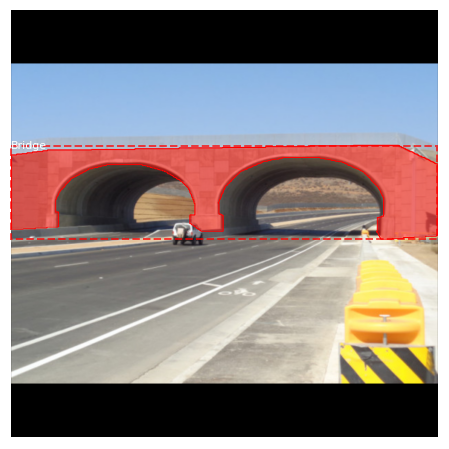

In [17]:
# Test on a random image
image_id = random.choice(dataset_val.image_ids)
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_val, inference_config, 
                           image_id, use_mini_mask=False)

log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                            dataset_train.class_names, figsize=(8, 8))

Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max: 1024.00000  int32
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


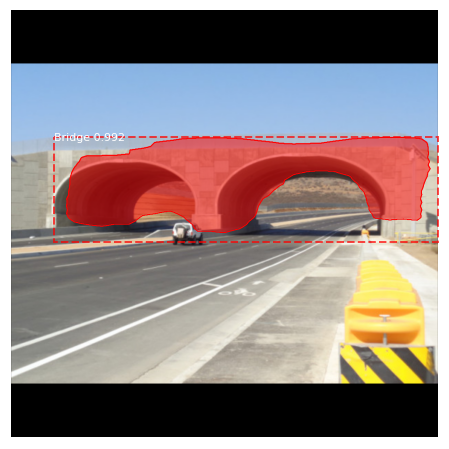

In [18]:
results = model.detect([original_image], verbose=1)

r = results[0]
visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                            dataset_val.class_names, r['scores'], ax=get_ax())

## Evaluation

In [19]:
# Compute VOC-Style mAP @ IoU=0.5
# Running on 10 images. Increase for better accuracy.
image_ids = np.random.choice(dataset_val.image_ids, 10)
APs = []
for image_id in image_ids:
    # Load image and ground truth data
    image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_val, inference_config,
                               image_id, use_mini_mask=False)
    molded_images = np.expand_dims(modellib.mold_image(image, inference_config), 0)
    # Run object detection
    results = model.detect([image], verbose=0)
    r = results[0]
    # Compute AP
    AP, precisions, recalls, overlaps =\
        utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                         r["rois"], r["class_ids"], r["scores"], r['masks'])
    APs.append(AP)
    
print("mAP: ", np.mean(APs))

mAP:  0.7333333343267441
